In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import sklearn
from sklearn import model_selection, preprocessing, metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
import warnings 
import catboost as cb

import shap
warnings.simplefilter('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from yellowbrick.regressor import CooksDistance
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

C:\Users\nanda\anaconda3\lib\site-packages\xgboost\compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Reading train and test Data files
df = pd.read_csv('train.csv')


In [3]:
df.columns

Index(['Unnamed: 0', 'delivery_duration', 'unit_price_k', 'type_of_sale',
       'date_of_sale', 'mode_of_transport', 'no_units', 'cust_group_name',
       'cust_segment_name', 'customer_id', 'delivery_month_from',
       'delivery_month_to', 'type', 'item_class_l1', 'item_class_l2',
       'item_class_l3', 'colour', 'plant_nr', 'plant_city',
       'plant_country_name', 'most_expensive_part_l1',
       'most_expensive_part_l2', 'shipto_city', 'shipto_nr', 'soldto_city',
       'soldto_nr', 'car_nr', 'shipto_country', 'soldto_country', 'lag_t28',
       'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60',
       'rolling_mean_t90', 'rolling_mean_t180'],
      dtype='object')

In [4]:
## Adding Year and Month in train & test data
df['date_of_sale'] = pd.to_datetime(df['date_of_sale'])
df["year"] = df["date_of_sale"].dt.year
df["month"] = df["date_of_sale"].dt.month

In [5]:
feature_lst = ['delivery_duration', 
               'mode_of_transport', 'no_units', 
               'cust_group_name', 'cust_segment_name', 'customer_id', 
               'type', 'item_class_l1', 'item_class_l2', 'item_class_l3',
               'colour', 'plant_nr', 'plant_city', 'plant_country_name', 'most_expensive_part_l1', 
               'most_expensive_part_l2', 'shipto_city', 'shipto_nr', 'soldto_city', 'soldto_nr', 
               'car_nr', 'shipto_country', 'soldto_country',
       'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60',
       'rolling_mean_t90', 'rolling_mean_t180',
       'month']

In [6]:

X = df[feature_lst]
y = df['unit_price_k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)



In [7]:
### STATSMODELS ###
price_predict_model = 'unit_price_k ~  delivery_duration + \
                mode_of_transport + no_units   + \
                cust_group_name + cust_segment_name + customer_id  +  \
                type + item_class_l1 + item_class_l2 + item_class_l3  + \
                colour + plant_nr + plant_city + plant_country_name + most_expensive_part_l1 + \
                most_expensive_part_l2 + shipto_city + shipto_nr + soldto_city + soldto_nr + \
                car_nr + shipto_country + soldto_country + \
        rolling_mean_t7  +  rolling_mean_t30  +  rolling_mean_t60  + \
        rolling_mean_t90  +  rolling_mean_t180    +\
        month  '
stats_model_fit = smf.ols(formula=price_predict_model, data=df).fit()

In [8]:
stats_model_fit.params

Intercept                 -828.085270
delivery_duration           43.883951
mode_of_transport          665.193353
no_units                    -0.008465
cust_group_name             -2.478958
cust_segment_name           39.294978
customer_id                 -0.803439
type                      2219.754364
item_class_l1             -546.196887
item_class_l2               53.677273
item_class_l3               -6.789122
colour                      25.678885
plant_nr                     1.841909
plant_city                 -56.203394
plant_country_name        2279.017783
most_expensive_part_l1       3.461084
most_expensive_part_l2     -22.851509
shipto_city                 -3.733575
shipto_nr                    0.061032
soldto_city                  0.801019
soldto_nr                   -0.025483
car_nr                       0.972088
shipto_country               5.105964
soldto_country              42.258343
rolling_mean_t7              0.214567
rolling_mean_t30             0.123262
rolling_mean

In [9]:
stats_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           unit_price_k   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     593.5
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:58:45   Log-Likelihood:            -1.8130e+05
No. Observations:               21140   AIC:                         3.627e+05
Df Residuals:                   21110   BIC:                         3.629e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -828.0853    366.063     -2.262      0.024   -1545.597    -110.574
delivery_duration         43.8840     12.039      3.645      0.000      20.286      67.482
mode_of_transport        665.1934     25.232     26.363      0.000     615.736     714.650
no_units                  -0.0085      0.001     -7.452      0.000      -0.011      -0.006
cust_group_name           -2.4790      0.696     -3.560      0.000      -3.844      -1.114
cust_segment_name         39.2950     11.495      3.418      0.001      16.763      61.827
customer_id               -0.8034      0.371     -2.168      0.030      -1.530      -0.077
type                    2219.7544    132.877     16.705      0.000    1959.306    2480.203
item_class_l1           -546.1969     24.648    -22.160      0.000    -594.510    -497.884
item_class_l2             53.6773      3.747     14.325      0.000      46.333      61.022
item_class_l3             -6.7891      1.535     -4.423      0.000      -9.798      -3.780
colour                    25.6789     22.836      1.124      0.261     -19.082      70.440
plant_nr                   1.8419      0.343      5.372      0.000       1.170       2.514
plant_city               -56.2034      4.172    -13.471      0.000     -64.381     -48.026
plant_country_name      2279.0178    119.308     19.102      0.000    2045.165    2512.871
most_expensive_part_l1     3.4611      2.072      1.670      0.095      -0.601       7.523
most_expensive_part_l2   -22.8515      5.076     -4.502      0.000     -32.801     -12.902
shipto_city               -3.7336      0.280    -13.324      0.000      -4.283      -3.184
shipto_nr                  0.0610      0.019      3.207      0.001       0.024       0.098
soldto_city                0.8010      0.560      1.431      0.153      -0.296       1.898
soldto_nr                 -0.0255      0.022     -1.142      0.253      -0.069       0.018
car_nr                     0.9721      0.136      7.123      0.000       0.705       1.240
shipto_country             5.1060      1.952      2.616      0.009       1.280       8.932
soldto_country            42.2583      3.003     14.071      0.000      36.372      48.145
rolling_mean_t7            0.2146      0.011     19.777      0.000       0.193       0.236
rolling_mean_t30           0.1233      0.021      5.844      0.000       0.082       0.165
rolling_mean_t60          -0.1174      0.034     -3.461      0.001      -0.184      -0.051
rolling_mean_t90           0.0572      0.033      1.746      0.081      -0.007       0.121
rolling_mean_t180          0.0878      0.018      4.871      0.000       0.052       0.123
month                      1.4031      2.557      0.549      0.583      -3.609       6.415
==============================================================================
O

In [10]:
predictions_stat = stats_model_fit.predict(X_test)

In [11]:
def rmse_accuracy_percentage(actual,predicted):    
    print("RMSE is:",np.round(np.sqrt(sum(((np.array(actual)-np.array(predicted))**2))/len(actual)),2))

In [12]:
rmse_accuracy_percentage(y_test,predictions_stat)

RMSE is: 1296.58


In [13]:
revenue_diff = y_test.sum() - predictions_stat.sum()
print(revenue_diff)


14744.827320364304


### Looks like there is multi-collinearity observed in the independent variables


In [14]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                   feature        VIF
0        delivery_duration   2.710696
1        mode_of_transport   1.215461
2                 no_units   1.343314
3          cust_group_name  12.546894
4        cust_segment_name   5.300366
5              customer_id  20.935055
6                     type   5.173069
7            item_class_l1   4.300906
8            item_class_l2   6.094229
9            item_class_l3   4.585334
10                  colour   6.482304
11                plant_nr  27.453914
12              plant_city   3.956380
13      plant_country_name   2.215427
14  most_expensive_part_l1  10.855696
15  most_expensive_part_l2  12.716840
16             shipto_city  11.023571
17               shipto_nr  59.776486
18             soldto_city  24.305609
19               soldto_nr  82.873906
20                  car_nr   4.741137
21          shipto_country   7.021319
22          soldto_country   8.682815
23         rolling_mean_t7   7.574625
24        rolling_mean_t30  25.520873
25        ro

### Variables with variation inflation factor > 10 (threshold), shows multicollinearity, deleting those variables and rebuilding model

In [15]:
vif_data=vif_data.loc[vif_data['VIF'] < 10]
vif_feature_lst = vif_data.feature.to_list()


In [16]:
X = df[vif_feature_lst]
y = df['unit_price_k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


### Lets regress the dependent value removing the redundant variables

In [17]:

price_predict_model = 'unit_price_k ~  delivery_duration+\
                mode_of_transport + no_units   + \
                cust_segment_name  + item_class_l2  +\
                type + item_class_l1+item_class_l3  + \
                colour + plant_city + plant_country_name + \
                shipto_city + \
                car_nr + shipto_country + soldto_country  + rolling_mean_t7 + month+rolling_mean_t180'
vif_statsmodel_fit = smf.ols(formula=price_predict_model, data=df).fit()

In [18]:
vif_statsmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           unit_price_k   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     939.4
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:58:46   Log-Likelihood:            -1.8138e+05
No. Observations:               21140   AIC:                         3.628e+05
Df Residuals:                   21121   BIC:                         3.630e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1146.9932     42.692     26.867      0.000    1063.314    1230.673
delivery_duration     37.2560     11.685      3.188      0.001      14.353      60.159
mode_of_transport    666.5944     24.997     26.667      0.000     617.599     715.590
no_units              -0.0084      0.001     -7.453      0.000      -0.011      -0.006
cust_segment_name      4.3194      9.908      0.436      0.663     -15.100      23.739
item_class_l2         52.7858      3.662     14.416      0.000      45.608      59.963
type                2297.5354    128.514     17.878      0.000    2045.639    2549.432
item_class_l1       -584.9142     23.954    -24.418      0.000    -631.866    -537.962
item_class_l3         -7.8639      1.519     -5.178      0.000     -10.841      -4.887
colour                21.0585     22.478      0.937      0.349     -23.001      65.118
plant_city           -61.3641      3.820    -16.064      0.000     -68.852     -53.877
plant_country_name  2363.0257    117.132     20.174      0.000    2133.438    2592.614
shipto_city           -4.1372      0.238    -17.358      0.000      -4.604      -3.670
car_nr                 0.8444      0.128      6.604      0.000       0.594       1.095
shipto_country         3.9239      1.900      2.065      0.039       0.200       7.648
soldto_country        45.2350      1.850     24.455      0.000      41.609      48.861
rolling_mean_t7        0.2660      0.007     38.476      0.000       0.252       0.280
month                  1.6160      2.558      0.632      0.528      -3.398       6.630
rolling_mean_t180      0.1065      0.010     10.352      0.000       0.086       0.127
==============================================================================
Omnibus:                    10978.317   Durbin-Watson:                   0.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           569146.467
Skew:                           1.754   Prob(JB):                         0.00
Kurtosis:                      28.176   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model R2 score is .445, which is not a good score. 
    - One possibilty is that there are too many categorical variables, and in order to bring out the model explanability we can create dummy variables to identify the significance of these categories on the output variable. Since we have already knocked out the variables based on VIF, we can now regress the model with dummy variables created for item_class_l2 and month
   

In [19]:
df = pd.get_dummies(df, columns=['item_class_l2','month'])

In [20]:
df.head()

,Unnamed: 0,delivery_duration,unit_price_k,type_of_sale,date_of_sale,mode_of_transport,no_units,cust_group_name,cust_segment_name,customer_id,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,1662.54,0,2159-09-26,0,2640.00,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,1662.54,0,2159-09-26,0,0.00,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,1662.54,0,2159-09-26,0,5720.00,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,1896.18,0,2161-02-26,0,2051.28,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1206.26,0,2160-06-22,0,1386.00,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [21]:
df.drop('Unnamed: 0',axis = 1,inplace = True)

In [22]:
feature_lst = ['delivery_duration', 'type_of_sale', 
       'mode_of_transport', 'no_units', 'cust_group_name', 'cust_segment_name',
       'customer_id', 'type',
       'item_class_l1', 'item_class_l3', 'colour', 'plant_nr', 'plant_city',
       'plant_country_name', 'most_expensive_part_l1',
       'most_expensive_part_l2', 'shipto_city', 'shipto_nr', 'soldto_city',
       'soldto_nr', 'car_nr', 'shipto_country', 'soldto_country', 'lag_t28',
       'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60',
       'rolling_mean_t90', 'rolling_mean_t180',
       'year', 'item_class_l2_0', 'item_class_l2_1',
       'item_class_l2_2', 'item_class_l2_3', 'item_class_l2_4',
       'item_class_l2_5', 'item_class_l2_6', 'item_class_l2_7',
       'item_class_l2_8', 'item_class_l2_9', 'item_class_l2_10',
       'item_class_l2_11', 'item_class_l2_12', 'item_class_l2_13', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

In [23]:
X = df[feature_lst]
y = df['unit_price_k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [24]:
### STATSMODELS ###
price_predict_model = 'unit_price_k ~  delivery_duration  +  type_of_sale  +\
        mode_of_transport  +  no_units  +  cust_group_name  +  cust_segment_name  +\
        customer_id  +  type  +\
        item_class_l1  +  item_class_l3  +  colour  +  plant_nr  +  plant_city  +\
        plant_country_name  +  most_expensive_part_l1  +\
        most_expensive_part_l2  +  shipto_city  +  shipto_nr  +  soldto_city  +\
        soldto_nr  +  car_nr  +  shipto_country  +  soldto_country  +  lag_t28  +\
        rolling_mean_t7  +  rolling_mean_t30  +  rolling_mean_t60  +\
        rolling_mean_t90  +  rolling_mean_t180  +\
        year  +  item_class_l2_0  +  item_class_l2_1  +\
        item_class_l2_2  +  item_class_l2_3  +  item_class_l2_4  +\
        item_class_l2_5  +  item_class_l2_6  +  item_class_l2_7  +\
        item_class_l2_8  +  item_class_l2_9  +  item_class_l2_10  +\
        item_class_l2_11  +  item_class_l2_12  +  item_class_l2_13  +  month_1  +\
        month_2  +  month_3  +  month_4  +  month_5  +  month_6  +  month_7  +\
        month_8  +  month_9  +  month_10  +  month_11  +  month_12'
statsmodelwithdumy = smf.ols(formula=price_predict_model, data=df).fit()

In [25]:
statsmodelwithdumy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           unit_price_k   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     405.3
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:58:47   Log-Likelihood:            -1.8028e+05
No. Observations:               21140   AIC:                         3.607e+05
Df Residuals:                   21087   BIC:                         3.611e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.615e+05   1.71e+04    -15.286      0.000   -2.95e+05   -2.28e+05
delivery_duration         75.6927     11.814      6.407      0.000      52.537      98.849
type_of_sale            -7.31e-05   4.78e-06    -15.287      0.000   -8.25e-05   -6.37e-05
mode_of_transport        687.9318     24.490     28.090      0.000     639.929     735.934
no_units                  -0.0056      0.001     -5.138      0.000      -0.008      -0.003
cust_group_name            0.0981      0.690      0.142      0.887      -1.255       1.451
cust_segment_name         30.8815     11.131      2.774      0.006       9.064      52.699
customer_id               -1.7935      0.363     -4.938      0.000      -2.505      -1.082
type                    2179.5037    127.820     17.051      0.000    1928.967    2430.040
item_class_l1          -2.031e+04   1348.819    -15.055      0.000    -2.3e+04   -1.77e+04
item_class_l3             -7.1085      1.627     -4.368      0.000     -10.298      -3.919
colour                    55.7833     22.009      2.535      0.011      12.645      98.922
plant_nr                   4.2207      0.378     11.169      0.000       3.480       4.961
plant_city               -44.0061      4.186    -10.513      0.000     -52.210     -35.802
plant_country_name      1850.2668    116.562     15.874      0.000    1621.796    2078.738
most_expensive_part_l1     4.3445      2.046      2.123      0.034       0.334       8.355
most_expensive_part_l2    -7.4161      4.961     -1.495      0.135     -17.140       2.308
shipto_city               -3.3414      0.271    -12.338      0.000      -3.872      -2.811
shipto_nr                  0.0175      0.018      0.950      0.342      -0.019       0.054
soldto_city                1.6244      0.544      2.988      0.003       0.559       2.690
soldto_nr                  0.0036      0.021      0.167      0.867      -0.038       0.046
car_nr                    -0.0106      0.143     -0.074      0.941      -0.290       0.269
shipto_country            -0.7824      1.909     -0.410      0.682      -4.524       2.959
soldto_country            36.7214      2.981     12.318      0.000      30.878      42.565
lag_t28                    0.1092      0.011      9.613      0.000       0.087       0.131
rolling_mean_t7            0.0743      0.016      4.721      0.000       0.043       0.105
rolling_mean_t30           0.1362      0.020      6.728      0.000       0.097       0.176
rolling_mean_t60          -0.1423      0.032     -4.381      0.000      -0.206      -0.079
rolling_mean_t90           0.0978      0.032      3.101      0.002       0.036       0.160
rolling_mean_t180          0.0713      0.017      4.081      0.000       0.037       0.106
year                     143.1189      9.448     15.148      0.000     124.601  

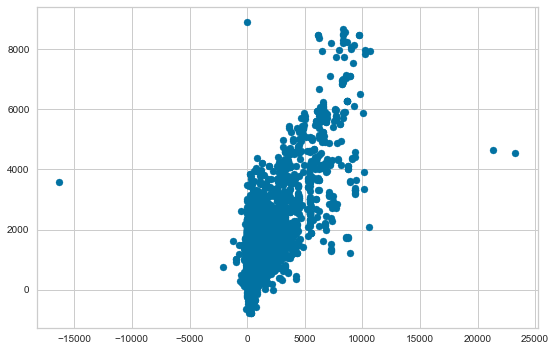

In [26]:
#### STATSMODELS ###
predictions_stat= statsmodelwithdumy.predict(X_test)
plt.scatter(y_test,predictions_stat)

In [27]:
predictions_stat = statsmodelwithdumy.predict(X_test)
rmse_accuracy_percentage(y_test,predictions_stat)

RMSE is: 1232.35


#### Revenue difference between actuals and the predicted values

In [28]:
revenue_diff = y_test.sum() - predictions_stat.sum()
print(revenue_diff)


16946.047877352685


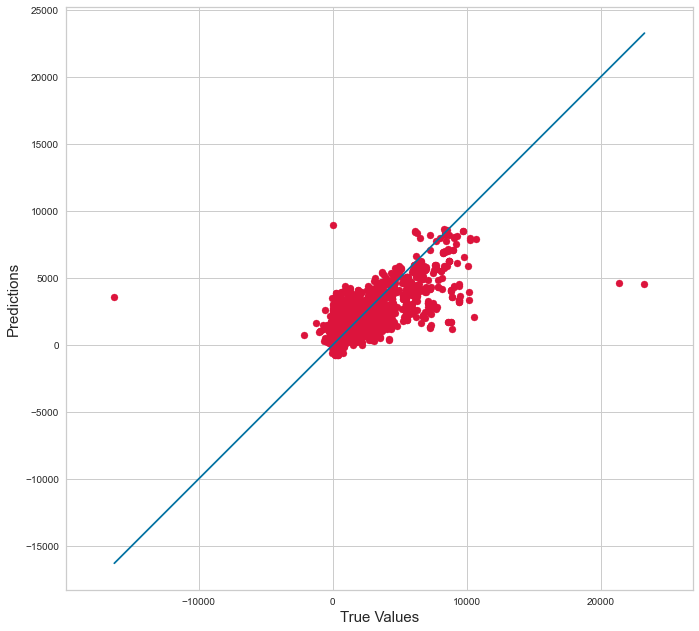

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,predictions_stat, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(predictions_stat), max(y_test))
p2 = min(min(predictions_stat), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [30]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [31]:
mape(y_test,predictions_stat)

inf

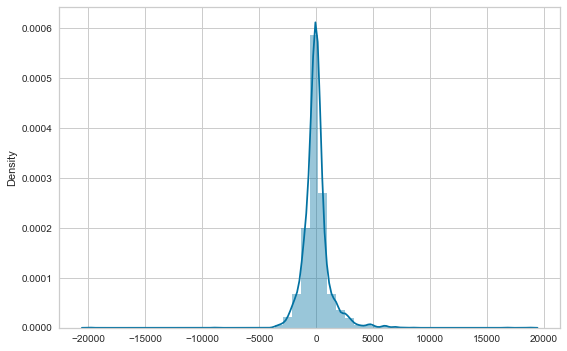

In [32]:
sns.distplot((y_test-predictions_stat),bins=50);

In [33]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions_stat))
print('MSE:', metrics.mean_squared_error(y_test, predictions_stat))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_stat)))

MAE: 735.1614101095098
MSE: 1518693.1984725608
RMSE: 1232.3527086319732


In [34]:
# fitted values (need a constant term for intercept)
statsmodelwithdumy_fitted_y = statsmodelwithdumy.fittedvalues

# model residuals
statsmodelwithdumy_residuals = statsmodelwithdumy.resid

# normalized residuals
statsmodelwithdumy_norm_residuals = statsmodelwithdumy.get_influence().resid_studentized_internal

# absolute squared normalized residuals
statsmodelwithdumy_norm_residuals_abs_sqrt = np.sqrt(np.abs(statsmodelwithdumy_norm_residuals))

# absolute residuals
statsmodelwithdumy_abs_resid = np.abs(statsmodelwithdumy_norm_residuals)

# leverage, from statsmodels internals
statsmodelwithdumy_leverage = statsmodelwithdumy.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
statsmodelwithdumy_cooks = statsmodelwithdumy.get_influence().cooks_distance[0]

Text(0, 0.5, 'Residuals')

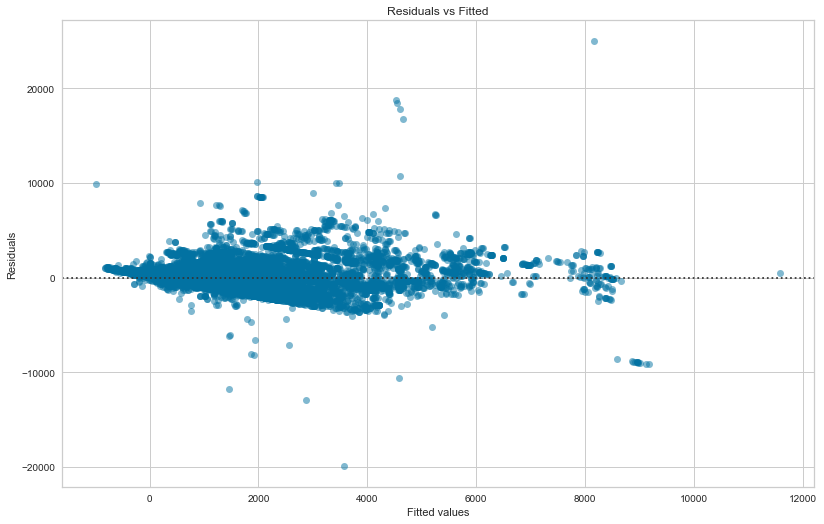

In [35]:
# Plotting Residuals vs Fitted
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(statsmodelwithdumy_fitted_y, 'unit_price_k', data=df, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
 
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

### Conduct the Breusch-Pagan test to check for homoscedasticity

In [36]:

names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
# Get the test result
test_result = sms.het_breuschpagan(statsmodelwithdumy.resid, statsmodelwithdumy.model.exog)
 
lzip(names, test_result)

[('Lagrange multiplier statistic', 1199.8454740027244),
 ('p-value', 2.8081501502252657e-214),
 ('f-value', 24.401035259038128),
 ('f p-value', 5.111471506224106e-224)]

### P-value is significantly low, means we reject the null hypothesis, thus shows heteroscedasticity

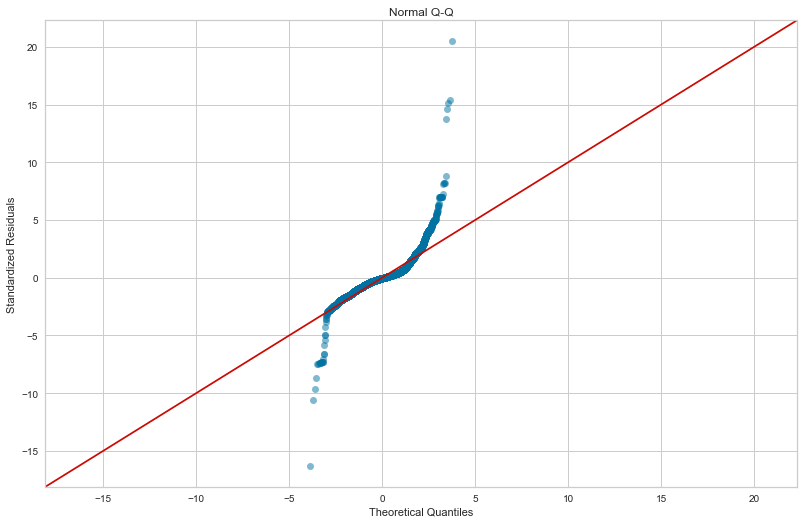

In [37]:
QQ = ProbPlot(statsmodelwithdumy_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

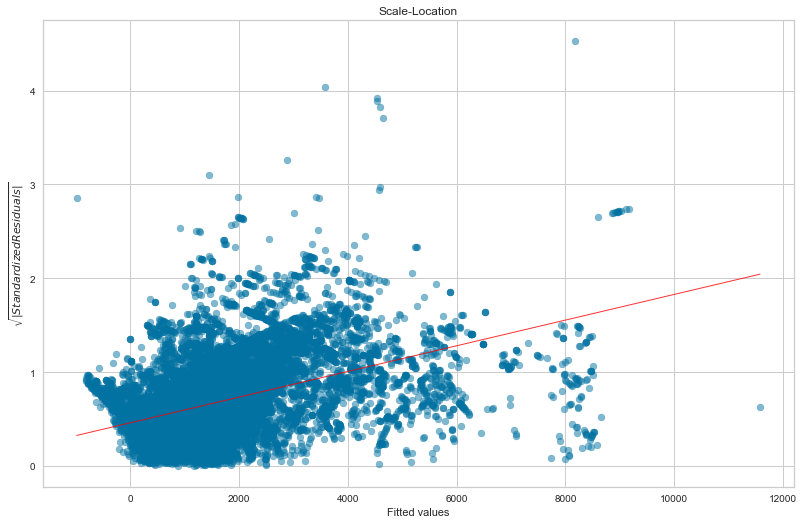

In [38]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(statsmodelwithdumy_fitted_y, statsmodelwithdumy_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(statsmodelwithdumy_fitted_y, statsmodelwithdumy_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

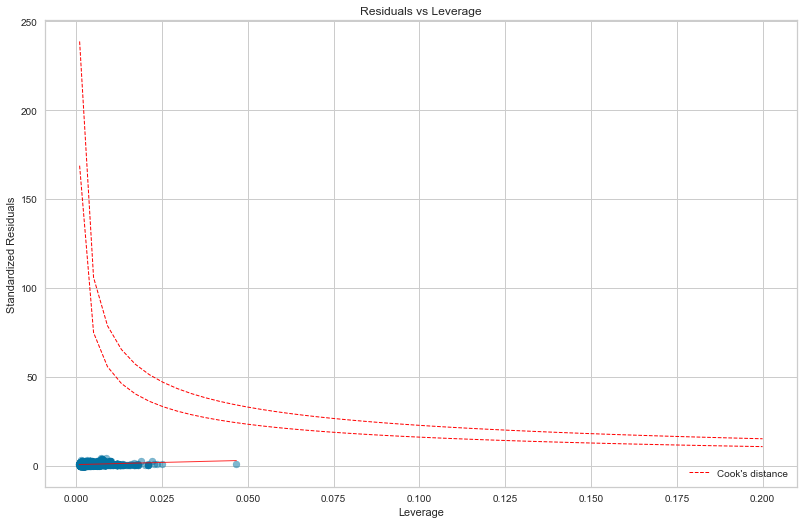

In [39]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(statsmodelwithdumy_leverage, statsmodelwithdumy_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(statsmodelwithdumy_leverage, statsmodelwithdumy_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0]#.set_xlim(0, 0.05)
plot_lm_4.axes[0]#.set_ylim(-1, 20)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

    
# Calculating Cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(statsmodelwithdumy.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='lower right');

feature_lst = ['delivery_duration', 
               'mode_of_transport', 'no_units', 
               'cust_group_name', 'cust_segment_name', 'customer_id', 
               'type', 'item_class_l1', 'item_class_l2', 'item_class_l3',
               'colour', 'plant_nr', 'plant_city', 'plant_country_name', 'most_expensive_part_l1', 
               'most_expensive_part_l2', 'shipto_city', 'shipto_nr', 'soldto_city', 'soldto_nr', 
               'car_nr', 'shipto_country', 'soldto_country']

df = pd.read_csv('train.csv')
X = df[feature_lst]
y = df['unit_price_k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

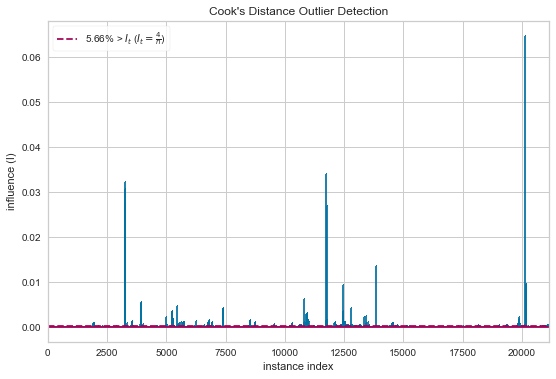

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [40]:


# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

In [41]:
df = pd.read_csv('train.csv')
feature_lst = ['delivery_duration', 
               'mode_of_transport', 'no_units', 
               'cust_group_name', 'cust_segment_name', 'customer_id', 
               'type', 'item_class_l1', 'item_class_l2', 'item_class_l3',
               'colour', 'plant_nr', 'plant_city', 'plant_country_name', 'most_expensive_part_l1', 
               'most_expensive_part_l2', 'shipto_city', 'shipto_nr', 'soldto_city', 'soldto_nr', 
               'car_nr', 'shipto_country', 'soldto_country','rolling_mean_t7','rolling_mean_t30','rolling_mean_t60',
              'rolling_mean_t90','rolling_mean_t180']
X = df[feature_lst]
y = df['unit_price_k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


In [42]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [43]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [44]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 2311.7569546	test: 2131.7720287	best: 2131.7720287 (0)	total: 148ms	remaining: 14.7s
1:	learn: 2270.7952187	test: 2092.2282997	best: 2092.2282997 (1)	total: 153ms	remaining: 7.5s
2:	learn: 2232.5514900	test: 2055.3538834	best: 2055.3538834 (2)	total: 157ms	remaining: 5.06s
3:	learn: 2195.7069577	test: 2019.8015116	best: 2019.8015116 (3)	total: 159ms	remaining: 3.82s
4:	learn: 2159.7904623	test: 1984.5600588	best: 1984.5600588 (4)	total: 162ms	remaining: 3.07s
5:	learn: 2124.3664242	test: 1949.5828311	best: 1949.5828311 (5)	total: 163ms	remaining: 2.56s
6:	learn: 2090.2514577	test: 1915.7770620	best: 1915.7770620 (6)	total: 165ms	remaining: 2.19s
7:	learn: 2060.4260959	test: 1886.1324681	best: 1886.1324681 (7)	total: 167ms	remaining: 1.92s
8:	learn: 2029.7822982	test: 1856.7319656	best: 1856.7319656 (8)	total: 168ms	remaining: 1.7s
9:	learn: 2000.3020504	test: 1827.9030509	best: 1827.9030509 (9)	total: 170ms	remaining: 1.53s
10:	learn: 1971.0834268	test: 1798.8949082	best: 179

1:	learn: 2093.7586211	test: 1921.9841795	best: 1921.9841795 (1)	total: 3.42ms	remaining: 168ms
2:	learn: 1985.2268420	test: 1814.5944227	best: 1814.5944227 (2)	total: 5.37ms	remaining: 174ms
3:	learn: 1892.7354411	test: 1722.1188768	best: 1722.1188768 (3)	total: 6.96ms	remaining: 167ms
4:	learn: 1813.5746144	test: 1646.1156997	best: 1646.1156997 (4)	total: 8.6ms	remaining: 163ms
5:	learn: 1747.0591813	test: 1583.9046364	best: 1583.9046364 (5)	total: 10.3ms	remaining: 161ms
6:	learn: 1687.5323653	test: 1528.5054964	best: 1528.5054964 (6)	total: 11.8ms	remaining: 157ms
7:	learn: 1636.1747281	test: 1481.0452886	best: 1481.0452886 (7)	total: 13.5ms	remaining: 155ms
8:	learn: 1593.8954790	test: 1441.3295615	best: 1441.3295615 (8)	total: 15ms	remaining: 151ms
9:	learn: 1555.5259778	test: 1406.1017849	best: 1406.1017849 (9)	total: 16.5ms	remaining: 148ms
10:	learn: 1521.3757283	test: 1375.6616984	best: 1375.6616984 (10)	total: 18.1ms	remaining: 146ms
11:	learn: 1492.6906111	test: 1349.040574

13:	learn: 1893.1765630	test: 1723.5307864	best: 1723.5307864 (13)	total: 22.6ms	remaining: 139ms
14:	learn: 1870.5989583	test: 1700.9984570	best: 1700.9984570 (14)	total: 24.4ms	remaining: 138ms
15:	learn: 1847.6179147	test: 1679.2165321	best: 1679.2165321 (15)	total: 26.1ms	remaining: 137ms
16:	learn: 1824.6068079	test: 1656.4981847	best: 1656.4981847 (16)	total: 27.8ms	remaining: 136ms
17:	learn: 1802.6869970	test: 1634.8866668	best: 1634.8866668 (17)	total: 29.5ms	remaining: 134ms
18:	learn: 1782.3869610	test: 1614.7215381	best: 1614.7215381 (18)	total: 31.1ms	remaining: 132ms
19:	learn: 1763.9920623	test: 1597.9866697	best: 1597.9866697 (19)	total: 32.7ms	remaining: 131ms
20:	learn: 1745.2980344	test: 1580.0573868	best: 1580.0573868 (20)	total: 34.4ms	remaining: 129ms
21:	learn: 1726.8114940	test: 1562.0863218	best: 1562.0863218 (21)	total: 36.3ms	remaining: 129ms
22:	learn: 1709.9124020	test: 1546.2307639	best: 1546.2307639 (22)	total: 38.2ms	remaining: 128ms
23:	learn: 1693.0739

22:	learn: 1328.7698294	test: 1206.0886796	best: 1206.0886796 (22)	total: 37.1ms	remaining: 124ms
23:	learn: 1320.5981314	test: 1200.3474852	best: 1200.3474852 (23)	total: 39ms	remaining: 123ms
24:	learn: 1305.6448189	test: 1185.7553609	best: 1185.7553609 (24)	total: 40.5ms	remaining: 122ms
25:	learn: 1298.2699352	test: 1178.7183898	best: 1178.7183898 (25)	total: 42.1ms	remaining: 120ms
26:	learn: 1292.1063290	test: 1173.1051856	best: 1173.1051856 (26)	total: 43.8ms	remaining: 118ms
27:	learn: 1285.0111478	test: 1168.5005439	best: 1168.5005439 (27)	total: 45.4ms	remaining: 117ms
28:	learn: 1278.9432850	test: 1162.6649513	best: 1162.6649513 (28)	total: 47.1ms	remaining: 115ms
29:	learn: 1273.1134829	test: 1157.0847785	best: 1157.0847785 (29)	total: 48.9ms	remaining: 114ms
30:	learn: 1268.2761367	test: 1153.5576070	best: 1153.5576070 (30)	total: 50.8ms	remaining: 113ms
31:	learn: 1259.3912602	test: 1143.9679749	best: 1143.9679749 (31)	total: 53ms	remaining: 113ms
32:	learn: 1248.0232974	

23:	learn: 1693.4575608	test: 1530.6811948	best: 1530.6811948 (23)	total: 42.8ms	remaining: 135ms
24:	learn: 1677.8962463	test: 1516.7604069	best: 1516.7604069 (24)	total: 44.7ms	remaining: 134ms
25:	learn: 1662.9613395	test: 1502.8909077	best: 1502.8909077 (25)	total: 46.5ms	remaining: 132ms
26:	learn: 1647.9069981	test: 1488.4485477	best: 1488.4485477 (26)	total: 48.3ms	remaining: 131ms
27:	learn: 1633.8237676	test: 1475.5934950	best: 1475.5934950 (27)	total: 50.2ms	remaining: 129ms
28:	learn: 1621.5105510	test: 1463.4610951	best: 1463.4610951 (28)	total: 52.1ms	remaining: 128ms
29:	learn: 1609.0378759	test: 1451.8004393	best: 1451.8004393 (29)	total: 53.9ms	remaining: 126ms
30:	learn: 1596.5721443	test: 1440.2464470	best: 1440.2464470 (30)	total: 56.1ms	remaining: 125ms
31:	learn: 1584.9014295	test: 1429.5867336	best: 1429.5867336 (31)	total: 58.2ms	remaining: 124ms
32:	learn: 1573.1384341	test: 1418.8826292	best: 1418.8826292 (32)	total: 60.2ms	remaining: 122ms
33:	learn: 1562.4269

23:	learn: 1323.2172801	test: 1200.8340035	best: 1200.8340035 (23)	total: 39.5ms	remaining: 125ms
24:	learn: 1309.0953931	test: 1186.9736046	best: 1186.9736046 (24)	total: 41.4ms	remaining: 124ms
25:	learn: 1297.9916404	test: 1177.1864202	best: 1177.1864202 (25)	total: 43.2ms	remaining: 123ms
26:	learn: 1289.8495657	test: 1169.4446012	best: 1169.4446012 (26)	total: 45ms	remaining: 122ms
27:	learn: 1283.9392385	test: 1163.6379750	best: 1163.6379750 (27)	total: 47ms	remaining: 121ms
28:	learn: 1277.8750646	test: 1157.7896926	best: 1157.7896926 (28)	total: 48.9ms	remaining: 120ms
29:	learn: 1271.9823139	test: 1152.1847308	best: 1152.1847308 (29)	total: 50.6ms	remaining: 118ms
30:	learn: 1267.3027482	test: 1148.9099113	best: 1148.9099113 (30)	total: 52.4ms	remaining: 117ms
31:	learn: 1258.8431160	test: 1139.3490481	best: 1139.3490481 (31)	total: 54.2ms	remaining: 115ms
32:	learn: 1253.0215778	test: 1135.6910976	best: 1135.6910976 (32)	total: 56.1ms	remaining: 114ms
33:	learn: 1248.1898854	

23:	learn: 1694.9715950	test: 1531.7720309	best: 1531.7720309 (23)	total: 38.1ms	remaining: 121ms
24:	learn: 1679.4542231	test: 1517.8640538	best: 1517.8640538 (24)	total: 39.9ms	remaining: 120ms
25:	learn: 1664.5254488	test: 1503.9923738	best: 1503.9923738 (25)	total: 41.6ms	remaining: 118ms
26:	learn: 1649.4689205	test: 1489.5439176	best: 1489.5439176 (26)	total: 43.4ms	remaining: 117ms
27:	learn: 1635.4440378	test: 1476.7178024	best: 1476.7178024 (27)	total: 45.2ms	remaining: 116ms
28:	learn: 1623.1458772	test: 1464.5968122	best: 1464.5968122 (28)	total: 47.1ms	remaining: 115ms
29:	learn: 1610.6654476	test: 1452.9266262	best: 1452.9266262 (29)	total: 48.8ms	remaining: 114ms
30:	learn: 1598.6318415	test: 1442.3955288	best: 1442.3955288 (30)	total: 51ms	remaining: 114ms
31:	learn: 1586.5244490	test: 1431.1100190	best: 1431.1100190 (31)	total: 52.9ms	remaining: 112ms
32:	learn: 1574.7215520	test: 1420.3358867	best: 1420.3358867 (32)	total: 55ms	remaining: 112ms
33:	learn: 1563.9974407	

35:	learn: 1234.9081644	test: 1117.3149031	best: 1117.3149031 (35)	total: 58.7ms	remaining: 104ms
36:	learn: 1230.6463457	test: 1113.3044736	best: 1113.3044736 (36)	total: 60.9ms	remaining: 104ms
37:	learn: 1227.1434639	test: 1109.8655181	best: 1109.8655181 (37)	total: 62.7ms	remaining: 102ms
38:	learn: 1222.6425498	test: 1107.1109907	best: 1107.1109907 (38)	total: 64.3ms	remaining: 101ms
39:	learn: 1219.5793856	test: 1103.6807201	best: 1103.6807201 (39)	total: 66.1ms	remaining: 99.1ms
40:	learn: 1214.9943065	test: 1098.9505300	best: 1098.9505300 (40)	total: 67.8ms	remaining: 97.6ms
41:	learn: 1211.1805635	test: 1095.0646043	best: 1095.0646043 (41)	total: 69.6ms	remaining: 96.1ms
42:	learn: 1207.9034974	test: 1092.6015902	best: 1092.6015902 (42)	total: 71.3ms	remaining: 94.6ms
43:	learn: 1204.4478167	test: 1089.4340240	best: 1089.4340240 (43)	total: 73ms	remaining: 92.9ms
44:	learn: 1194.2183129	test: 1079.7189583	best: 1079.7189583 (44)	total: 75.1ms	remaining: 91.8ms
45:	learn: 1192.

37:	learn: 1522.8817877	test: 1373.2657184	best: 1373.2657184 (37)	total: 64.5ms	remaining: 190ms
38:	learn: 1514.0061130	test: 1365.5801358	best: 1365.5801358 (38)	total: 66.4ms	remaining: 189ms
39:	learn: 1505.7334308	test: 1357.7421711	best: 1357.7421711 (39)	total: 68.2ms	remaining: 188ms
40:	learn: 1497.4262297	test: 1349.5264656	best: 1349.5264656 (40)	total: 70ms	remaining: 186ms
41:	learn: 1489.1569131	test: 1342.5096364	best: 1342.5096364 (41)	total: 71.7ms	remaining: 184ms
42:	learn: 1481.6589728	test: 1335.8991311	best: 1335.8991311 (42)	total: 74.6ms	remaining: 186ms
43:	learn: 1474.4334637	test: 1329.8928336	best: 1329.8928336 (43)	total: 76.2ms	remaining: 184ms
44:	learn: 1467.7417754	test: 1324.2068988	best: 1324.2068988 (44)	total: 78.4ms	remaining: 183ms
45:	learn: 1460.8070349	test: 1317.9698743	best: 1317.9698743 (45)	total: 80.2ms	remaining: 181ms
46:	learn: 1454.2017226	test: 1311.9920105	best: 1311.9920105 (46)	total: 82.2ms	remaining: 180ms
47:	learn: 1447.893675


bestTest = 1082.79545
bestIteration = 149

8:	loss: 1082.7954497	best: 979.3201147 (1)	total: 1.87s	remaining: 18.1s
0:	learn: 2214.8274101	test: 2038.6040793	best: 2038.6040793 (0)	total: 1.85ms	remaining: 277ms
1:	learn: 2093.7586211	test: 1921.9841795	best: 1921.9841795 (1)	total: 3.6ms	remaining: 267ms
2:	learn: 1985.2268420	test: 1814.5944227	best: 1814.5944227 (2)	total: 5.58ms	remaining: 273ms
3:	learn: 1892.7354411	test: 1722.1188768	best: 1722.1188768 (3)	total: 7.86ms	remaining: 287ms
4:	learn: 1813.5746144	test: 1646.1156997	best: 1646.1156997 (4)	total: 9.75ms	remaining: 283ms
5:	learn: 1747.0591813	test: 1583.9046364	best: 1583.9046364 (5)	total: 11.6ms	remaining: 278ms
6:	learn: 1687.5323653	test: 1528.5054964	best: 1528.5054964 (6)	total: 13.2ms	remaining: 269ms
7:	learn: 1636.1747281	test: 1481.0452886	best: 1481.0452886 (7)	total: 15.1ms	remaining: 268ms
8:	learn: 1593.8954790	test: 1441.3295615	best: 1441.3295615 (8)	total: 16.7ms	remaining: 262ms
9:	learn: 1555.5259

101:	learn: 1076.1468286	test: 977.2992777	best: 977.2992777 (101)	total: 169ms	remaining: 79.7ms
102:	learn: 1075.0008650	test: 976.0162050	best: 976.0162050 (102)	total: 171ms	remaining: 78.2ms
103:	learn: 1074.3763763	test: 975.6148740	best: 975.6148740 (103)	total: 173ms	remaining: 76.5ms
104:	learn: 1073.4496924	test: 974.7200301	best: 974.7200301 (104)	total: 175ms	remaining: 74.9ms
105:	learn: 1072.6182350	test: 973.4979348	best: 973.4979348 (105)	total: 177ms	remaining: 73.3ms
106:	learn: 1071.2041592	test: 971.3179443	best: 971.3179443 (106)	total: 179ms	remaining: 71.7ms
107:	learn: 1069.1444176	test: 969.6864753	best: 969.6864753 (107)	total: 181ms	remaining: 70.2ms
108:	learn: 1068.3305056	test: 969.4605107	best: 969.4605107 (108)	total: 183ms	remaining: 68.7ms
109:	learn: 1067.3352787	test: 968.5466714	best: 968.5466714 (109)	total: 185ms	remaining: 67.2ms
110:	learn: 1066.6720676	test: 968.3875937	best: 968.3875937 (110)	total: 187ms	remaining: 65.6ms
111:	learn: 1066.008

64:	learn: 1365.0014063	test: 1232.5347080	best: 1232.5347080 (64)	total: 109ms	remaining: 142ms
65:	learn: 1361.2075485	test: 1228.8009800	best: 1228.8009800 (65)	total: 111ms	remaining: 141ms
66:	learn: 1358.1212687	test: 1225.9575627	best: 1225.9575627 (66)	total: 113ms	remaining: 139ms
67:	learn: 1355.3555814	test: 1223.5543946	best: 1223.5543946 (67)	total: 114ms	remaining: 138ms
68:	learn: 1351.9350532	test: 1220.2046509	best: 1220.2046509 (68)	total: 116ms	remaining: 136ms
69:	learn: 1349.0596094	test: 1218.1898610	best: 1218.1898610 (69)	total: 118ms	remaining: 134ms
70:	learn: 1346.1962563	test: 1215.8829651	best: 1215.8829651 (70)	total: 119ms	remaining: 133ms
71:	learn: 1343.0301027	test: 1212.9052252	best: 1212.9052252 (71)	total: 121ms	remaining: 131ms
72:	learn: 1340.4216450	test: 1210.9453473	best: 1210.9453473 (72)	total: 123ms	remaining: 130ms
73:	learn: 1336.4830388	test: 1206.8778344	best: 1206.8778344 (73)	total: 125ms	remaining: 128ms
74:	learn: 1333.4645804	test: 

18:	learn: 1367.9234883	test: 1239.8857164	best: 1239.8857164 (18)	total: 34.3ms	remaining: 236ms
19:	learn: 1356.8393637	test: 1231.1161992	best: 1231.1161992 (19)	total: 36.2ms	remaining: 235ms
20:	learn: 1346.5418911	test: 1223.5589987	best: 1223.5589987 (20)	total: 37.9ms	remaining: 233ms
21:	learn: 1338.6683306	test: 1215.6426110	best: 1215.6426110 (21)	total: 39.9ms	remaining: 232ms
22:	learn: 1328.7698294	test: 1206.0886796	best: 1206.0886796 (22)	total: 41.6ms	remaining: 230ms
23:	learn: 1320.5981314	test: 1200.3474852	best: 1200.3474852 (23)	total: 43.3ms	remaining: 227ms
24:	learn: 1305.6448189	test: 1185.7553609	best: 1185.7553609 (24)	total: 45ms	remaining: 225ms
25:	learn: 1298.2699352	test: 1178.7183898	best: 1178.7183898 (25)	total: 46.6ms	remaining: 222ms
26:	learn: 1292.1063290	test: 1173.1051856	best: 1173.1051856 (26)	total: 48.9ms	remaining: 223ms
27:	learn: 1285.0111478	test: 1168.5005439	best: 1168.5005439 (27)	total: 50.7ms	remaining: 221ms
28:	learn: 1278.943285

110:	learn: 1068.3303262	test: 968.7718458	best: 968.7718458 (110)	total: 208ms	remaining: 73.2ms
111:	learn: 1067.6672566	test: 968.3768941	best: 968.3768941 (111)	total: 210ms	remaining: 71.3ms
112:	learn: 1066.0017181	test: 967.0448131	best: 967.0448131 (112)	total: 213ms	remaining: 69.7ms
113:	learn: 1065.0954589	test: 966.3045332	best: 966.3045332 (113)	total: 215ms	remaining: 67.8ms
114:	learn: 1063.8017299	test: 965.1626107	best: 965.1626107 (114)	total: 216ms	remaining: 65.9ms
115:	learn: 1062.7017542	test: 964.1162751	best: 964.1162751 (115)	total: 218ms	remaining: 63.9ms
116:	learn: 1061.2660795	test: 962.2990091	best: 962.2990091 (116)	total: 220ms	remaining: 62.1ms
117:	learn: 1059.5690091	test: 960.8007758	best: 960.8007758 (117)	total: 222ms	remaining: 60.2ms
118:	learn: 1058.7028849	test: 960.1077267	best: 960.1077267 (118)	total: 224ms	remaining: 58.3ms
119:	learn: 1057.3533816	test: 959.2926461	best: 959.2926461 (119)	total: 226ms	remaining: 56.4ms
120:	learn: 1056.412

62:	learn: 1372.1059169	test: 1238.6883335	best: 1238.6883335 (62)	total: 108ms	remaining: 149ms
63:	learn: 1368.4775799	test: 1235.7666416	best: 1235.7666416 (63)	total: 110ms	remaining: 147ms
64:	learn: 1365.3249522	test: 1232.6971173	best: 1232.6971173 (64)	total: 112ms	remaining: 146ms
65:	learn: 1361.5303892	test: 1228.9622727	best: 1228.9622727 (65)	total: 113ms	remaining: 144ms
66:	learn: 1358.4398549	test: 1226.1151039	best: 1226.1151039 (66)	total: 115ms	remaining: 143ms
67:	learn: 1355.6725313	test: 1223.7105503	best: 1223.7105503 (67)	total: 117ms	remaining: 141ms
68:	learn: 1352.2513185	test: 1220.3597396	best: 1220.3597396 (68)	total: 119ms	remaining: 140ms
69:	learn: 1349.3695876	test: 1218.3405266	best: 1218.3405266 (69)	total: 121ms	remaining: 138ms
70:	learn: 1346.5002591	test: 1216.0306173	best: 1216.0306173 (70)	total: 123ms	remaining: 136ms
71:	learn: 1343.3358050	test: 1213.0544186	best: 1213.0544186 (71)	total: 125ms	remaining: 135ms
72:	learn: 1340.7213610	test: 

11:	learn: 1493.3460967	test: 1349.4417521	best: 1349.4417521 (11)	total: 22.3ms	remaining: 256ms
12:	learn: 1470.3779952	test: 1327.0387871	best: 1327.0387871 (12)	total: 24.1ms	remaining: 255ms
13:	learn: 1447.8519649	test: 1306.5477806	best: 1306.5477806 (13)	total: 25.8ms	remaining: 251ms
14:	learn: 1426.4442896	test: 1286.6734409	best: 1286.6734409 (14)	total: 27.6ms	remaining: 249ms
15:	learn: 1408.4349315	test: 1270.8778507	best: 1270.8778507 (15)	total: 29.3ms	remaining: 246ms
16:	learn: 1393.4783924	test: 1256.7271540	best: 1256.7271540 (16)	total: 31.1ms	remaining: 244ms
17:	learn: 1380.2995230	test: 1245.6507882	best: 1245.6507882 (17)	total: 32.8ms	remaining: 241ms
18:	learn: 1368.1544107	test: 1235.3208563	best: 1235.3208563 (18)	total: 34.6ms	remaining: 239ms
19:	learn: 1357.2610334	test: 1226.7105170	best: 1226.7105170 (19)	total: 36.2ms	remaining: 235ms
20:	learn: 1347.2016641	test: 1219.9479800	best: 1219.9479800 (20)	total: 37.9ms	remaining: 233ms
21:	learn: 1338.7834

114:	learn: 1076.2766301	test: 969.4502235	best: 969.4502235 (114)	total: 203ms	remaining: 61.7ms
115:	learn: 1075.2611200	test: 968.6493811	best: 968.6493811 (115)	total: 205ms	remaining: 60.1ms
116:	learn: 1074.3392730	test: 967.9250134	best: 967.9250134 (116)	total: 207ms	remaining: 58.3ms
117:	learn: 1072.9825012	test: 966.8001143	best: 966.8001143 (117)	total: 209ms	remaining: 56.6ms
118:	learn: 1071.3641025	test: 965.4840880	best: 965.4840880 (118)	total: 210ms	remaining: 54.8ms
119:	learn: 1069.8621407	test: 963.5519391	best: 963.5519391 (119)	total: 212ms	remaining: 53ms
120:	learn: 1068.5010011	test: 962.7571519	best: 962.7571519 (120)	total: 214ms	remaining: 51.3ms
121:	learn: 1067.6464280	test: 961.9915508	best: 961.9915508 (121)	total: 216ms	remaining: 49.5ms
122:	learn: 1066.8531141	test: 961.2183048	best: 961.2183048 (122)	total: 218ms	remaining: 47.8ms
123:	learn: 1066.3607999	test: 960.6902970	best: 960.6902970 (123)	total: 219ms	remaining: 46ms
124:	learn: 1065.1357368

73:	learn: 1335.3174021	test: 1204.1220974	best: 1204.1220974 (73)	total: 126ms	remaining: 129ms
74:	learn: 1332.4237551	test: 1201.3398221	best: 1201.3398221 (74)	total: 128ms	remaining: 128ms
75:	learn: 1329.8965718	test: 1198.9040582	best: 1198.9040582 (75)	total: 130ms	remaining: 126ms
76:	learn: 1327.4542147	test: 1197.3669303	best: 1197.3669303 (76)	total: 131ms	remaining: 125ms
77:	learn: 1325.1752083	test: 1195.4987558	best: 1195.4987558 (77)	total: 133ms	remaining: 123ms
78:	learn: 1322.8455633	test: 1193.4958075	best: 1193.4958075 (78)	total: 135ms	remaining: 121ms
79:	learn: 1318.8830604	test: 1189.3806122	best: 1189.3806122 (79)	total: 137ms	remaining: 120ms
80:	learn: 1316.8041457	test: 1187.4639818	best: 1187.4639818 (80)	total: 139ms	remaining: 118ms
81:	learn: 1314.4162845	test: 1185.1770543	best: 1185.1770543 (81)	total: 141ms	remaining: 117ms
82:	learn: 1310.6358021	test: 1181.4940168	best: 1181.4940168 (82)	total: 143ms	remaining: 116ms
83:	learn: 1308.6026441	test: 

21:	learn: 1338.3885330	test: 1210.0365668	best: 1210.0365668 (21)	total: 36.8ms	remaining: 214ms
22:	learn: 1330.3245194	test: 1203.9897264	best: 1203.9897264 (22)	total: 38.6ms	remaining: 213ms
23:	learn: 1322.6574478	test: 1199.0846441	best: 1199.0846441 (23)	total: 40.3ms	remaining: 212ms
24:	learn: 1308.4698741	test: 1185.1674172	best: 1185.1674172 (24)	total: 42ms	remaining: 210ms
25:	learn: 1301.0324581	test: 1177.9128780	best: 1177.9128780 (25)	total: 43.9ms	remaining: 209ms
26:	learn: 1294.3159189	test: 1171.7274486	best: 1171.7274486 (26)	total: 46.3ms	remaining: 211ms
27:	learn: 1287.7923528	test: 1167.6514598	best: 1167.6514598 (27)	total: 48.1ms	remaining: 209ms
28:	learn: 1281.3854358	test: 1161.4356016	best: 1161.4356016 (28)	total: 50ms	remaining: 209ms
29:	learn: 1275.6816875	test: 1156.7507346	best: 1156.7507346 (29)	total: 51.8ms	remaining: 207ms
30:	learn: 1268.8212852	test: 1148.9589360	best: 1148.9589360 (30)	total: 53.9ms	remaining: 207ms
31:	learn: 1259.6719259	

130:	learn: 1061.3669202	test: 954.6087661	best: 954.6087661 (130)	total: 226ms	remaining: 32.8ms
131:	learn: 1060.2224710	test: 953.5502312	best: 953.5502312 (131)	total: 228ms	remaining: 31.1ms
132:	learn: 1056.3619520	test: 948.0336508	best: 948.0336508 (132)	total: 230ms	remaining: 29.4ms
133:	learn: 1055.6687672	test: 947.4797202	best: 947.4797202 (133)	total: 232ms	remaining: 27.6ms
134:	learn: 1055.0564785	test: 947.3807603	best: 947.3807603 (134)	total: 233ms	remaining: 25.9ms
135:	learn: 1052.7959246	test: 945.2189312	best: 945.2189312 (135)	total: 235ms	remaining: 24.2ms
136:	learn: 1052.1068924	test: 944.7987377	best: 944.7987377 (136)	total: 237ms	remaining: 22.5ms
137:	learn: 1051.6844218	test: 944.3729847	best: 944.3729847 (137)	total: 239ms	remaining: 20.7ms
138:	learn: 1051.1908682	test: 944.0743215	best: 944.0743215 (138)	total: 240ms	remaining: 19ms
139:	learn: 1049.7172622	test: 943.1561738	best: 943.1561738 (139)	total: 242ms	remaining: 17.3ms
140:	learn: 1048.60503

79:	learn: 1319.4174858	test: 1191.3692405	best: 1191.3692405 (79)	total: 136ms	remaining: 204ms
80:	learn: 1317.3422356	test: 1189.4615446	best: 1189.4615446 (80)	total: 138ms	remaining: 203ms
81:	learn: 1314.8769108	test: 1187.0970002	best: 1187.0970002 (81)	total: 140ms	remaining: 201ms
82:	learn: 1311.0205055	test: 1183.3336763	best: 1183.3336763 (82)	total: 141ms	remaining: 199ms
83:	learn: 1308.9269261	test: 1181.5919397	best: 1181.5919397 (83)	total: 143ms	remaining: 198ms
84:	learn: 1306.9054673	test: 1179.9165292	best: 1179.9165292 (84)	total: 145ms	remaining: 197ms
85:	learn: 1304.5849110	test: 1177.7496706	best: 1177.7496706 (85)	total: 148ms	remaining: 196ms
86:	learn: 1302.5586357	test: 1176.0880927	best: 1176.0880927 (86)	total: 150ms	remaining: 195ms
87:	learn: 1299.4646286	test: 1173.0223217	best: 1173.0223217 (87)	total: 152ms	remaining: 194ms
88:	learn: 1297.2537893	test: 1171.5870827	best: 1171.5870827 (88)	total: 154ms	remaining: 192ms
89:	learn: 1295.3046313	test: 

185:	learn: 1167.5272684	test: 1051.8844973	best: 1051.8844973 (185)	total: 320ms	remaining: 24.1ms
186:	learn: 1166.9068862	test: 1051.2711048	best: 1051.2711048 (186)	total: 322ms	remaining: 22.4ms
187:	learn: 1166.5654494	test: 1050.9508379	best: 1050.9508379 (187)	total: 324ms	remaining: 20.7ms
188:	learn: 1166.1329847	test: 1050.6072528	best: 1050.6072528 (188)	total: 326ms	remaining: 19ms
189:	learn: 1165.6446795	test: 1050.0895349	best: 1050.0895349 (189)	total: 328ms	remaining: 17.3ms
190:	learn: 1163.8843151	test: 1048.4638051	best: 1048.4638051 (190)	total: 330ms	remaining: 15.6ms
191:	learn: 1163.3569915	test: 1047.9408697	best: 1047.9408697 (191)	total: 332ms	remaining: 13.8ms
192:	learn: 1162.7847957	test: 1047.2340608	best: 1047.2340608 (192)	total: 334ms	remaining: 12.1ms
193:	learn: 1162.1436894	test: 1046.6975335	best: 1046.6975335 (193)	total: 336ms	remaining: 10.4ms
194:	learn: 1161.6395505	test: 1046.1985008	best: 1046.1985008 (194)	total: 339ms	remaining: 8.68ms
19

84:	learn: 1097.4280672	test: 998.1523255	best: 998.1523255 (84)	total: 155ms	remaining: 210ms
85:	learn: 1095.8512807	test: 996.4710472	best: 996.4710472 (85)	total: 157ms	remaining: 209ms
86:	learn: 1095.1037278	test: 995.8881419	best: 995.8881419 (86)	total: 159ms	remaining: 207ms
87:	learn: 1093.9121224	test: 994.7195393	best: 994.7195393 (87)	total: 161ms	remaining: 205ms
88:	learn: 1093.0147950	test: 994.2133218	best: 994.2133218 (88)	total: 163ms	remaining: 203ms
89:	learn: 1090.2294041	test: 991.4835485	best: 991.4835485 (89)	total: 165ms	remaining: 201ms
90:	learn: 1089.0784208	test: 989.9131744	best: 989.9131744 (90)	total: 166ms	remaining: 199ms
91:	learn: 1088.0912150	test: 988.8767792	best: 988.8767792 (91)	total: 168ms	remaining: 198ms
92:	learn: 1086.7320507	test: 987.1767686	best: 987.1767686 (92)	total: 170ms	remaining: 196ms
93:	learn: 1085.3046442	test: 986.0072796	best: 986.0072796 (93)	total: 172ms	remaining: 194ms
94:	learn: 1084.1882988	test: 985.1482008	best: 98

191:	learn: 992.9876944	test: 901.9882356	best: 901.9882356 (191)	total: 341ms	remaining: 14.2ms
192:	learn: 991.7938296	test: 901.1270540	best: 901.1270540 (192)	total: 343ms	remaining: 12.4ms
193:	learn: 991.0018291	test: 900.1184922	best: 900.1184922 (193)	total: 345ms	remaining: 10.7ms
194:	learn: 990.6585936	test: 899.8171852	best: 899.8171852 (194)	total: 347ms	remaining: 8.89ms
195:	learn: 989.8521386	test: 898.7431343	best: 898.7431343 (195)	total: 348ms	remaining: 7.11ms
196:	learn: 989.2522705	test: 898.3867169	best: 898.3867169 (196)	total: 350ms	remaining: 5.33ms
197:	learn: 987.9551294	test: 897.2516200	best: 897.2516200 (197)	total: 352ms	remaining: 3.56ms
198:	learn: 987.4362506	test: 896.7934863	best: 896.7934863 (198)	total: 354ms	remaining: 1.78ms
199:	learn: 986.9307721	test: 896.5908334	best: 896.5908334 (199)	total: 356ms	remaining: 0us

bestTest = 896.5908334
bestIteration = 199

17:	loss: 896.5908334	best: 896.5908334 (17)	total: 4.51s	remaining: 19.6s
0:	learn: 

86:	learn: 1304.1377245	test: 1179.0737933	best: 1179.0737933 (86)	total: 155ms	remaining: 202ms
87:	learn: 1298.7202567	test: 1174.0084126	best: 1174.0084126 (87)	total: 157ms	remaining: 200ms
88:	learn: 1296.5246889	test: 1171.8459080	best: 1171.8459080 (88)	total: 159ms	remaining: 199ms
89:	learn: 1294.5911861	test: 1170.4745594	best: 1170.4745594 (89)	total: 161ms	remaining: 197ms
90:	learn: 1291.2955505	test: 1167.0185772	best: 1167.0185772 (90)	total: 163ms	remaining: 196ms
91:	learn: 1289.4416166	test: 1165.8616997	best: 1165.8616997 (91)	total: 165ms	remaining: 194ms
92:	learn: 1287.7420260	test: 1164.2721723	best: 1164.2721723 (92)	total: 167ms	remaining: 192ms
93:	learn: 1285.8985384	test: 1163.0710429	best: 1163.0710429 (93)	total: 169ms	remaining: 191ms
94:	learn: 1283.9906739	test: 1161.1626744	best: 1161.1626744 (94)	total: 172ms	remaining: 190ms
95:	learn: 1282.0491679	test: 1160.8049081	best: 1160.8049081 (95)	total: 174ms	remaining: 188ms
96:	learn: 1280.2652585	test: 

182:	learn: 1166.7395123	test: 1053.8649921	best: 1053.8649921 (182)	total: 337ms	remaining: 31.3ms
183:	learn: 1166.0903415	test: 1053.1818756	best: 1053.1818756 (183)	total: 339ms	remaining: 29.5ms
184:	learn: 1165.4652502	test: 1052.7426468	best: 1052.7426468 (184)	total: 341ms	remaining: 27.6ms
185:	learn: 1164.6073828	test: 1051.8922431	best: 1051.8922431 (185)	total: 343ms	remaining: 25.8ms
186:	learn: 1163.9718605	test: 1051.2665595	best: 1051.2665595 (186)	total: 345ms	remaining: 24ms
187:	learn: 1163.6051796	test: 1050.9199557	best: 1050.9199557 (187)	total: 347ms	remaining: 22.1ms
188:	learn: 1162.8469481	test: 1050.1036492	best: 1050.1036492 (188)	total: 349ms	remaining: 20.3ms
189:	learn: 1162.3209757	test: 1049.6135319	best: 1049.6135319 (189)	total: 351ms	remaining: 18.5ms
190:	learn: 1161.7271108	test: 1048.9886860	best: 1048.9886860 (190)	total: 354ms	remaining: 16.7ms
191:	learn: 1161.0264037	test: 1048.4520188	best: 1048.4520188 (191)	total: 355ms	remaining: 14.8ms
19

84:	learn: 1098.4762165	test: 998.4772259	best: 998.4772259 (84)	total: 155ms	remaining: 210ms
85:	learn: 1096.9028870	test: 996.7977581	best: 996.7977581 (85)	total: 157ms	remaining: 209ms
86:	learn: 1096.1525083	test: 996.2147442	best: 996.2147442 (86)	total: 159ms	remaining: 207ms
87:	learn: 1094.9613012	test: 995.0460233	best: 995.0460233 (87)	total: 161ms	remaining: 205ms
88:	learn: 1094.0478427	test: 994.5265829	best: 994.5265829 (88)	total: 163ms	remaining: 203ms
89:	learn: 1091.2808263	test: 991.8135564	best: 991.8135564 (89)	total: 165ms	remaining: 202ms
90:	learn: 1090.1485129	test: 990.2691813	best: 990.2691813 (90)	total: 167ms	remaining: 200ms
91:	learn: 1089.1529779	test: 989.2241850	best: 989.2241850 (91)	total: 169ms	remaining: 198ms
92:	learn: 1087.7919716	test: 987.5206278	best: 987.5206278 (92)	total: 171ms	remaining: 197ms
93:	learn: 1086.3689329	test: 986.3540223	best: 986.3540223 (93)	total: 173ms	remaining: 195ms
94:	learn: 1085.4572929	test: 985.6778037	best: 98

181:	learn: 1002.0781273	test: 911.7038412	best: 911.7038412 (181)	total: 340ms	remaining: 33.7ms
182:	learn: 1001.3511455	test: 910.5609383	best: 910.5609383 (182)	total: 343ms	remaining: 31.8ms
183:	learn: 1000.6285552	test: 909.9229344	best: 909.9229344 (183)	total: 344ms	remaining: 29.9ms
184:	learn: 1000.1321022	test: 909.3989629	best: 909.3989629 (184)	total: 346ms	remaining: 28.1ms
185:	learn: 999.6746468	test: 908.9330694	best: 908.9330694 (185)	total: 348ms	remaining: 26.2ms
186:	learn: 999.0848236	test: 908.4800491	best: 908.4800491 (186)	total: 350ms	remaining: 24.3ms
187:	learn: 998.5161547	test: 907.8669819	best: 907.8669819 (187)	total: 351ms	remaining: 22.4ms
188:	learn: 997.8863828	test: 907.4661156	best: 907.4661156 (188)	total: 353ms	remaining: 20.6ms
189:	learn: 996.9393299	test: 906.2440792	best: 906.2440792 (189)	total: 355ms	remaining: 18.7ms
190:	learn: 996.3493039	test: 905.8694461	best: 905.8694461 (190)	total: 358ms	remaining: 16.8ms
191:	learn: 995.8604653	te

80:	learn: 1319.2854588	test: 1192.8532233	best: 1192.8532233 (80)	total: 148ms	remaining: 218ms
81:	learn: 1316.7418630	test: 1190.4170785	best: 1190.4170785 (81)	total: 151ms	remaining: 217ms
82:	learn: 1313.1023815	test: 1187.0954595	best: 1187.0954595 (82)	total: 152ms	remaining: 215ms
83:	learn: 1310.9792336	test: 1185.3169972	best: 1185.3169972 (83)	total: 154ms	remaining: 213ms
84:	learn: 1308.9317624	test: 1183.6198555	best: 1183.6198555 (84)	total: 156ms	remaining: 211ms
85:	learn: 1306.7433908	test: 1181.2133824	best: 1181.2133824 (85)	total: 158ms	remaining: 209ms
86:	learn: 1304.5486735	test: 1179.1831900	best: 1179.1831900 (86)	total: 160ms	remaining: 208ms
87:	learn: 1299.1240606	test: 1174.1112426	best: 1174.1112426 (87)	total: 162ms	remaining: 206ms
88:	learn: 1296.9290328	test: 1171.9490033	best: 1171.9490033 (88)	total: 164ms	remaining: 205ms
89:	learn: 1294.9878333	test: 1170.5728542	best: 1170.5728542 (89)	total: 166ms	remaining: 203ms
90:	learn: 1291.6886224	test: 

179:	learn: 1169.7603013	test: 1056.6271845	best: 1056.6271845 (179)	total: 329ms	remaining: 36.5ms
180:	learn: 1169.2978306	test: 1056.1291272	best: 1056.1291272 (180)	total: 331ms	remaining: 34.7ms
181:	learn: 1168.5612487	test: 1055.3091359	best: 1055.3091359 (181)	total: 333ms	remaining: 32.9ms
182:	learn: 1167.7634462	test: 1054.7412702	best: 1054.7412702 (182)	total: 335ms	remaining: 31.1ms
183:	learn: 1167.0906393	test: 1054.0292222	best: 1054.0292222 (183)	total: 336ms	remaining: 29.2ms
184:	learn: 1166.4886297	test: 1053.5983321	best: 1053.5983321 (184)	total: 338ms	remaining: 27.4ms
185:	learn: 1165.6245162	test: 1052.7424990	best: 1052.7424990 (185)	total: 340ms	remaining: 25.6ms
186:	learn: 1165.0270891	test: 1052.1559271	best: 1052.1559271 (186)	total: 342ms	remaining: 23.8ms
187:	learn: 1164.6634805	test: 1051.8119529	best: 1051.8119529 (187)	total: 344ms	remaining: 22ms
188:	learn: 1164.0329424	test: 1051.2078734	best: 1051.2078734 (188)	total: 346ms	remaining: 20.2ms
18

77:	learn: 1118.2176065	test: 1009.7210311	best: 1009.7210311 (77)	total: 135ms	remaining: 211ms
78:	learn: 1117.3950718	test: 1008.9245971	best: 1008.9245971 (78)	total: 137ms	remaining: 210ms
79:	learn: 1116.5047272	test: 1008.3652389	best: 1008.3652389 (79)	total: 139ms	remaining: 208ms
80:	learn: 1115.3923162	test: 1007.0583846	best: 1007.0583846 (80)	total: 141ms	remaining: 207ms
81:	learn: 1112.6846433	test: 1003.8204624	best: 1003.8204624 (81)	total: 143ms	remaining: 205ms
82:	learn: 1111.6732944	test: 1002.8335975	best: 1002.8335975 (82)	total: 144ms	remaining: 203ms
83:	learn: 1108.6431604	test: 1000.3686733	best: 1000.3686733 (83)	total: 146ms	remaining: 202ms
84:	learn: 1107.7055849	test: 998.8846152	best: 998.8846152 (84)	total: 148ms	remaining: 201ms
85:	learn: 1106.5044661	test: 997.6730744	best: 997.6730744 (85)	total: 150ms	remaining: 199ms
86:	learn: 1105.2076244	test: 995.6990319	best: 995.6990319 (86)	total: 152ms	remaining: 197ms
87:	learn: 1104.3815143	test: 994.95

189:	learn: 1008.1803105	test: 908.7406837	best: 908.7406837 (189)	total: 329ms	remaining: 17.3ms
190:	learn: 1007.2678561	test: 907.3570287	best: 907.3570287 (190)	total: 331ms	remaining: 15.6ms
191:	learn: 1006.6082786	test: 906.7513186	best: 906.7513186 (191)	total: 333ms	remaining: 13.9ms
192:	learn: 1005.7382456	test: 905.9741862	best: 905.9741862 (192)	total: 334ms	remaining: 12.1ms
193:	learn: 1005.2754721	test: 905.7428692	best: 905.7428692 (193)	total: 336ms	remaining: 10.4ms
194:	learn: 1004.5445973	test: 904.9396375	best: 904.9396375 (194)	total: 338ms	remaining: 8.67ms
195:	learn: 1003.8686390	test: 904.5245436	best: 904.5245436 (195)	total: 341ms	remaining: 6.95ms
196:	learn: 1003.3764133	test: 903.8834218	best: 903.8834218 (196)	total: 343ms	remaining: 5.22ms
197:	learn: 1002.8058896	test: 903.4680833	best: 903.4680833 (197)	total: 345ms	remaining: 3.49ms
198:	learn: 1002.2489795	test: 902.8623602	best: 902.8623602 (198)	total: 347ms	remaining: 1.74ms
199:	learn: 1001.399

78:	learn: 1322.8455633	test: 1193.4958075	best: 1193.4958075 (78)	total: 147ms	remaining: 226ms
79:	learn: 1318.8830604	test: 1189.3806122	best: 1189.3806122 (79)	total: 150ms	remaining: 224ms
80:	learn: 1316.8041457	test: 1187.4639818	best: 1187.4639818 (80)	total: 152ms	remaining: 223ms
81:	learn: 1314.4162845	test: 1185.1770543	best: 1185.1770543 (81)	total: 154ms	remaining: 221ms
82:	learn: 1310.6358021	test: 1181.4940168	best: 1181.4940168 (82)	total: 155ms	remaining: 219ms
83:	learn: 1308.6026441	test: 1179.8069232	best: 1179.8069232 (83)	total: 157ms	remaining: 217ms
84:	learn: 1306.6092388	test: 1178.1522002	best: 1178.1522002 (84)	total: 160ms	remaining: 216ms
85:	learn: 1302.8324920	test: 1174.5033806	best: 1174.5033806 (85)	total: 162ms	remaining: 214ms
86:	learn: 1301.0959592	test: 1172.7837661	best: 1172.7837661 (86)	total: 164ms	remaining: 213ms
87:	learn: 1295.8002083	test: 1167.8349211	best: 1167.8349211 (87)	total: 166ms	remaining: 211ms
88:	learn: 1293.7499997	test: 

172:	learn: 1179.5071789	test: 1061.3783225	best: 1061.3783225 (172)	total: 331ms	remaining: 51.7ms
173:	learn: 1178.0049398	test: 1060.1798771	best: 1060.1798771 (173)	total: 333ms	remaining: 49.8ms
174:	learn: 1177.1556007	test: 1059.6120916	best: 1059.6120916 (174)	total: 335ms	remaining: 47.9ms
175:	learn: 1176.3452471	test: 1059.0947322	best: 1059.0947322 (175)	total: 337ms	remaining: 45.9ms
176:	learn: 1175.3738281	test: 1058.1400519	best: 1058.1400519 (176)	total: 339ms	remaining: 44ms
177:	learn: 1174.7675120	test: 1057.5646873	best: 1057.5646873 (177)	total: 341ms	remaining: 42.1ms
178:	learn: 1173.9788216	test: 1056.8624803	best: 1056.8624803 (178)	total: 342ms	remaining: 40.2ms
179:	learn: 1173.4607419	test: 1056.4945144	best: 1056.4945144 (179)	total: 344ms	remaining: 38.3ms
180:	learn: 1173.0535510	test: 1056.1278623	best: 1056.1278623 (180)	total: 346ms	remaining: 36.4ms
181:	learn: 1172.3482797	test: 1055.3330883	best: 1055.3330883 (181)	total: 348ms	remaining: 34.4ms
18

66:	learn: 1136.7033128	test: 1025.2418185	best: 1025.2418185 (66)	total: 124ms	remaining: 246ms
67:	learn: 1135.3635726	test: 1024.4764301	best: 1024.4764301 (67)	total: 126ms	remaining: 244ms
68:	learn: 1133.5880495	test: 1022.6740417	best: 1022.6740417 (68)	total: 127ms	remaining: 242ms
69:	learn: 1132.1501923	test: 1020.8299335	best: 1020.8299335 (69)	total: 129ms	remaining: 240ms
70:	learn: 1128.2279166	test: 1017.6507459	best: 1017.6507459 (70)	total: 132ms	remaining: 239ms
71:	learn: 1126.9338769	test: 1016.1162057	best: 1016.1162057 (71)	total: 133ms	remaining: 237ms
72:	learn: 1125.3845700	test: 1014.0400232	best: 1014.0400232 (72)	total: 135ms	remaining: 236ms
73:	learn: 1124.3291634	test: 1013.0575157	best: 1013.0575157 (73)	total: 137ms	remaining: 234ms
74:	learn: 1123.0459153	test: 1012.0493731	best: 1012.0493731 (74)	total: 139ms	remaining: 232ms
75:	learn: 1121.9994562	test: 1011.4517056	best: 1011.4517056 (75)	total: 141ms	remaining: 231ms
76:	learn: 1120.8792911	test: 

167:	learn: 1022.9723309	test: 920.4551386	best: 920.4551386 (167)	total: 303ms	remaining: 57.8ms
168:	learn: 1022.0574862	test: 919.0076786	best: 919.0076786 (168)	total: 305ms	remaining: 56ms
169:	learn: 1021.3773232	test: 918.3982694	best: 918.3982694 (169)	total: 307ms	remaining: 54.2ms
170:	learn: 1020.9073067	test: 918.2954233	best: 918.2954233 (170)	total: 309ms	remaining: 52.4ms
171:	learn: 1020.5784951	test: 918.0949535	best: 918.0949535 (171)	total: 310ms	remaining: 50.5ms
172:	learn: 1019.7115014	test: 916.7285154	best: 916.7285154 (172)	total: 312ms	remaining: 48.8ms
173:	learn: 1018.8236829	test: 915.9416654	best: 915.9416654 (173)	total: 314ms	remaining: 46.9ms
174:	learn: 1017.9326285	test: 914.7752086	best: 914.7752086 (174)	total: 316ms	remaining: 45.1ms
175:	learn: 1017.0013155	test: 914.1602056	best: 914.1602056 (175)	total: 318ms	remaining: 43.4ms
176:	learn: 1016.3166754	test: 913.5559555	best: 913.5559555 (176)	total: 320ms	remaining: 41.6ms
177:	learn: 1015.56545

50:	learn: 1292.2056549	test: 1171.6011075	best: 1171.6011075 (50)	total: 122ms	remaining: 117ms
51:	learn: 1286.2775839	test: 1166.1506574	best: 1166.1506574 (51)	total: 125ms	remaining: 115ms
52:	learn: 1280.5501592	test: 1160.8259746	best: 1160.8259746 (52)	total: 127ms	remaining: 113ms
53:	learn: 1274.4328369	test: 1156.4055250	best: 1156.4055250 (53)	total: 130ms	remaining: 110ms
54:	learn: 1269.4358474	test: 1152.2961262	best: 1152.2961262 (54)	total: 132ms	remaining: 108ms
55:	learn: 1263.5480424	test: 1146.8780435	best: 1146.8780435 (55)	total: 135ms	remaining: 106ms
56:	learn: 1257.1565972	test: 1140.7710955	best: 1140.7710955 (56)	total: 137ms	remaining: 104ms
57:	learn: 1251.8759173	test: 1137.3664790	best: 1137.3664790 (57)	total: 140ms	remaining: 101ms
58:	learn: 1244.1928863	test: 1130.1393202	best: 1130.1393202 (58)	total: 143ms	remaining: 99ms
59:	learn: 1237.2543753	test: 1123.4591597	best: 1123.4591597 (59)	total: 145ms	remaining: 96.7ms
60:	learn: 1232.4717635	test: 

1:	learn: 2262.4717226	test: 2084.5639291	best: 2084.5639291 (1)	total: 5.05ms	remaining: 247ms
2:	learn: 2217.4979996	test: 2041.8841346	best: 2041.8841346 (2)	total: 7.76ms	remaining: 251ms
3:	learn: 2174.0147952	test: 2000.7625706	best: 2000.7625706 (3)	total: 10.3ms	remaining: 247ms
4:	learn: 2132.4074677	test: 1961.1347328	best: 1961.1347328 (4)	total: 12.8ms	remaining: 242ms
5:	learn: 2094.6136528	test: 1924.0741718	best: 1924.0741718 (5)	total: 15.1ms	remaining: 237ms
6:	learn: 2057.4725075	test: 1888.9414606	best: 1888.9414606 (6)	total: 17.5ms	remaining: 233ms
7:	learn: 2022.1069381	test: 1854.0291420	best: 1854.0291420 (7)	total: 20.1ms	remaining: 232ms
8:	learn: 1986.4516328	test: 1820.4818200	best: 1820.4818200 (8)	total: 22.8ms	remaining: 230ms
9:	learn: 1952.5421591	test: 1788.1822119	best: 1788.1822119 (9)	total: 25.9ms	remaining: 233ms
10:	learn: 1920.0477218	test: 1757.7228645	best: 1757.7228645 (10)	total: 28.7ms	remaining: 232ms
11:	learn: 1889.1768616	test: 1728.934

46:	learn: 1021.6750979	test: 934.6881870	best: 934.6881870 (46)	total: 116ms	remaining: 130ms
47:	learn: 1013.1411841	test: 927.8274320	best: 927.8274320 (47)	total: 118ms	remaining: 128ms
48:	learn: 1003.6001568	test: 918.3308817	best: 918.3308817 (48)	total: 121ms	remaining: 126ms
49:	learn: 1001.7660814	test: 916.3301261	best: 916.3301261 (49)	total: 124ms	remaining: 124ms
50:	learn: 1000.0314074	test: 915.2073611	best: 915.2073611 (50)	total: 126ms	remaining: 121ms
51:	learn: 995.9756380	test: 911.8014851	best: 911.8014851 (51)	total: 129ms	remaining: 119ms
52:	learn: 993.3786340	test: 911.2968936	best: 911.2968936 (52)	total: 131ms	remaining: 116ms
53:	learn: 991.6278405	test: 910.0053920	best: 910.0053920 (53)	total: 134ms	remaining: 114ms
54:	learn: 989.0989784	test: 907.3594069	best: 907.3594069 (54)	total: 138ms	remaining: 113ms
55:	learn: 982.8366951	test: 902.6888274	best: 902.6888274 (55)	total: 140ms	remaining: 110ms
56:	learn: 981.3155431	test: 901.3983813	best: 901.3983

94:	learn: 1116.1295449	test: 1009.8245680	best: 1009.8245680 (94)	total: 235ms	remaining: 12.3ms
95:	learn: 1114.3373016	test: 1008.4525218	best: 1008.4525218 (95)	total: 237ms	remaining: 9.88ms
96:	learn: 1110.6175892	test: 1004.5884393	best: 1004.5884393 (96)	total: 240ms	remaining: 7.42ms
97:	learn: 1108.6232150	test: 1002.6845359	best: 1002.6845359 (97)	total: 243ms	remaining: 4.95ms
98:	learn: 1105.9858256	test: 1000.3134764	best: 1000.3134764 (98)	total: 245ms	remaining: 2.48ms
99:	learn: 1104.4087053	test: 999.2853554	best: 999.2853554 (99)	total: 249ms	remaining: 0us

bestTest = 999.2853554
bestIteration = 99

28:	loss: 999.2853554	best: 806.4866419 (27)	total: 8.1s	remaining: 18.7s
0:	learn: 2195.3875596	test: 2022.0410897	best: 2022.0410897 (0)	total: 12.8ms	remaining: 1.26s
1:	learn: 2065.9702634	test: 1896.3310184	best: 1896.3310184 (1)	total: 15.5ms	remaining: 757ms
2:	learn: 1943.8768876	test: 1781.1503632	best: 1781.1503632 (2)	total: 18.2ms	remaining: 589ms
3:	learn: 1

27:	learn: 1540.6661378	test: 1395.8986860	best: 1395.8986860 (27)	total: 75.9ms	remaining: 195ms
28:	learn: 1525.2176488	test: 1382.3644311	best: 1382.3644311 (28)	total: 78.4ms	remaining: 192ms
29:	learn: 1510.1803105	test: 1368.6722848	best: 1368.6722848 (29)	total: 81.2ms	remaining: 189ms
30:	learn: 1495.6389850	test: 1355.5549877	best: 1355.5549877 (30)	total: 84.1ms	remaining: 187ms
31:	learn: 1482.5973523	test: 1343.5768564	best: 1343.5768564 (31)	total: 86.8ms	remaining: 185ms
32:	learn: 1468.7183479	test: 1329.7377870	best: 1329.7377870 (32)	total: 89.7ms	remaining: 182ms
33:	learn: 1455.5659502	test: 1317.5105477	best: 1317.5105477 (33)	total: 92.5ms	remaining: 180ms
34:	learn: 1441.9191375	test: 1303.9731641	best: 1303.9731641 (34)	total: 95.6ms	remaining: 177ms
35:	learn: 1431.0088748	test: 1293.7482088	best: 1293.7482088 (35)	total: 99.1ms	remaining: 176ms
36:	learn: 1419.4466135	test: 1283.3950665	best: 1283.3950665 (36)	total: 103ms	remaining: 175ms
37:	learn: 1409.12943

66:	learn: 984.5762804	test: 911.7575769	best: 911.7575769 (66)	total: 166ms	remaining: 81.7ms
67:	learn: 983.2381472	test: 910.8012584	best: 910.8012584 (67)	total: 168ms	remaining: 79.3ms
68:	learn: 980.2103557	test: 908.1325266	best: 908.1325266 (68)	total: 172ms	remaining: 77.1ms
69:	learn: 979.1520977	test: 907.2732771	best: 907.2732771 (69)	total: 175ms	remaining: 74.8ms
70:	learn: 977.5739514	test: 905.9713112	best: 905.9713112 (70)	total: 177ms	remaining: 72.4ms
71:	learn: 975.0307210	test: 903.3862650	best: 903.3862650 (71)	total: 180ms	remaining: 70.1ms
72:	learn: 970.5715237	test: 899.9347291	best: 899.9347291 (72)	total: 184ms	remaining: 68ms
73:	learn: 967.9060789	test: 897.4840121	best: 897.4840121 (73)	total: 187ms	remaining: 65.8ms
74:	learn: 966.6516240	test: 896.6036466	best: 896.6036466 (74)	total: 190ms	remaining: 63.4ms
75:	learn: 964.8372278	test: 894.9403370	best: 894.9403370 (75)	total: 193ms	remaining: 60.9ms
76:	learn: 962.5130106	test: 892.2993228	best: 892.2

106:	learn: 1081.1873574	test: 985.4443385	best: 985.4443385 (106)	total: 275ms	remaining: 111ms
107:	learn: 1079.8468680	test: 984.4692697	best: 984.4692697 (107)	total: 278ms	remaining: 108ms
108:	learn: 1077.6625144	test: 983.2628698	best: 983.2628698 (108)	total: 280ms	remaining: 105ms
109:	learn: 1076.2834376	test: 982.2636708	best: 982.2636708 (109)	total: 283ms	remaining: 103ms
110:	learn: 1074.3422934	test: 980.2060271	best: 980.2060271 (110)	total: 286ms	remaining: 100ms
111:	learn: 1072.1250110	test: 978.1063104	best: 978.1063104 (111)	total: 289ms	remaining: 98.1ms
112:	learn: 1070.4563209	test: 976.6717181	best: 976.6717181 (112)	total: 292ms	remaining: 95.6ms
113:	learn: 1069.4191665	test: 975.6173452	best: 975.6173452 (113)	total: 295ms	remaining: 93.2ms
114:	learn: 1068.3605471	test: 974.7332282	best: 974.7332282 (114)	total: 298ms	remaining: 90.7ms
115:	learn: 1066.1507360	test: 972.9214582	best: 972.9214582 (115)	total: 301ms	remaining: 88.2ms
116:	learn: 1064.7903021	

100:	learn: 883.6207218	test: 818.0831721	best: 818.0831721 (100)	total: 255ms	remaining: 124ms
101:	learn: 881.5498438	test: 816.1403653	best: 816.1403653 (101)	total: 258ms	remaining: 121ms
102:	learn: 878.1245525	test: 811.7280685	best: 811.7280685 (102)	total: 260ms	remaining: 119ms
103:	learn: 876.7580380	test: 810.2984090	best: 810.2984090 (103)	total: 263ms	remaining: 116ms
104:	learn: 875.0387845	test: 809.1626601	best: 809.1626601 (104)	total: 265ms	remaining: 114ms
105:	learn: 870.8096439	test: 805.1616601	best: 805.1616601 (105)	total: 268ms	remaining: 111ms
106:	learn: 869.2326937	test: 803.8642211	best: 803.8642211 (106)	total: 271ms	remaining: 109ms
107:	learn: 867.5542087	test: 802.1416069	best: 802.1416069 (107)	total: 274ms	remaining: 106ms
108:	learn: 866.4313239	test: 801.2112394	best: 801.2112394 (108)	total: 277ms	remaining: 104ms
109:	learn: 865.6920476	test: 800.9036492	best: 800.9036492 (109)	total: 279ms	remaining: 102ms
110:	learn: 863.0092401	test: 797.468736

82:	learn: 1143.7683612	test: 1040.8718305	best: 1040.8718305 (82)	total: 226ms	remaining: 182ms
83:	learn: 1140.2088488	test: 1037.2675152	best: 1037.2675152 (83)	total: 229ms	remaining: 180ms
84:	learn: 1138.0294238	test: 1035.6012845	best: 1035.6012845 (84)	total: 232ms	remaining: 177ms
85:	learn: 1135.4517600	test: 1034.4769913	best: 1034.4769913 (85)	total: 234ms	remaining: 174ms
86:	learn: 1132.4900223	test: 1031.5564727	best: 1031.5564727 (86)	total: 237ms	remaining: 172ms
87:	learn: 1130.1153619	test: 1029.5601254	best: 1029.5601254 (87)	total: 240ms	remaining: 169ms
88:	learn: 1127.5766053	test: 1027.0368915	best: 1027.0368915 (88)	total: 244ms	remaining: 167ms
89:	learn: 1125.1225341	test: 1024.7545155	best: 1024.7545155 (89)	total: 248ms	remaining: 165ms
90:	learn: 1123.2891960	test: 1022.9632588	best: 1022.9632588 (90)	total: 250ms	remaining: 162ms
91:	learn: 1119.1427961	test: 1018.5554974	best: 1018.5554974 (91)	total: 253ms	remaining: 160ms
92:	learn: 1116.2096788	test: 

76:	learn: 933.5394699	test: 861.4577351	best: 861.4577351 (76)	total: 195ms	remaining: 185ms
77:	learn: 930.9512904	test: 857.8625956	best: 857.8625956 (77)	total: 198ms	remaining: 183ms
78:	learn: 929.6722346	test: 856.8875517	best: 856.8875517 (78)	total: 200ms	remaining: 180ms
79:	learn: 926.3388419	test: 856.2094966	best: 856.2094966 (79)	total: 204ms	remaining: 178ms
80:	learn: 925.1353861	test: 855.2328562	best: 855.2328562 (80)	total: 206ms	remaining: 176ms
81:	learn: 921.2235533	test: 851.8784748	best: 851.8784748 (81)	total: 209ms	remaining: 173ms
82:	learn: 916.2640127	test: 845.6062667	best: 845.6062667 (82)	total: 212ms	remaining: 171ms
83:	learn: 913.3195191	test: 843.3480819	best: 843.3480819 (83)	total: 215ms	remaining: 169ms
84:	learn: 910.6537520	test: 841.1828923	best: 841.1828923 (84)	total: 218ms	remaining: 167ms
85:	learn: 907.7402969	test: 837.4635831	best: 837.4635831 (85)	total: 221ms	remaining: 164ms
86:	learn: 904.8101873	test: 833.6455221	best: 833.6455221 (

63:	learn: 1221.7093600	test: 1104.0644287	best: 1104.0644287 (63)	total: 170ms	remaining: 228ms
64:	learn: 1217.3226018	test: 1100.2548269	best: 1100.2548269 (64)	total: 173ms	remaining: 226ms
65:	learn: 1213.5428355	test: 1096.9149912	best: 1096.9149912 (65)	total: 175ms	remaining: 223ms
66:	learn: 1209.8970544	test: 1093.6001019	best: 1093.6001019 (66)	total: 178ms	remaining: 221ms
67:	learn: 1205.7423217	test: 1090.9441021	best: 1090.9441021 (67)	total: 181ms	remaining: 218ms
68:	learn: 1201.9788087	test: 1087.4582155	best: 1087.4582155 (68)	total: 184ms	remaining: 216ms
69:	learn: 1199.1023680	test: 1085.0294735	best: 1085.0294735 (69)	total: 187ms	remaining: 214ms
70:	learn: 1194.6088327	test: 1081.7343132	best: 1081.7343132 (70)	total: 190ms	remaining: 211ms
71:	learn: 1189.3703829	test: 1076.8021242	best: 1076.8021242 (71)	total: 193ms	remaining: 209ms
72:	learn: 1183.9799917	test: 1072.1173308	best: 1072.1173308 (72)	total: 196ms	remaining: 207ms
73:	learn: 1180.6957852	test: 

52:	learn: 1002.8194565	test: 917.1525817	best: 917.1525817 (52)	total: 141ms	remaining: 258ms
53:	learn: 1000.9572630	test: 915.5276207	best: 915.5276207 (53)	total: 144ms	remaining: 256ms
54:	learn: 996.1222346	test: 913.6712200	best: 913.6712200 (54)	total: 163ms	remaining: 281ms
55:	learn: 992.2981092	test: 911.6561148	best: 911.6561148 (55)	total: 165ms	remaining: 277ms
56:	learn: 989.8352901	test: 910.2899779	best: 910.2899779 (56)	total: 167ms	remaining: 273ms
57:	learn: 986.8874240	test: 906.4627096	best: 906.4627096 (57)	total: 170ms	remaining: 269ms
58:	learn: 985.8330674	test: 905.7461853	best: 905.7461853 (58)	total: 172ms	remaining: 265ms
59:	learn: 982.1522457	test: 902.0120480	best: 902.0120480 (59)	total: 174ms	remaining: 261ms
60:	learn: 979.1033353	test: 898.8442966	best: 898.8442966 (60)	total: 176ms	remaining: 257ms
61:	learn: 976.2868235	test: 896.2723785	best: 896.2723785 (61)	total: 179ms	remaining: 254ms
62:	learn: 973.9098879	test: 893.5277632	best: 893.5277632

38:	learn: 1399.1514386	test: 1264.8198212	best: 1264.8198212 (38)	total: 97ms	remaining: 276ms
39:	learn: 1389.5525540	test: 1256.2531366	best: 1256.2531366 (39)	total: 99.6ms	remaining: 274ms
40:	learn: 1379.8028436	test: 1247.2550623	best: 1247.2550623 (40)	total: 102ms	remaining: 272ms
41:	learn: 1371.0780614	test: 1239.2170317	best: 1239.2170317 (41)	total: 105ms	remaining: 269ms
42:	learn: 1362.7423511	test: 1231.7188215	best: 1231.7188215 (42)	total: 107ms	remaining: 267ms
43:	learn: 1353.8969301	test: 1224.1123983	best: 1224.1123983 (43)	total: 110ms	remaining: 266ms
44:	learn: 1345.5406651	test: 1216.2667779	best: 1216.2667779 (44)	total: 113ms	remaining: 265ms
45:	learn: 1336.2033267	test: 1207.0976630	best: 1207.0976630 (45)	total: 116ms	remaining: 263ms
46:	learn: 1329.0653821	test: 1200.6032471	best: 1200.6032471 (46)	total: 119ms	remaining: 261ms
47:	learn: 1321.0973721	test: 1194.0388866	best: 1194.0388866 (47)	total: 122ms	remaining: 259ms
48:	learn: 1313.0461662	test: 

21:	learn: 1189.4738595	test: 1083.5694093	best: 1083.5694093 (21)	total: 67ms	remaining: 390ms
22:	learn: 1179.1586311	test: 1074.9535534	best: 1074.9535534 (22)	total: 69.5ms	remaining: 384ms
23:	learn: 1171.7274588	test: 1068.8799184	best: 1068.8799184 (23)	total: 72.1ms	remaining: 379ms
24:	learn: 1164.7330970	test: 1062.0316983	best: 1062.0316983 (24)	total: 74.9ms	remaining: 375ms
25:	learn: 1156.5613259	test: 1057.3323198	best: 1057.3323198 (25)	total: 77.7ms	remaining: 370ms
26:	learn: 1146.1502807	test: 1049.0003617	best: 1049.0003617 (26)	total: 80.5ms	remaining: 367ms
27:	learn: 1139.7084793	test: 1043.3664019	best: 1043.3664019 (27)	total: 83.4ms	remaining: 363ms
28:	learn: 1130.6579701	test: 1034.2610870	best: 1034.2610870 (28)	total: 86.4ms	remaining: 360ms
29:	learn: 1125.0818720	test: 1028.8158625	best: 1028.8158625 (29)	total: 89.4ms	remaining: 357ms
30:	learn: 1120.3118316	test: 1025.0808108	best: 1025.0808108 (30)	total: 92ms	remaining: 353ms
31:	learn: 1106.0280194	

15:	learn: 1776.0556273	test: 1622.7064990	best: 1622.7064990 (15)	total: 42.8ms	remaining: 493ms
16:	learn: 1750.0346174	test: 1598.7089736	best: 1598.7089736 (16)	total: 45.7ms	remaining: 492ms
17:	learn: 1726.2347867	test: 1576.0360497	best: 1576.0360497 (17)	total: 48.3ms	remaining: 489ms
18:	learn: 1702.8557098	test: 1552.6294319	best: 1552.6294319 (18)	total: 51.6ms	remaining: 491ms
19:	learn: 1680.7670922	test: 1531.9667230	best: 1531.9667230 (19)	total: 54.2ms	remaining: 488ms
20:	learn: 1658.8322830	test: 1511.7467840	best: 1511.7467840 (20)	total: 57.1ms	remaining: 486ms
21:	learn: 1639.0640664	test: 1493.0087549	best: 1493.0087549 (21)	total: 60.1ms	remaining: 486ms
22:	learn: 1619.8719309	test: 1475.5183098	best: 1475.5183098 (22)	total: 62.9ms	remaining: 484ms
23:	learn: 1600.2175959	test: 1457.4885090	best: 1457.4885090 (23)	total: 65.6ms	remaining: 481ms
24:	learn: 1581.0420388	test: 1438.4190894	best: 1438.4190894 (24)	total: 68.4ms	remaining: 479ms
25:	learn: 1564.0499

154:	learn: 1011.5539655	test: 926.4492830	best: 926.4492830 (154)	total: 414ms	remaining: 120ms
155:	learn: 1009.9644876	test: 924.8603971	best: 924.8603971 (155)	total: 417ms	remaining: 118ms
156:	learn: 1008.7119842	test: 923.6721901	best: 923.6721901 (156)	total: 420ms	remaining: 115ms
157:	learn: 1007.6056296	test: 922.4456532	best: 922.4456532 (157)	total: 423ms	remaining: 113ms
158:	learn: 1006.9584429	test: 921.9679581	best: 921.9679581 (158)	total: 426ms	remaining: 110ms
159:	learn: 1005.8526957	test: 921.0145018	best: 921.0145018 (159)	total: 429ms	remaining: 107ms
160:	learn: 1004.9451071	test: 920.2812183	best: 920.2812183 (160)	total: 432ms	remaining: 105ms
161:	learn: 1003.5185088	test: 919.1217124	best: 919.1217124 (161)	total: 436ms	remaining: 102ms
162:	learn: 1002.8257268	test: 918.6516438	best: 918.6516438 (162)	total: 439ms	remaining: 99.5ms
163:	learn: 1001.9761438	test: 918.1211504	best: 918.1211504 (163)	total: 441ms	remaining: 96.9ms
164:	learn: 1000.3194033	tes

94:	learn: 896.4155334	test: 827.0865489	best: 827.0865489 (94)	total: 248ms	remaining: 274ms
95:	learn: 895.6903241	test: 826.7168017	best: 826.7168017 (95)	total: 251ms	remaining: 272ms
96:	learn: 893.8866559	test: 825.0439741	best: 825.0439741 (96)	total: 254ms	remaining: 269ms
97:	learn: 891.4971354	test: 822.8829574	best: 822.8829574 (97)	total: 256ms	remaining: 267ms
98:	learn: 887.9572302	test: 822.2303182	best: 822.2303182 (98)	total: 259ms	remaining: 264ms
99:	learn: 884.8008741	test: 818.9841243	best: 818.9841243 (99)	total: 262ms	remaining: 262ms
100:	learn: 883.6207218	test: 818.0831721	best: 818.0831721 (100)	total: 265ms	remaining: 260ms
101:	learn: 881.5498438	test: 816.1403653	best: 816.1403653 (101)	total: 268ms	remaining: 257ms
102:	learn: 878.1245525	test: 811.7280685	best: 811.7280685 (102)	total: 271ms	remaining: 255ms
103:	learn: 876.7580380	test: 810.2984090	best: 810.2984090 (103)	total: 274ms	remaining: 253ms
104:	learn: 875.0387845	test: 809.1626601	best: 809.

34:	learn: 1433.2932144	test: 1299.7053454	best: 1299.7053454 (34)	total: 90.2ms	remaining: 425ms
35:	learn: 1422.4079361	test: 1289.5190728	best: 1289.5190728 (35)	total: 92.8ms	remaining: 423ms
36:	learn: 1410.9952972	test: 1279.3006331	best: 1279.3006331 (36)	total: 95.5ms	remaining: 421ms
37:	learn: 1400.7608704	test: 1270.0366608	best: 1270.0366608 (37)	total: 98.1ms	remaining: 418ms
38:	learn: 1390.8892724	test: 1260.8525480	best: 1260.8525480 (38)	total: 101ms	remaining: 416ms
39:	learn: 1381.6630015	test: 1252.7495098	best: 1252.7495098 (39)	total: 104ms	remaining: 415ms
40:	learn: 1371.7368633	test: 1243.9001158	best: 1243.9001158 (40)	total: 107ms	remaining: 413ms
41:	learn: 1363.0888041	test: 1235.9601517	best: 1235.9601517 (41)	total: 110ms	remaining: 413ms
42:	learn: 1354.9237218	test: 1228.5969823	best: 1228.5969823 (42)	total: 113ms	remaining: 411ms
43:	learn: 1346.6314065	test: 1221.1187824	best: 1221.1187824 (43)	total: 115ms	remaining: 409ms
44:	learn: 1338.3695510	te

175:	learn: 990.6681846	test: 908.5546016	best: 908.5546016 (175)	total: 466ms	remaining: 63.5ms
176:	learn: 990.1074174	test: 908.2243891	best: 908.2243891 (176)	total: 468ms	remaining: 60.9ms
177:	learn: 989.1943171	test: 907.4511940	best: 907.4511940 (177)	total: 471ms	remaining: 58.2ms
178:	learn: 988.2866430	test: 906.7538159	best: 906.7538159 (178)	total: 474ms	remaining: 55.6ms
179:	learn: 987.7362912	test: 906.3886433	best: 906.3886433 (179)	total: 477ms	remaining: 53ms
180:	learn: 987.2356330	test: 905.8647090	best: 905.8647090 (180)	total: 479ms	remaining: 50.3ms
181:	learn: 984.7212042	test: 902.7895270	best: 902.7895270 (181)	total: 482ms	remaining: 47.7ms
182:	learn: 983.1425077	test: 901.1942284	best: 901.1942284 (182)	total: 486ms	remaining: 45.1ms
183:	learn: 982.2030760	test: 900.4412940	best: 900.4412940 (183)	total: 489ms	remaining: 42.5ms
184:	learn: 981.0709121	test: 899.2432287	best: 899.2432287 (184)	total: 492ms	remaining: 39.9ms
185:	learn: 980.2680732	test: 89

112:	learn: 847.9019679	test: 775.7772466	best: 775.7772466 (112)	total: 299ms	remaining: 230ms
113:	learn: 846.1306893	test: 774.2498706	best: 774.2498706 (113)	total: 302ms	remaining: 228ms
114:	learn: 845.3725532	test: 773.7574135	best: 773.7574135 (114)	total: 304ms	remaining: 225ms
115:	learn: 842.7306166	test: 771.7707504	best: 771.7707504 (115)	total: 307ms	remaining: 222ms
116:	learn: 842.1617122	test: 771.4732345	best: 771.4732345 (116)	total: 310ms	remaining: 220ms
117:	learn: 840.8986634	test: 770.1773889	best: 770.1773889 (117)	total: 313ms	remaining: 217ms
118:	learn: 839.4519726	test: 768.4309336	best: 768.4309336 (118)	total: 316ms	remaining: 215ms
119:	learn: 837.2313139	test: 767.1012333	best: 767.1012333 (119)	total: 319ms	remaining: 213ms
120:	learn: 835.8031216	test: 765.4129608	best: 765.4129608 (120)	total: 322ms	remaining: 210ms
121:	learn: 833.4004836	test: 762.5803757	best: 762.5803757 (121)	total: 325ms	remaining: 208ms
122:	learn: 831.0516180	test: 762.133113

52:	learn: 1283.8602312	test: 1161.9194558	best: 1161.9194558 (52)	total: 139ms	remaining: 384ms
53:	learn: 1278.2468847	test: 1156.9810607	best: 1156.9810607 (53)	total: 141ms	remaining: 382ms
54:	learn: 1273.1927060	test: 1152.7746613	best: 1152.7746613 (54)	total: 144ms	remaining: 380ms
55:	learn: 1267.2247098	test: 1147.0940308	best: 1147.0940308 (55)	total: 147ms	remaining: 378ms
56:	learn: 1260.7869261	test: 1140.9368410	best: 1140.9368410 (56)	total: 150ms	remaining: 375ms
57:	learn: 1253.9534787	test: 1134.5161666	best: 1134.5161666 (57)	total: 152ms	remaining: 373ms
58:	learn: 1246.3102017	test: 1127.3527272	best: 1127.3527272 (58)	total: 156ms	remaining: 372ms
59:	learn: 1239.9205343	test: 1121.1513141	best: 1121.1513141 (59)	total: 159ms	remaining: 370ms
60:	learn: 1235.1565022	test: 1116.8296496	best: 1116.8296496 (60)	total: 161ms	remaining: 367ms
61:	learn: 1230.9294040	test: 1112.9833616	best: 1112.9833616 (61)	total: 164ms	remaining: 365ms
62:	learn: 1226.1239279	test: 

186:	learn: 986.3300458	test: 902.6747291	best: 902.6747291 (186)	total: 498ms	remaining: 34.6ms
187:	learn: 984.2156317	test: 900.4440763	best: 900.4440763 (187)	total: 501ms	remaining: 31.9ms
188:	learn: 983.4586720	test: 899.6779371	best: 899.6779371 (188)	total: 503ms	remaining: 29.3ms
189:	learn: 983.1419889	test: 899.4334163	best: 899.4334163 (189)	total: 506ms	remaining: 26.6ms
190:	learn: 982.5533611	test: 898.6988210	best: 898.6988210 (190)	total: 508ms	remaining: 24ms
191:	learn: 981.6999926	test: 897.9792303	best: 897.9792303 (191)	total: 511ms	remaining: 21.3ms
192:	learn: 980.4972175	test: 896.7257293	best: 896.7257293 (192)	total: 515ms	remaining: 18.7ms
193:	learn: 980.0982302	test: 896.3999630	best: 896.3999630 (193)	total: 518ms	remaining: 16ms
194:	learn: 979.7243260	test: 896.2180649	best: 896.2180649 (194)	total: 520ms	remaining: 13.3ms
195:	learn: 979.2183991	test: 895.7222881	best: 895.7222881 (195)	total: 523ms	remaining: 10.7ms
196:	learn: 978.7194745	test: 895.

122:	learn: 835.1162755	test: 762.6906458	best: 762.6906458 (122)	total: 326ms	remaining: 204ms
123:	learn: 832.6906178	test: 762.4328393	best: 762.4328393 (123)	total: 329ms	remaining: 202ms
124:	learn: 830.8076082	test: 760.8519389	best: 760.8519389 (124)	total: 332ms	remaining: 199ms
125:	learn: 827.9543546	test: 760.5695573	best: 760.5695573 (125)	total: 335ms	remaining: 197ms
126:	learn: 826.1295353	test: 759.3973133	best: 759.3973133 (126)	total: 338ms	remaining: 194ms
127:	learn: 824.9146674	test: 758.0381197	best: 758.0381197 (127)	total: 341ms	remaining: 192ms
128:	learn: 823.9850980	test: 756.9791195	best: 756.9791195 (128)	total: 344ms	remaining: 189ms
129:	learn: 823.4661347	test: 756.6524148	best: 756.6524148 (129)	total: 347ms	remaining: 187ms
130:	learn: 820.9758718	test: 754.3062795	best: 754.3062795 (130)	total: 349ms	remaining: 184ms
131:	learn: 819.4888321	test: 753.3698050	best: 753.3698050 (131)	total: 352ms	remaining: 181ms
132:	learn: 818.1395155	test: 752.487274

58:	learn: 1250.3085064	test: 1128.2031504	best: 1128.2031504 (58)	total: 154ms	remaining: 369ms
59:	learn: 1243.4740337	test: 1121.6359745	best: 1121.6359745 (59)	total: 158ms	remaining: 368ms
60:	learn: 1238.6009139	test: 1117.2074108	best: 1117.2074108 (60)	total: 161ms	remaining: 366ms
61:	learn: 1234.3676985	test: 1113.3653647	best: 1113.3653647 (61)	total: 164ms	remaining: 364ms
62:	learn: 1229.6327321	test: 1108.6330899	best: 1108.6330899 (62)	total: 166ms	remaining: 362ms
63:	learn: 1223.9936751	test: 1103.6399985	best: 1103.6399985 (63)	total: 169ms	remaining: 360ms
64:	learn: 1220.2316301	test: 1100.3782547	best: 1100.3782547 (64)	total: 172ms	remaining: 357ms
65:	learn: 1216.4565204	test: 1097.0894357	best: 1097.0894357 (65)	total: 175ms	remaining: 355ms
66:	learn: 1213.2023540	test: 1094.3830445	best: 1094.3830445 (66)	total: 177ms	remaining: 352ms
67:	learn: 1209.3218870	test: 1090.7145984	best: 1090.7145984 (67)	total: 180ms	remaining: 350ms
68:	learn: 1204.6431859	test: 

192:	learn: 993.5460201	test: 905.3084943	best: 905.3084943 (192)	total: 514ms	remaining: 18.6ms
193:	learn: 993.1496648	test: 904.9710846	best: 904.9710846 (193)	total: 517ms	remaining: 16ms
194:	learn: 992.8736582	test: 904.8274877	best: 904.8274877 (194)	total: 519ms	remaining: 13.3ms
195:	learn: 992.5555208	test: 904.5454302	best: 904.5454302 (195)	total: 522ms	remaining: 10.6ms
196:	learn: 992.0957323	test: 903.9686462	best: 903.9686462 (196)	total: 524ms	remaining: 7.98ms
197:	learn: 991.0790294	test: 902.8974184	best: 902.8974184 (197)	total: 527ms	remaining: 5.33ms
198:	learn: 990.6482699	test: 902.4282477	best: 902.4282477 (198)	total: 530ms	remaining: 2.67ms
199:	learn: 990.1586987	test: 901.9667534	best: 901.9667534 (199)	total: 533ms	remaining: 0us

bestTest = 901.9667534
bestIteration = 199

46:	loss: 901.9667534	best: 680.3562726 (43)	total: 16.1s	remaining: 16.7s
0:	learn: 2208.1876152	test: 2032.9552284	best: 2032.9552284 (0)	total: 3.02ms	remaining: 600ms
1:	learn: 207

131:	learn: 842.0218277	test: 770.4458305	best: 770.4458305 (131)	total: 352ms	remaining: 181ms
132:	learn: 840.6713503	test: 769.6500479	best: 769.6500479 (132)	total: 355ms	remaining: 179ms
133:	learn: 839.7437940	test: 768.8315966	best: 768.8315966 (133)	total: 357ms	remaining: 176ms
134:	learn: 838.6824411	test: 767.9232431	best: 767.9232431 (134)	total: 360ms	remaining: 174ms
135:	learn: 835.6196732	test: 765.0167553	best: 765.0167553 (135)	total: 363ms	remaining: 171ms
136:	learn: 834.5489847	test: 763.7831193	best: 763.7831193 (136)	total: 366ms	remaining: 168ms
137:	learn: 833.7620342	test: 763.1886160	best: 763.1886160 (137)	total: 369ms	remaining: 166ms
138:	learn: 833.2688646	test: 762.8583115	best: 762.8583115 (138)	total: 372ms	remaining: 163ms
139:	learn: 831.8614036	test: 761.6193758	best: 761.6193758 (139)	total: 375ms	remaining: 161ms
140:	learn: 830.1098839	test: 761.4259074	best: 761.4259074 (140)	total: 377ms	remaining: 158ms
141:	learn: 827.3608075	test: 758.246113

48:	learn: 1193.7350638	test: 1083.7132343	best: 1083.7132343 (48)	total: 202ms	remaining: 210ms
49:	learn: 1184.9915920	test: 1076.3649858	best: 1076.3649858 (49)	total: 206ms	remaining: 206ms
50:	learn: 1177.8549362	test: 1069.8722519	best: 1069.8722519 (50)	total: 210ms	remaining: 202ms
51:	learn: 1168.8515101	test: 1060.8923929	best: 1060.8923929 (51)	total: 216ms	remaining: 200ms
52:	learn: 1159.9120495	test: 1052.5873303	best: 1052.5873303 (52)	total: 221ms	remaining: 196ms
53:	learn: 1153.6062536	test: 1047.1498036	best: 1047.1498036 (53)	total: 225ms	remaining: 192ms
54:	learn: 1146.6774549	test: 1041.7846517	best: 1041.7846517 (54)	total: 230ms	remaining: 188ms
55:	learn: 1141.5263498	test: 1037.3866856	best: 1037.3866856 (55)	total: 234ms	remaining: 184ms
56:	learn: 1134.2154123	test: 1032.4919700	best: 1032.4919700 (56)	total: 238ms	remaining: 179ms
57:	learn: 1128.0862156	test: 1027.6287666	best: 1027.6287666 (57)	total: 242ms	remaining: 175ms
58:	learn: 1122.9804019	test: 

33:	learn: 926.1444700	test: 857.4322397	best: 857.4322397 (33)	total: 136ms	remaining: 263ms
34:	learn: 921.0600753	test: 855.4373554	best: 855.4373554 (34)	total: 140ms	remaining: 259ms
35:	learn: 916.4998536	test: 850.8424439	best: 850.8424439 (35)	total: 144ms	remaining: 256ms
36:	learn: 911.6763164	test: 848.0994118	best: 848.0994118 (36)	total: 148ms	remaining: 252ms
37:	learn: 907.8149616	test: 845.9576711	best: 845.9576711 (37)	total: 153ms	remaining: 249ms
38:	learn: 900.5619464	test: 838.0032967	best: 838.0032967 (38)	total: 157ms	remaining: 246ms
39:	learn: 896.0002451	test: 833.5674241	best: 833.5674241 (39)	total: 162ms	remaining: 243ms
40:	learn: 893.0416630	test: 832.1306635	best: 832.1306635 (40)	total: 166ms	remaining: 239ms
41:	learn: 885.3076585	test: 825.0011655	best: 825.0011655 (41)	total: 170ms	remaining: 235ms
42:	learn: 881.5831708	test: 822.0862102	best: 822.0862102 (42)	total: 174ms	remaining: 231ms
43:	learn: 878.5146561	test: 818.6904915	best: 818.6904915 (

23:	learn: 1543.3719368	test: 1409.4123431	best: 1409.4123431 (23)	total: 96.1ms	remaining: 304ms
24:	learn: 1522.5873737	test: 1389.3497989	best: 1389.3497989 (24)	total: 100ms	remaining: 301ms
25:	learn: 1502.9190109	test: 1370.7570810	best: 1370.7570810 (25)	total: 105ms	remaining: 298ms
26:	learn: 1482.9357302	test: 1351.6362034	best: 1351.6362034 (26)	total: 109ms	remaining: 295ms
27:	learn: 1464.4832650	test: 1333.8006584	best: 1333.8006584 (27)	total: 114ms	remaining: 293ms
28:	learn: 1445.8999592	test: 1316.9093151	best: 1316.9093151 (28)	total: 118ms	remaining: 290ms
29:	learn: 1427.2676479	test: 1298.6982362	best: 1298.6982362 (29)	total: 123ms	remaining: 286ms
30:	learn: 1411.1680565	test: 1284.7301166	best: 1284.7301166 (30)	total: 127ms	remaining: 283ms
31:	learn: 1396.5977525	test: 1271.2058317	best: 1271.2058317 (31)	total: 131ms	remaining: 279ms
32:	learn: 1378.3544794	test: 1253.3118951	best: 1253.3118951 (32)	total: 135ms	remaining: 275ms
33:	learn: 1363.0352218	test:

14:	learn: 1173.1885048	test: 1068.7961080	best: 1068.7961080 (14)	total: 59ms	remaining: 335ms
15:	learn: 1152.9066937	test: 1050.2855927	best: 1050.2855927 (15)	total: 63.1ms	remaining: 331ms
16:	learn: 1133.2554788	test: 1034.7992792	best: 1034.7992792 (16)	total: 67.5ms	remaining: 330ms
17:	learn: 1115.7676890	test: 1021.6939553	best: 1021.6939553 (17)	total: 72.2ms	remaining: 329ms
18:	learn: 1098.6321126	test: 1009.5879956	best: 1009.5879956 (18)	total: 76.5ms	remaining: 326ms
19:	learn: 1084.7568284	test: 998.9538878	best: 998.9538878 (19)	total: 80.4ms	remaining: 322ms
20:	learn: 1062.6664705	test: 976.6310900	best: 976.6310900 (20)	total: 84.7ms	remaining: 319ms
21:	learn: 1049.5973151	test: 964.8531701	best: 964.8531701 (21)	total: 88.8ms	remaining: 315ms
22:	learn: 1030.9549887	test: 947.6786564	best: 947.6786564 (22)	total: 93.3ms	remaining: 312ms
23:	learn: 1023.2980963	test: 941.4280255	best: 941.4280255 (23)	total: 97.5ms	remaining: 309ms
24:	learn: 1014.1881953	test: 93

1:	learn: 2255.3784978	test: 2079.0867109	best: 2079.0867109 (1)	total: 9.01ms	remaining: 442ms
2:	learn: 2209.3310866	test: 2035.8410132	best: 2035.8410132 (2)	total: 13.1ms	remaining: 424ms
3:	learn: 2165.5697851	test: 1994.8508464	best: 1994.8508464 (3)	total: 17.5ms	remaining: 419ms
4:	learn: 2120.8428371	test: 1951.5273547	best: 1951.5273547 (4)	total: 33.1ms	remaining: 629ms
5:	learn: 2078.6389800	test: 1911.0862558	best: 1911.0862558 (5)	total: 39.5ms	remaining: 619ms
6:	learn: 2041.0489413	test: 1874.2094499	best: 1874.2094499 (6)	total: 44.6ms	remaining: 593ms
7:	learn: 2002.5215456	test: 1838.0525941	best: 1838.0525941 (7)	total: 48.9ms	remaining: 562ms
8:	learn: 1965.4629590	test: 1802.6996801	best: 1802.6996801 (8)	total: 53.2ms	remaining: 538ms
9:	learn: 1929.7286623	test: 1769.1003524	best: 1769.1003524 (9)	total: 57.3ms	remaining: 515ms
10:	learn: 1894.8567224	test: 1734.7242978	best: 1734.7242978 (10)	total: 61.6ms	remaining: 498ms
11:	learn: 1862.1133002	test: 1704.173

86:	learn: 1002.5697417	test: 911.1219501	best: 911.1219501 (86)	total: 375ms	remaining: 56.1ms
87:	learn: 997.8927402	test: 906.9193075	best: 906.9193075 (87)	total: 380ms	remaining: 51.8ms
88:	learn: 994.6422279	test: 903.8313040	best: 903.8313040 (88)	total: 384ms	remaining: 47.5ms
89:	learn: 991.2753482	test: 901.1778044	best: 901.1778044 (89)	total: 389ms	remaining: 43.2ms
90:	learn: 987.9808479	test: 898.1107002	best: 898.1107002 (90)	total: 394ms	remaining: 38.9ms
91:	learn: 986.2890936	test: 896.5719394	best: 896.5719394 (91)	total: 399ms	remaining: 34.7ms
92:	learn: 983.7782211	test: 894.9886074	best: 894.9886074 (92)	total: 403ms	remaining: 30.3ms
93:	learn: 980.1869843	test: 891.2339296	best: 891.2339296 (93)	total: 407ms	remaining: 26ms
94:	learn: 977.7491414	test: 888.9955289	best: 888.9955289 (94)	total: 412ms	remaining: 21.7ms
95:	learn: 975.7986059	test: 887.9191995	best: 887.9191995 (95)	total: 416ms	remaining: 17.3ms
96:	learn: 974.0158081	test: 886.5387970	best: 886.

72:	learn: 776.9725414	test: 718.6447276	best: 718.6447276 (72)	total: 309ms	remaining: 114ms
73:	learn: 773.6918946	test: 715.4522844	best: 715.4522844 (73)	total: 314ms	remaining: 110ms
74:	learn: 769.9637901	test: 710.0747425	best: 710.0747425 (74)	total: 319ms	remaining: 106ms
75:	learn: 766.5693833	test: 706.8722764	best: 706.8722764 (75)	total: 323ms	remaining: 102ms
76:	learn: 765.6073540	test: 706.2780599	best: 706.2780599 (76)	total: 328ms	remaining: 98ms
77:	learn: 760.8536658	test: 701.1535153	best: 701.1535153 (77)	total: 333ms	remaining: 93.9ms
78:	learn: 757.6084153	test: 697.6229421	best: 697.6229421 (78)	total: 337ms	remaining: 89.6ms
79:	learn: 756.6465436	test: 697.0824425	best: 697.0824425 (79)	total: 341ms	remaining: 85.3ms
80:	learn: 753.8394984	test: 693.3601352	best: 693.3601352 (80)	total: 345ms	remaining: 81ms
81:	learn: 751.7103240	test: 690.6399012	best: 690.6399012 (81)	total: 350ms	remaining: 76.7ms
82:	learn: 749.6054944	test: 689.1252309	best: 689.1252309

57:	learn: 1152.8750212	test: 1036.8810311	best: 1036.8810311 (57)	total: 238ms	remaining: 172ms
58:	learn: 1147.5075102	test: 1031.9046212	best: 1031.9046212 (58)	total: 242ms	remaining: 168ms
59:	learn: 1141.3733610	test: 1027.1577929	best: 1027.1577929 (59)	total: 246ms	remaining: 164ms
60:	learn: 1135.7207985	test: 1022.4081716	best: 1022.4081716 (60)	total: 251ms	remaining: 160ms
61:	learn: 1128.2334571	test: 1015.6152483	best: 1015.6152483 (61)	total: 256ms	remaining: 157ms
62:	learn: 1122.7293730	test: 1011.5317233	best: 1011.5317233 (62)	total: 260ms	remaining: 153ms
63:	learn: 1118.3088582	test: 1007.4003103	best: 1007.4003103 (63)	total: 265ms	remaining: 149ms
64:	learn: 1110.8876856	test: 999.3158181	best: 999.3158181 (64)	total: 270ms	remaining: 145ms
65:	learn: 1104.1148150	test: 993.3384212	best: 993.3384212 (65)	total: 274ms	remaining: 141ms
66:	learn: 1099.6715612	test: 988.9820269	best: 988.9820269 (66)	total: 279ms	remaining: 137ms
67:	learn: 1093.4187642	test: 983.83

86:	learn: 773.4894492	test: 714.8957199	best: 714.8957199 (86)	total: 374ms	remaining: 55.9ms
87:	learn: 771.1916762	test: 713.3749085	best: 713.3749085 (87)	total: 379ms	remaining: 51.6ms
88:	learn: 768.2694408	test: 710.3334745	best: 710.3334745 (88)	total: 385ms	remaining: 47.6ms
89:	learn: 767.9699227	test: 710.0423161	best: 710.0423161 (89)	total: 388ms	remaining: 43.1ms
90:	learn: 766.6461304	test: 708.8623881	best: 708.8623881 (90)	total: 392ms	remaining: 38.8ms
91:	learn: 763.5656141	test: 705.4180412	best: 705.4180412 (91)	total: 401ms	remaining: 34.9ms
92:	learn: 762.8543746	test: 704.8706990	best: 704.8706990 (92)	total: 405ms	remaining: 30.5ms
93:	learn: 759.8657386	test: 701.2930851	best: 701.2930851 (93)	total: 412ms	remaining: 26.3ms
94:	learn: 759.4109912	test: 701.0287180	best: 701.0287180 (94)	total: 417ms	remaining: 22ms
95:	learn: 757.5554165	test: 698.8121293	best: 698.8121293 (95)	total: 422ms	remaining: 17.6ms
96:	learn: 755.3259651	test: 696.8441647	best: 696.8

102:	learn: 948.7338755	test: 870.3020647	best: 870.3020647 (102)	total: 471ms	remaining: 215ms
103:	learn: 947.4171439	test: 869.3158510	best: 869.3158510 (103)	total: 477ms	remaining: 211ms
104:	learn: 943.1539068	test: 865.1770086	best: 865.1770086 (104)	total: 481ms	remaining: 206ms
105:	learn: 941.5798116	test: 863.9227890	best: 863.9227890 (105)	total: 486ms	remaining: 202ms
106:	learn: 939.8027403	test: 863.1231187	best: 863.1231187 (106)	total: 492ms	remaining: 198ms
107:	learn: 938.5357340	test: 862.3112162	best: 862.3112162 (107)	total: 497ms	remaining: 193ms
108:	learn: 936.1728900	test: 860.2251312	best: 860.2251312 (108)	total: 501ms	remaining: 188ms
109:	learn: 934.7076604	test: 859.2256901	best: 859.2256901 (109)	total: 505ms	remaining: 184ms
110:	learn: 931.5544978	test: 855.9586266	best: 855.9586266 (110)	total: 510ms	remaining: 179ms
111:	learn: 929.9455195	test: 854.7457310	best: 854.7457310 (111)	total: 514ms	remaining: 175ms
112:	learn: 928.0547082	test: 852.865027

41:	learn: 885.3076585	test: 825.0011655	best: 825.0011655 (41)	total: 184ms	remaining: 472ms
42:	learn: 881.5831708	test: 822.0862102	best: 822.0862102 (42)	total: 188ms	remaining: 468ms
43:	learn: 878.5146561	test: 818.6904915	best: 818.6904915 (43)	total: 192ms	remaining: 463ms
44:	learn: 876.8834180	test: 817.5420239	best: 817.5420239 (44)	total: 196ms	remaining: 458ms
45:	learn: 874.0630358	test: 815.7570141	best: 815.7570141 (45)	total: 201ms	remaining: 454ms
46:	learn: 870.0113721	test: 812.4401594	best: 812.4401594 (46)	total: 206ms	remaining: 452ms
47:	learn: 864.2813788	test: 806.7766959	best: 806.7766959 (47)	total: 211ms	remaining: 448ms
48:	learn: 859.9325455	test: 803.9079469	best: 803.9079469 (48)	total: 215ms	remaining: 444ms
49:	learn: 856.9689044	test: 802.8379788	best: 802.8379788 (49)	total: 220ms	remaining: 440ms
50:	learn: 851.7369108	test: 797.2561780	best: 797.2561780 (50)	total: 225ms	remaining: 436ms
51:	learn: 847.1808883	test: 792.2136924	best: 792.2136924 (

128:	learn: 648.4092443	test: 618.0839182	best: 618.0839182 (128)	total: 557ms	remaining: 90.7ms
129:	learn: 647.0659032	test: 617.4003101	best: 617.4003101 (129)	total: 562ms	remaining: 86.5ms
130:	learn: 645.2074564	test: 616.3843359	best: 616.3843359 (130)	total: 566ms	remaining: 82.1ms
131:	learn: 643.5682317	test: 613.8094873	best: 613.8094873 (131)	total: 571ms	remaining: 77.9ms
132:	learn: 642.6406416	test: 613.2021153	best: 613.2021153 (132)	total: 575ms	remaining: 73.5ms
133:	learn: 640.6075357	test: 612.1328323	best: 612.1328323 (133)	total: 580ms	remaining: 69.2ms
134:	learn: 637.3973366	test: 611.2559089	best: 611.2559089 (134)	total: 592ms	remaining: 65.7ms
135:	learn: 636.4818194	test: 610.1713296	best: 610.1713296 (135)	total: 595ms	remaining: 61.3ms
136:	learn: 634.2836241	test: 607.7338535	best: 607.7338535 (136)	total: 599ms	remaining: 56.9ms
137:	learn: 632.7095009	test: 605.8490774	best: 605.8490774 (137)	total: 603ms	remaining: 52.4ms
138:	learn: 630.9116628	test: 

63:	learn: 1091.3295815	test: 995.5264936	best: 995.5264936 (63)	total: 291ms	remaining: 390ms
64:	learn: 1084.4701441	test: 989.3996019	best: 989.3996019 (64)	total: 295ms	remaining: 386ms
65:	learn: 1077.6927656	test: 982.1652943	best: 982.1652943 (65)	total: 300ms	remaining: 382ms
66:	learn: 1073.3948206	test: 978.0251558	best: 978.0251558 (66)	total: 305ms	remaining: 378ms
67:	learn: 1067.9220074	test: 972.6956373	best: 972.6956373 (67)	total: 311ms	remaining: 375ms
68:	learn: 1063.9181592	test: 969.0143196	best: 969.0143196 (68)	total: 317ms	remaining: 372ms
69:	learn: 1059.1411600	test: 965.2184545	best: 965.2184545 (69)	total: 322ms	remaining: 368ms
70:	learn: 1054.9533781	test: 961.4637615	best: 961.4637615 (70)	total: 326ms	remaining: 363ms
71:	learn: 1051.5736433	test: 959.2395765	best: 959.2395765 (71)	total: 330ms	remaining: 358ms
72:	learn: 1046.1776504	test: 954.5160771	best: 954.5160771 (72)	total: 335ms	remaining: 353ms
73:	learn: 1041.7003487	test: 950.5046855	best: 95

38:	learn: 899.0711303	test: 833.2435536	best: 833.2435536 (38)	total: 163ms	remaining: 463ms
39:	learn: 893.0627679	test: 825.8661040	best: 825.8661040 (39)	total: 167ms	remaining: 460ms
40:	learn: 883.9407613	test: 816.7029455	best: 816.7029455 (40)	total: 172ms	remaining: 457ms
41:	learn: 879.9396432	test: 812.4462240	best: 812.4462240 (41)	total: 177ms	remaining: 455ms
42:	learn: 877.1871199	test: 810.3448609	best: 810.3448609 (42)	total: 182ms	remaining: 453ms
43:	learn: 872.3976045	test: 805.5645399	best: 805.5645399 (43)	total: 186ms	remaining: 449ms
44:	learn: 868.2741722	test: 801.5272907	best: 801.5272907 (44)	total: 191ms	remaining: 445ms
45:	learn: 861.1241941	test: 794.7359882	best: 794.7359882 (45)	total: 195ms	remaining: 441ms
46:	learn: 856.5695402	test: 790.2761406	best: 790.2761406 (46)	total: 200ms	remaining: 437ms
47:	learn: 853.1799312	test: 787.6037784	best: 787.6037784 (47)	total: 203ms	remaining: 432ms
48:	learn: 848.2487519	test: 783.9100410	best: 783.9100410 (

126:	learn: 660.7678633	test: 625.5648914	best: 625.5648914 (126)	total: 529ms	remaining: 95.8ms
127:	learn: 658.9313786	test: 623.7605677	best: 623.7605677 (127)	total: 533ms	remaining: 91.7ms
128:	learn: 656.7500615	test: 622.2695550	best: 622.2695550 (128)	total: 539ms	remaining: 87.7ms
129:	learn: 654.0008902	test: 621.8434763	best: 621.8434763 (129)	total: 543ms	remaining: 83.6ms
130:	learn: 653.0254572	test: 621.4025852	best: 621.4025852 (130)	total: 547ms	remaining: 79.4ms
131:	learn: 651.8827307	test: 620.4173174	best: 620.4173174 (131)	total: 551ms	remaining: 75.2ms
132:	learn: 649.7210610	test: 619.1675984	best: 619.1675984 (132)	total: 556ms	remaining: 71.1ms
133:	learn: 648.3659477	test: 617.5776982	best: 617.5776982 (133)	total: 561ms	remaining: 66.9ms
134:	learn: 646.5467812	test: 615.9745714	best: 615.9745714 (134)	total: 565ms	remaining: 62.8ms
135:	learn: 644.6865870	test: 614.3163276	best: 614.3163276 (135)	total: 570ms	remaining: 58.6ms
136:	learn: 643.3857235	test: 

63:	learn: 1100.7972507	test: 998.6153791	best: 998.6153791 (63)	total: 273ms	remaining: 367ms
64:	learn: 1096.5037940	test: 995.3846940	best: 995.3846940 (64)	total: 277ms	remaining: 363ms
65:	learn: 1092.0301828	test: 991.8817150	best: 991.8817150 (65)	total: 282ms	remaining: 359ms
66:	learn: 1087.6877311	test: 987.6081750	best: 987.6081750 (66)	total: 288ms	remaining: 356ms
67:	learn: 1080.7150653	test: 981.4954289	best: 981.4954289 (67)	total: 292ms	remaining: 353ms
68:	learn: 1076.2582486	test: 977.3423997	best: 977.3423997 (68)	total: 296ms	remaining: 348ms
69:	learn: 1070.9493347	test: 972.1857197	best: 972.1857197 (69)	total: 301ms	remaining: 344ms
70:	learn: 1065.8767938	test: 967.3170976	best: 967.3170976 (70)	total: 305ms	remaining: 339ms
71:	learn: 1061.8425311	test: 963.8435717	best: 963.8435717 (71)	total: 309ms	remaining: 335ms
72:	learn: 1056.3416475	test: 959.0825616	best: 959.0825616 (72)	total: 313ms	remaining: 331ms
73:	learn: 1052.7423496	test: 955.9132871	best: 95

2:	learn: 1919.2817887	test: 1759.1668594	best: 1759.1668594 (2)	total: 12.6ms	remaining: 616ms
3:	learn: 1810.6020408	test: 1658.1085296	best: 1658.1085296 (3)	total: 16.9ms	remaining: 617ms
4:	learn: 1702.2170323	test: 1553.8518818	best: 1553.8518818 (4)	total: 21.3ms	remaining: 617ms
5:	learn: 1615.3342742	test: 1471.1473424	best: 1471.1473424 (5)	total: 25.6ms	remaining: 615ms
6:	learn: 1532.3489663	test: 1390.7953017	best: 1390.7953017 (6)	total: 30.8ms	remaining: 630ms
7:	learn: 1469.0788778	test: 1332.4288101	best: 1332.4288101 (7)	total: 35ms	remaining: 622ms
8:	learn: 1405.3566816	test: 1269.8972980	best: 1269.8972980 (8)	total: 39.4ms	remaining: 618ms
9:	learn: 1351.6642020	test: 1218.2533867	best: 1218.2533867 (9)	total: 43.7ms	remaining: 612ms
10:	learn: 1307.6716516	test: 1176.2090998	best: 1176.2090998 (10)	total: 48.1ms	remaining: 608ms
11:	learn: 1274.3555721	test: 1146.4682460	best: 1146.4682460 (11)	total: 52.2ms	remaining: 600ms
12:	learn: 1241.4422086	test: 1117.030

135:	learn: 649.7095995	test: 601.7974688	best: 601.7974688 (135)	total: 568ms	remaining: 58.5ms
136:	learn: 648.0857758	test: 600.3746827	best: 600.3746827 (136)	total: 573ms	remaining: 54.3ms
137:	learn: 647.3731564	test: 599.7699768	best: 599.7699768 (137)	total: 577ms	remaining: 50.2ms
138:	learn: 646.0672675	test: 598.0270421	best: 598.0270421 (138)	total: 582ms	remaining: 46ms
139:	learn: 644.0458681	test: 596.3113841	best: 596.3113841 (139)	total: 587ms	remaining: 41.9ms
140:	learn: 643.8537160	test: 596.2131040	best: 596.2131040 (140)	total: 591ms	remaining: 37.7ms
141:	learn: 642.8401946	test: 594.8507749	best: 594.8507749 (141)	total: 595ms	remaining: 33.5ms
142:	learn: 641.0724413	test: 594.5849909	best: 594.5849909 (142)	total: 599ms	remaining: 29.3ms
143:	learn: 639.3981172	test: 593.0806136	best: 593.0806136 (143)	total: 603ms	remaining: 25.1ms
144:	learn: 637.6652443	test: 591.4844572	best: 591.4844572 (144)	total: 608ms	remaining: 20.9ms
145:	learn: 636.7172343	test: 59

72:	learn: 1072.9062345	test: 966.3087715	best: 966.3087715 (72)	total: 300ms	remaining: 316ms
73:	learn: 1068.4993396	test: 962.1144055	best: 962.1144055 (73)	total: 306ms	remaining: 314ms
74:	learn: 1064.6918001	test: 959.3752669	best: 959.3752669 (74)	total: 311ms	remaining: 311ms
75:	learn: 1061.1840026	test: 956.1347919	best: 956.1347919 (75)	total: 316ms	remaining: 307ms
76:	learn: 1057.6078335	test: 953.7169644	best: 953.7169644 (76)	total: 320ms	remaining: 303ms
77:	learn: 1053.1457719	test: 950.0319223	best: 950.0319223 (77)	total: 325ms	remaining: 300ms
78:	learn: 1047.7196396	test: 945.0636476	best: 945.0636476 (78)	total: 330ms	remaining: 297ms
79:	learn: 1045.0890479	test: 943.0604074	best: 943.0604074 (79)	total: 334ms	remaining: 292ms
80:	learn: 1041.2214707	test: 939.5352016	best: 939.5352016 (80)	total: 339ms	remaining: 288ms
81:	learn: 1038.6345541	test: 937.8008749	best: 937.8008749 (81)	total: 342ms	remaining: 284ms
82:	learn: 1034.8545236	test: 934.2223604	best: 93

46:	learn: 882.1336461	test: 805.6443380	best: 805.6443380 (46)	total: 204ms	remaining: 447ms
47:	learn: 879.8444249	test: 804.4475129	best: 804.4475129 (47)	total: 208ms	remaining: 443ms
48:	learn: 876.3405943	test: 802.0582839	best: 802.0582839 (48)	total: 213ms	remaining: 439ms
49:	learn: 874.5159463	test: 800.7571228	best: 800.7571228 (49)	total: 217ms	remaining: 434ms
50:	learn: 871.2371482	test: 797.6179785	best: 797.6179785 (50)	total: 222ms	remaining: 431ms
51:	learn: 867.5644177	test: 795.0931439	best: 795.0931439 (51)	total: 226ms	remaining: 427ms
52:	learn: 861.9195154	test: 789.6713665	best: 789.6713665 (52)	total: 231ms	remaining: 422ms
53:	learn: 860.3094692	test: 788.8741778	best: 788.8741778 (53)	total: 235ms	remaining: 417ms
54:	learn: 857.8351469	test: 787.1979433	best: 787.1979433 (54)	total: 239ms	remaining: 413ms
55:	learn: 856.4094605	test: 786.3627024	best: 786.3627024 (55)	total: 243ms	remaining: 408ms
56:	learn: 850.9585016	test: 781.2717906	best: 781.2717906 (

135:	learn: 692.2252581	test: 639.7893452	best: 639.7893452 (135)	total: 579ms	remaining: 59.6ms
136:	learn: 690.4292800	test: 638.0817558	best: 638.0817558 (136)	total: 584ms	remaining: 55.4ms
137:	learn: 689.6555236	test: 637.2610874	best: 637.2610874 (137)	total: 588ms	remaining: 51.1ms
138:	learn: 688.4172978	test: 635.9831938	best: 635.9831938 (138)	total: 593ms	remaining: 46.9ms
139:	learn: 687.4928810	test: 635.2252906	best: 635.2252906 (139)	total: 597ms	remaining: 42.6ms
140:	learn: 687.0148041	test: 635.1548397	best: 635.1548397 (140)	total: 601ms	remaining: 38.4ms
141:	learn: 686.2453270	test: 634.7215269	best: 634.7215269 (141)	total: 605ms	remaining: 34.1ms
142:	learn: 684.4877741	test: 632.7806568	best: 632.7806568 (142)	total: 609ms	remaining: 29.8ms
143:	learn: 682.9227774	test: 631.2657689	best: 631.2657689 (143)	total: 614ms	remaining: 25.6ms
144:	learn: 681.2885367	test: 629.4269616	best: 629.4269616 (144)	total: 619ms	remaining: 21.3ms
145:	learn: 680.0140305	test: 

72:	learn: 1040.3685359	test: 946.8786380	best: 946.8786380 (72)	total: 308ms	remaining: 536ms
73:	learn: 1036.1364090	test: 944.0293106	best: 944.0293106 (73)	total: 312ms	remaining: 532ms
74:	learn: 1032.7442992	test: 941.8785170	best: 941.8785170 (74)	total: 317ms	remaining: 528ms
75:	learn: 1029.3725367	test: 938.7683061	best: 938.7683061 (75)	total: 321ms	remaining: 524ms
76:	learn: 1026.2885136	test: 936.1338891	best: 936.1338891 (76)	total: 326ms	remaining: 521ms
77:	learn: 1022.1670325	test: 932.8652153	best: 932.8652153 (77)	total: 331ms	remaining: 517ms
78:	learn: 1018.6990690	test: 929.5606419	best: 929.5606419 (78)	total: 335ms	remaining: 513ms
79:	learn: 1016.1227087	test: 926.8133225	best: 926.8133225 (79)	total: 339ms	remaining: 509ms
80:	learn: 1011.7108051	test: 922.9682618	best: 922.9682618 (80)	total: 343ms	remaining: 505ms
81:	learn: 1009.0666312	test: 920.6947401	best: 920.6947401 (81)	total: 348ms	remaining: 500ms
82:	learn: 1004.9014496	test: 917.6542306	best: 91

162:	learn: 856.4593658	test: 790.2849804	best: 790.2849804 (162)	total: 685ms	remaining: 155ms
163:	learn: 854.7576149	test: 788.7362898	best: 788.7362898 (163)	total: 689ms	remaining: 151ms
164:	learn: 853.9873835	test: 788.0612649	best: 788.0612649 (164)	total: 693ms	remaining: 147ms
165:	learn: 852.5015544	test: 786.3963793	best: 786.3963793 (165)	total: 698ms	remaining: 143ms
166:	learn: 851.5795494	test: 785.7462642	best: 785.7462642 (166)	total: 703ms	remaining: 139ms
167:	learn: 850.7206019	test: 784.9030725	best: 784.9030725 (167)	total: 708ms	remaining: 135ms
168:	learn: 849.4648631	test: 783.6967262	best: 783.6967262 (168)	total: 712ms	remaining: 131ms
169:	learn: 847.6000535	test: 782.0218671	best: 782.0218671 (169)	total: 716ms	remaining: 126ms
170:	learn: 846.8515411	test: 781.4277793	best: 781.4277793 (170)	total: 720ms	remaining: 122ms
171:	learn: 845.9236245	test: 780.6573789	best: 780.6573789 (171)	total: 724ms	remaining: 118ms
172:	learn: 844.0515823	test: 778.841258

49:	learn: 856.9689044	test: 802.8379788	best: 802.8379788 (49)	total: 209ms	remaining: 627ms
50:	learn: 851.7369108	test: 797.2561780	best: 797.2561780 (50)	total: 213ms	remaining: 623ms
51:	learn: 847.1808883	test: 792.2136924	best: 792.2136924 (51)	total: 218ms	remaining: 620ms
52:	learn: 844.3142610	test: 790.2431614	best: 790.2431614 (52)	total: 223ms	remaining: 617ms
53:	learn: 841.4668037	test: 787.7741375	best: 787.7741375 (53)	total: 229ms	remaining: 619ms
54:	learn: 839.5006897	test: 785.7667886	best: 785.7667886 (54)	total: 233ms	remaining: 615ms
55:	learn: 834.9076607	test: 780.7545774	best: 780.7545774 (55)	total: 238ms	remaining: 612ms
56:	learn: 831.8585525	test: 778.8205069	best: 778.8205069 (56)	total: 242ms	remaining: 608ms
57:	learn: 827.5061863	test: 775.2144483	best: 775.2144483 (57)	total: 247ms	remaining: 604ms
58:	learn: 822.9853850	test: 770.9920360	best: 770.9920360 (58)	total: 251ms	remaining: 600ms
59:	learn: 820.8082954	test: 769.6096982	best: 769.6096982 (

180:	learn: 575.8951474	test: 561.9571956	best: 561.9571956 (180)	total: 763ms	remaining: 80.1ms
181:	learn: 574.9927160	test: 560.6644826	best: 560.6644826 (181)	total: 767ms	remaining: 75.9ms
182:	learn: 574.2843411	test: 559.7839149	best: 559.7839149 (182)	total: 772ms	remaining: 71.7ms
183:	learn: 573.5010222	test: 559.6303442	best: 559.6303442 (183)	total: 776ms	remaining: 67.5ms
184:	learn: 572.2252292	test: 559.2697718	best: 559.2697718 (184)	total: 781ms	remaining: 63.4ms
185:	learn: 570.7100198	test: 557.2249127	best: 557.2249127 (185)	total: 786ms	remaining: 59.2ms
186:	learn: 569.9065877	test: 556.9870170	best: 556.9870170 (186)	total: 790ms	remaining: 54.9ms
187:	learn: 569.1642245	test: 556.7123321	best: 556.7123321 (187)	total: 794ms	remaining: 50.7ms
188:	learn: 567.4506790	test: 556.4595386	best: 556.4595386 (188)	total: 798ms	remaining: 46.5ms
189:	learn: 566.3262197	test: 554.4318775	best: 554.4318775 (189)	total: 803ms	remaining: 42.2ms
190:	learn: 565.4084629	test: 

65:	learn: 1077.6927656	test: 982.1652943	best: 982.1652943 (65)	total: 293ms	remaining: 595ms
66:	learn: 1073.3948206	test: 978.0251558	best: 978.0251558 (66)	total: 298ms	remaining: 591ms
67:	learn: 1067.9220074	test: 972.6956373	best: 972.6956373 (67)	total: 302ms	remaining: 587ms
68:	learn: 1063.9181592	test: 969.0143196	best: 969.0143196 (68)	total: 307ms	remaining: 583ms
69:	learn: 1059.1411600	test: 965.2184545	best: 965.2184545 (69)	total: 313ms	remaining: 581ms
70:	learn: 1054.9533781	test: 961.4637615	best: 961.4637615 (70)	total: 318ms	remaining: 579ms
71:	learn: 1051.5736433	test: 959.2395765	best: 959.2395765 (71)	total: 323ms	remaining: 574ms
72:	learn: 1046.1776504	test: 954.5160771	best: 954.5160771 (72)	total: 328ms	remaining: 570ms
73:	learn: 1041.7003487	test: 950.5046855	best: 950.5046855 (73)	total: 333ms	remaining: 568ms
74:	learn: 1037.7910887	test: 947.8245274	best: 947.8245274 (74)	total: 338ms	remaining: 563ms
75:	learn: 1034.5360660	test: 944.8485847	best: 94

152:	learn: 870.2294351	test: 801.9525115	best: 801.9525115 (152)	total: 670ms	remaining: 206ms
153:	learn: 868.9103607	test: 800.7206766	best: 800.7206766 (153)	total: 674ms	remaining: 201ms
154:	learn: 867.2734180	test: 799.3369457	best: 799.3369457 (154)	total: 679ms	remaining: 197ms
155:	learn: 866.2477963	test: 798.6864560	best: 798.6864560 (155)	total: 683ms	remaining: 193ms
156:	learn: 865.2193721	test: 797.6055529	best: 797.6055529 (156)	total: 688ms	remaining: 188ms
157:	learn: 864.2985105	test: 796.5458966	best: 796.5458966 (157)	total: 693ms	remaining: 184ms
158:	learn: 863.2911546	test: 795.6470705	best: 795.6470705 (158)	total: 697ms	remaining: 180ms
159:	learn: 862.1595188	test: 794.6376744	best: 794.6376744 (159)	total: 701ms	remaining: 175ms
160:	learn: 860.9416552	test: 794.2473726	best: 794.2473726 (160)	total: 706ms	remaining: 171ms
161:	learn: 859.9034947	test: 793.2952142	best: 793.2952142 (161)	total: 710ms	remaining: 167ms
162:	learn: 859.1224892	test: 792.625108

76:	learn: 765.6916703	test: 718.4575945	best: 718.4575945 (76)	total: 358ms	remaining: 571ms
77:	learn: 762.0345682	test: 714.5325407	best: 714.5325407 (77)	total: 362ms	remaining: 567ms
78:	learn: 757.8709961	test: 710.2611144	best: 710.2611144 (78)	total: 367ms	remaining: 562ms
79:	learn: 755.8937731	test: 708.4644373	best: 708.4644373 (79)	total: 373ms	remaining: 560ms
80:	learn: 753.5206992	test: 705.6816414	best: 705.6816414 (80)	total: 378ms	remaining: 556ms
81:	learn: 751.8970480	test: 704.9262457	best: 704.9262457 (81)	total: 383ms	remaining: 551ms
82:	learn: 750.6145857	test: 703.5196764	best: 703.5196764 (82)	total: 387ms	remaining: 545ms
83:	learn: 747.8184078	test: 700.3392982	best: 700.3392982 (83)	total: 392ms	remaining: 541ms
84:	learn: 744.1154285	test: 697.1217754	best: 697.1217754 (84)	total: 396ms	remaining: 536ms
85:	learn: 742.2238320	test: 695.0541031	best: 695.0541031 (85)	total: 401ms	remaining: 531ms
86:	learn: 738.2275510	test: 694.1230147	best: 694.1230147 (

3:	learn: 2165.5697851	test: 1994.8508464	best: 1994.8508464 (3)	total: 17ms	remaining: 835ms
4:	learn: 2120.8428371	test: 1951.5273547	best: 1951.5273547 (4)	total: 22.5ms	remaining: 876ms
5:	learn: 2078.6389800	test: 1911.0862558	best: 1911.0862558 (5)	total: 26.9ms	remaining: 869ms
6:	learn: 2041.0489413	test: 1874.2094499	best: 1874.2094499 (6)	total: 31.3ms	remaining: 863ms
7:	learn: 2002.5215456	test: 1838.0525941	best: 1838.0525941 (7)	total: 36.3ms	remaining: 872ms
8:	learn: 1965.4629590	test: 1802.6996801	best: 1802.6996801 (8)	total: 41.1ms	remaining: 873ms
9:	learn: 1929.7286623	test: 1769.1003524	best: 1769.1003524 (9)	total: 45.4ms	remaining: 863ms
10:	learn: 1894.8567224	test: 1734.7242978	best: 1734.7242978 (10)	total: 50ms	remaining: 860ms
11:	learn: 1862.1133002	test: 1704.1731383	best: 1704.1731383 (11)	total: 54.3ms	remaining: 850ms
12:	learn: 1829.7193810	test: 1673.8038429	best: 1673.8038429 (12)	total: 58.7ms	remaining: 845ms
13:	learn: 1798.0452920	test: 1644.114

90:	learn: 987.9808479	test: 898.1107002	best: 898.1107002 (90)	total: 397ms	remaining: 476ms
91:	learn: 986.2890936	test: 896.5719394	best: 896.5719394 (91)	total: 402ms	remaining: 472ms
92:	learn: 983.7782211	test: 894.9886074	best: 894.9886074 (92)	total: 407ms	remaining: 468ms
93:	learn: 980.1869843	test: 891.2339296	best: 891.2339296 (93)	total: 412ms	remaining: 464ms
94:	learn: 977.7491414	test: 888.9955289	best: 888.9955289 (94)	total: 428ms	remaining: 474ms
95:	learn: 975.7986059	test: 887.9191995	best: 887.9191995 (95)	total: 434ms	remaining: 471ms
96:	learn: 974.0158081	test: 886.5387970	best: 886.5387970 (96)	total: 439ms	remaining: 467ms
97:	learn: 972.0519691	test: 884.6325481	best: 884.6325481 (97)	total: 444ms	remaining: 462ms
98:	learn: 968.3054658	test: 880.9480488	best: 880.9480488 (98)	total: 449ms	remaining: 458ms
99:	learn: 965.6949375	test: 878.6121889	best: 878.6121889 (99)	total: 453ms	remaining: 453ms
100:	learn: 963.4328131	test: 877.0037022	best: 877.0037022 

16:	learn: 1130.7275722	test: 1019.9540523	best: 1019.9540523 (16)	total: 71.1ms	remaining: 765ms
17:	learn: 1102.7129505	test: 994.8543762	best: 994.8543762 (17)	total: 75.8ms	remaining: 766ms
18:	learn: 1084.1421476	test: 976.9939646	best: 976.9939646 (18)	total: 80.3ms	remaining: 765ms
19:	learn: 1070.2082324	test: 964.8411451	best: 964.8411451 (19)	total: 84.8ms	remaining: 763ms
20:	learn: 1051.4123366	test: 946.1301445	best: 946.1301445 (20)	total: 90.1ms	remaining: 768ms
21:	learn: 1037.6921552	test: 933.1825488	best: 933.1825488 (21)	total: 94.9ms	remaining: 768ms
22:	learn: 1022.1139850	test: 918.6294257	best: 918.6294257 (22)	total: 99.6ms	remaining: 767ms
23:	learn: 1014.1990702	test: 911.8569473	best: 911.8569473 (23)	total: 104ms	remaining: 762ms
24:	learn: 1004.5623138	test: 906.7537308	best: 906.7537308 (24)	total: 108ms	remaining: 756ms
25:	learn: 988.1035744	test: 891.9715181	best: 891.9715181 (25)	total: 113ms	remaining: 753ms
26:	learn: 977.8849196	test: 882.5356673	b

143:	learn: 639.3981172	test: 593.0806136	best: 593.0806136 (143)	total: 615ms	remaining: 239ms
144:	learn: 637.6652443	test: 591.4844572	best: 591.4844572 (144)	total: 619ms	remaining: 235ms
145:	learn: 636.7172343	test: 590.2852596	best: 590.2852596 (145)	total: 623ms	remaining: 231ms
146:	learn: 635.4473009	test: 588.7772118	best: 588.7772118 (146)	total: 629ms	remaining: 227ms
147:	learn: 634.0336474	test: 587.1572133	best: 587.1572133 (147)	total: 634ms	remaining: 223ms
148:	learn: 632.5349387	test: 585.9139600	best: 585.9139600 (148)	total: 639ms	remaining: 219ms
149:	learn: 631.0205449	test: 585.0518953	best: 585.0518953 (149)	total: 644ms	remaining: 215ms
150:	learn: 629.2285516	test: 583.6813091	best: 583.6813091 (150)	total: 649ms	remaining: 210ms
151:	learn: 627.8706879	test: 582.5443558	best: 582.5443558 (151)	total: 653ms	remaining: 206ms
152:	learn: 627.5681557	test: 582.2516088	best: 582.2516088 (152)	total: 657ms	remaining: 202ms
153:	learn: 625.9002486	test: 580.411368

30:	learn: 1433.6410204	test: 1297.9760454	best: 1297.9760454 (30)	total: 129ms	remaining: 703ms
31:	learn: 1417.8539464	test: 1282.8889290	best: 1282.8889290 (31)	total: 133ms	remaining: 700ms
32:	learn: 1399.2928253	test: 1264.7323401	best: 1264.7323401 (32)	total: 138ms	remaining: 699ms
33:	learn: 1383.8394385	test: 1249.4039114	best: 1249.4039114 (33)	total: 143ms	remaining: 697ms
34:	learn: 1369.5444603	test: 1236.5455286	best: 1236.5455286 (34)	total: 148ms	remaining: 698ms
35:	learn: 1357.5292545	test: 1225.3578829	best: 1225.3578829 (35)	total: 152ms	remaining: 694ms
36:	learn: 1343.1689767	test: 1211.2413419	best: 1211.2413419 (36)	total: 157ms	remaining: 692ms
37:	learn: 1329.4839850	test: 1198.1093941	best: 1198.1093941 (37)	total: 165ms	remaining: 704ms
38:	learn: 1316.8811334	test: 1186.5928210	best: 1186.5928210 (38)	total: 169ms	remaining: 699ms
39:	learn: 1306.0076631	test: 1177.1090088	best: 1177.1090088 (39)	total: 173ms	remaining: 694ms
40:	learn: 1295.1986357	test: 

147:	learn: 896.0127364	test: 814.1357562	best: 814.1357562 (147)	total: 667ms	remaining: 234ms
148:	learn: 895.3118254	test: 813.6412248	best: 813.6412248 (148)	total: 671ms	remaining: 230ms
149:	learn: 894.1897988	test: 813.1349442	best: 813.1349442 (149)	total: 675ms	remaining: 225ms
150:	learn: 892.5608023	test: 811.8873290	best: 811.8873290 (150)	total: 680ms	remaining: 221ms
151:	learn: 891.7397127	test: 811.5715843	best: 811.5715843 (151)	total: 685ms	remaining: 216ms
152:	learn: 890.8871645	test: 810.7585723	best: 810.7585723 (152)	total: 689ms	remaining: 212ms
153:	learn: 889.6790732	test: 809.7519134	best: 809.7519134 (153)	total: 694ms	remaining: 207ms
154:	learn: 887.6203574	test: 807.8060523	best: 807.8060523 (154)	total: 698ms	remaining: 203ms
155:	learn: 886.3830721	test: 806.9264382	best: 806.9264382 (155)	total: 703ms	remaining: 198ms
156:	learn: 885.6635526	test: 806.3451088	best: 806.3451088 (156)	total: 707ms	remaining: 194ms
157:	learn: 884.9594692	test: 805.848872

32:	learn: 954.5190390	test: 869.2724421	best: 869.2724421 (32)	total: 141ms	remaining: 711ms
33:	learn: 943.1538240	test: 859.0261260	best: 859.0261260 (33)	total: 145ms	remaining: 708ms
34:	learn: 937.7560082	test: 853.1233750	best: 853.1233750 (34)	total: 150ms	remaining: 705ms
35:	learn: 932.2168673	test: 847.7492507	best: 847.7492507 (35)	total: 154ms	remaining: 703ms
36:	learn: 927.5820544	test: 845.0164015	best: 845.0164015 (36)	total: 159ms	remaining: 702ms
37:	learn: 922.2820560	test: 841.4338459	best: 841.4338459 (37)	total: 164ms	remaining: 699ms
38:	learn: 918.9631960	test: 840.2074169	best: 840.2074169 (38)	total: 169ms	remaining: 696ms
39:	learn: 913.4243007	test: 835.9821388	best: 835.9821388 (39)	total: 173ms	remaining: 692ms
40:	learn: 907.5004673	test: 828.8809273	best: 828.8809273 (40)	total: 178ms	remaining: 689ms
41:	learn: 901.3029168	test: 822.4577609	best: 822.4577609 (41)	total: 182ms	remaining: 685ms
42:	learn: 898.4833804	test: 820.9381120	best: 820.9381120 (

123:	learn: 707.3493824	test: 653.3966823	best: 653.3966823 (123)	total: 526ms	remaining: 322ms
124:	learn: 705.8764856	test: 652.9346356	best: 652.9346356 (124)	total: 530ms	remaining: 318ms
125:	learn: 704.3452382	test: 651.4146042	best: 651.4146042 (125)	total: 535ms	remaining: 314ms
126:	learn: 703.1196008	test: 649.8490745	best: 649.8490745 (126)	total: 540ms	remaining: 310ms
127:	learn: 702.8594400	test: 649.6809350	best: 649.6809350 (127)	total: 545ms	remaining: 306ms
128:	learn: 702.0581403	test: 649.3918874	best: 649.3918874 (128)	total: 549ms	remaining: 302ms
129:	learn: 700.5799807	test: 647.7519869	best: 647.7519869 (129)	total: 553ms	remaining: 298ms
130:	learn: 699.9644939	test: 647.3521004	best: 647.3521004 (130)	total: 558ms	remaining: 294ms
131:	learn: 697.9664907	test: 645.2770415	best: 645.2770415 (131)	total: 562ms	remaining: 290ms
132:	learn: 696.3560512	test: 643.3823174	best: 643.3823174 (132)	total: 566ms	remaining: 285ms
133:	learn: 695.1136938	test: 643.008693

25:	learn: 1431.9776417	test: 1316.3071437	best: 1316.3071437 (25)	total: 240ms	remaining: 683ms
26:	learn: 1407.8545856	test: 1293.7162000	best: 1293.7162000 (26)	total: 250ms	remaining: 676ms
27:	learn: 1387.3481634	test: 1274.5909703	best: 1274.5909703 (27)	total: 260ms	remaining: 668ms
28:	learn: 1366.4621769	test: 1254.4701220	best: 1254.4701220 (28)	total: 267ms	remaining: 655ms
29:	learn: 1347.6396179	test: 1236.7787160	best: 1236.7787160 (29)	total: 275ms	remaining: 641ms
30:	learn: 1329.6566396	test: 1221.4385767	best: 1221.4385767 (30)	total: 283ms	remaining: 629ms
31:	learn: 1309.7556690	test: 1202.4993816	best: 1202.4993816 (31)	total: 291ms	remaining: 618ms
32:	learn: 1291.7053310	test: 1186.3819543	best: 1186.3819543 (32)	total: 302ms	remaining: 613ms
33:	learn: 1276.1455048	test: 1172.0502379	best: 1172.0502379 (33)	total: 311ms	remaining: 604ms
34:	learn: 1258.5786996	test: 1154.8427036	best: 1154.8427036 (34)	total: 320ms	remaining: 594ms
35:	learn: 1242.8865480	test: 

17:	learn: 994.2953957	test: 923.4790683	best: 923.4790683 (17)	total: 145ms	remaining: 661ms
18:	learn: 975.8226888	test: 905.1068764	best: 905.1068764 (18)	total: 153ms	remaining: 653ms
19:	learn: 950.0663036	test: 879.2722688	best: 879.2722688 (19)	total: 163ms	remaining: 650ms
20:	learn: 932.3512111	test: 863.5204654	best: 863.5204654 (20)	total: 170ms	remaining: 640ms
21:	learn: 912.6227556	test: 844.0140348	best: 844.0140348 (21)	total: 178ms	remaining: 633ms
22:	learn: 891.5101257	test: 823.2402162	best: 823.2402162 (22)	total: 187ms	remaining: 624ms
23:	learn: 880.2559220	test: 814.5114040	best: 814.5114040 (23)	total: 194ms	remaining: 615ms
24:	learn: 868.1094303	test: 803.7798548	best: 803.7798548 (24)	total: 202ms	remaining: 607ms
25:	learn: 857.1613993	test: 792.8365835	best: 792.8365835 (25)	total: 210ms	remaining: 598ms
26:	learn: 844.3430074	test: 780.9443072	best: 780.9443072 (26)	total: 218ms	remaining: 589ms
27:	learn: 836.1410609	test: 777.2271316	best: 777.2271316 (

8:	learn: 1939.9183603	test: 1784.4705888	best: 1784.4705888 (8)	total: 72.4ms	remaining: 732ms
9:	learn: 1900.4907431	test: 1748.5189600	best: 1748.5189600 (9)	total: 81.7ms	remaining: 736ms
10:	learn: 1863.3342835	test: 1713.7191440	best: 1713.7191440 (10)	total: 90.4ms	remaining: 731ms
11:	learn: 1825.8507832	test: 1678.1982076	best: 1678.1982076 (11)	total: 98.8ms	remaining: 724ms
12:	learn: 1792.3140811	test: 1646.8016128	best: 1646.8016128 (12)	total: 107ms	remaining: 717ms
13:	learn: 1758.5076376	test: 1615.8904817	best: 1615.8904817 (13)	total: 115ms	remaining: 708ms
14:	learn: 1726.3904352	test: 1585.8401331	best: 1585.8401331 (14)	total: 124ms	remaining: 700ms
15:	learn: 1696.7406134	test: 1557.8043789	best: 1557.8043789 (15)	total: 132ms	remaining: 691ms
16:	learn: 1668.5767270	test: 1531.8849272	best: 1531.8849272 (16)	total: 139ms	remaining: 680ms
17:	learn: 1639.4102683	test: 1504.6756942	best: 1504.6756942 (17)	total: 148ms	remaining: 672ms
18:	learn: 1612.3952258	test: 


bestTest = 779.991174
bestIteration = 99

74:	loss: 779.9911740	best: 545.3561982 (69)	total: 35.1s	remaining: 9.83s
0:	learn: 2181.9749530	test: 2009.4560798	best: 2009.4560798 (0)	total: 9.38ms	remaining: 929ms
1:	learn: 2028.0638810	test: 1862.5230428	best: 1862.5230428 (1)	total: 19ms	remaining: 929ms
2:	learn: 1887.3753871	test: 1733.7336402	best: 1733.7336402 (2)	total: 26.6ms	remaining: 860ms
3:	learn: 1768.5097362	test: 1620.7281143	best: 1620.7281143 (3)	total: 34.4ms	remaining: 825ms
4:	learn: 1659.6696018	test: 1521.4025249	best: 1521.4025249 (4)	total: 42.3ms	remaining: 804ms
5:	learn: 1562.5174375	test: 1429.3710216	best: 1429.3710216 (5)	total: 50.2ms	remaining: 786ms
6:	learn: 1474.1607843	test: 1346.2008320	best: 1346.2008320 (6)	total: 58ms	remaining: 770ms
7:	learn: 1406.7597656	test: 1283.1279859	best: 1283.1279859 (7)	total: 65.8ms	remaining: 756ms
8:	learn: 1344.5969316	test: 1226.2576092	best: 1226.2576092 (8)	total: 73.6ms	remaining: 744ms
9:	learn: 1282.3474702

93:	learn: 596.9513848	test: 575.2687925	best: 575.2687925 (93)	total: 762ms	remaining: 48.6ms
94:	learn: 594.3474458	test: 572.4211527	best: 572.4211527 (94)	total: 770ms	remaining: 40.5ms
95:	learn: 591.2726103	test: 571.4946229	best: 571.4946229 (95)	total: 779ms	remaining: 32.5ms
96:	learn: 589.1752821	test: 570.7711547	best: 570.7711547 (96)	total: 786ms	remaining: 24.3ms
97:	learn: 586.1531827	test: 569.9751775	best: 569.9751775 (97)	total: 794ms	remaining: 16.2ms
98:	learn: 584.1844470	test: 568.1629737	best: 568.1629737 (98)	total: 802ms	remaining: 8.1ms
99:	learn: 581.6054480	test: 566.3114448	best: 566.3114448 (99)	total: 810ms	remaining: 0us

bestTest = 566.3114448
bestIteration = 99

75:	loss: 566.3114448	best: 545.3561982 (69)	total: 35.9s	remaining: 9.46s
0:	learn: 2302.6662130	test: 2123.7484063	best: 2123.7484063 (0)	total: 8.23ms	remaining: 814ms
1:	learn: 2253.1979821	test: 2077.3089595	best: 2077.3089595 (1)	total: 16ms	remaining: 783ms
2:	learn: 2203.6712787	test: 2

85:	learn: 889.1685051	test: 816.6305630	best: 816.6305630 (85)	total: 697ms	remaining: 113ms
86:	learn: 885.8781279	test: 813.5032582	best: 813.5032582 (86)	total: 705ms	remaining: 105ms
87:	learn: 883.3049442	test: 811.3730795	best: 811.3730795 (87)	total: 714ms	remaining: 97.4ms
88:	learn: 879.9778693	test: 808.2317677	best: 808.2317677 (88)	total: 723ms	remaining: 89.3ms
89:	learn: 877.4695224	test: 806.5289872	best: 806.5289872 (89)	total: 731ms	remaining: 81.2ms
90:	learn: 873.6713878	test: 803.2486896	best: 803.2486896 (90)	total: 739ms	remaining: 73.1ms
91:	learn: 870.7570341	test: 800.7894748	best: 800.7894748 (91)	total: 747ms	remaining: 64.9ms
92:	learn: 868.0702126	test: 798.8204294	best: 798.8204294 (92)	total: 756ms	remaining: 56.9ms
93:	learn: 865.3947952	test: 796.5113387	best: 796.5113387 (93)	total: 764ms	remaining: 48.8ms
94:	learn: 863.3359847	test: 795.6888588	best: 795.6888588 (94)	total: 772ms	remaining: 40.6ms
95:	learn: 860.3376168	test: 793.1552918	best: 793.1

80:	learn: 653.1768866	test: 612.8935138	best: 612.8935138 (80)	total: 662ms	remaining: 155ms
81:	learn: 650.6020417	test: 610.7787432	best: 610.7787432 (81)	total: 671ms	remaining: 147ms
82:	learn: 649.4341807	test: 609.8831797	best: 609.8831797 (82)	total: 681ms	remaining: 140ms
83:	learn: 647.6251961	test: 608.4237820	best: 608.4237820 (83)	total: 690ms	remaining: 131ms
84:	learn: 644.7089211	test: 606.4694499	best: 606.4694499 (84)	total: 699ms	remaining: 123ms
85:	learn: 643.1333711	test: 604.7481141	best: 604.7481141 (85)	total: 706ms	remaining: 115ms
86:	learn: 640.8944819	test: 603.2622921	best: 603.2622921 (86)	total: 714ms	remaining: 107ms
87:	learn: 638.4084591	test: 599.7140413	best: 599.7140413 (87)	total: 723ms	remaining: 98.6ms
88:	learn: 635.7259407	test: 597.7532360	best: 597.7532360 (88)	total: 731ms	remaining: 90.3ms
89:	learn: 633.2018614	test: 595.1748288	best: 595.1748288 (89)	total: 739ms	remaining: 82.1ms
90:	learn: 631.3561263	test: 594.1348606	best: 594.134860

75:	learn: 958.6265066	test: 872.1117781	best: 872.1117781 (75)	total: 624ms	remaining: 197ms
76:	learn: 955.3834101	test: 869.3395491	best: 869.3395491 (76)	total: 633ms	remaining: 189ms
77:	learn: 952.1770591	test: 866.9133634	best: 866.9133634 (77)	total: 642ms	remaining: 181ms
78:	learn: 948.3115846	test: 863.4881312	best: 863.4881312 (78)	total: 650ms	remaining: 173ms
79:	learn: 944.5384581	test: 860.5074015	best: 860.5074015 (79)	total: 658ms	remaining: 165ms
80:	learn: 940.9116355	test: 856.9967340	best: 856.9967340 (80)	total: 666ms	remaining: 156ms
81:	learn: 937.9040660	test: 854.9430728	best: 854.9430728 (81)	total: 675ms	remaining: 148ms
82:	learn: 935.3458476	test: 853.1682845	best: 853.1682845 (82)	total: 683ms	remaining: 140ms
83:	learn: 930.3044049	test: 848.8305350	best: 848.8305350 (83)	total: 691ms	remaining: 132ms
84:	learn: 927.2533544	test: 846.6465770	best: 846.6465770 (84)	total: 699ms	remaining: 123ms
85:	learn: 922.0575674	test: 841.7080012	best: 841.7080012 (

64:	learn: 719.4379467	test: 671.7593844	best: 671.7593844 (64)	total: 532ms	remaining: 286ms
65:	learn: 714.7093193	test: 667.0725475	best: 667.0725475 (65)	total: 541ms	remaining: 279ms
66:	learn: 711.1702264	test: 664.5196316	best: 664.5196316 (66)	total: 550ms	remaining: 271ms
67:	learn: 708.9699330	test: 663.8533299	best: 663.8533299 (67)	total: 558ms	remaining: 262ms
68:	learn: 706.5583425	test: 661.1921298	best: 661.1921298 (68)	total: 566ms	remaining: 254ms
69:	learn: 704.6914549	test: 659.6967449	best: 659.6967449 (69)	total: 574ms	remaining: 246ms
70:	learn: 700.5906545	test: 654.7599377	best: 654.7599377 (70)	total: 582ms	remaining: 238ms
71:	learn: 698.8944416	test: 653.3963360	best: 653.3963360 (71)	total: 590ms	remaining: 229ms
72:	learn: 696.8813058	test: 652.9557741	best: 652.9557741 (72)	total: 597ms	remaining: 221ms
73:	learn: 694.9101327	test: 651.2282098	best: 651.2282098 (73)	total: 605ms	remaining: 213ms
74:	learn: 693.3927502	test: 649.5873224	best: 649.5873224 (

53:	learn: 1037.8697108	test: 949.6395291	best: 949.6395291 (53)	total: 458ms	remaining: 814ms
54:	learn: 1028.8801873	test: 941.5395228	best: 941.5395228 (54)	total: 467ms	remaining: 807ms
55:	learn: 1023.0604809	test: 936.9344521	best: 936.9344521 (55)	total: 476ms	remaining: 799ms
56:	learn: 1015.6695048	test: 930.7766364	best: 930.7766364 (56)	total: 483ms	remaining: 789ms
57:	learn: 1008.5832755	test: 924.2819455	best: 924.2819455 (57)	total: 492ms	remaining: 780ms
58:	learn: 1000.9937821	test: 917.2842370	best: 917.2842370 (58)	total: 500ms	remaining: 771ms
59:	learn: 995.4797246	test: 912.4747203	best: 912.4747203 (59)	total: 507ms	remaining: 761ms
60:	learn: 989.8114591	test: 907.2181866	best: 907.2181866 (60)	total: 516ms	remaining: 752ms
61:	learn: 983.4713557	test: 901.6560261	best: 901.6560261 (61)	total: 524ms	remaining: 744ms
62:	learn: 978.2763221	test: 897.5939596	best: 897.5939596 (62)	total: 532ms	remaining: 735ms
63:	learn: 973.6657388	test: 893.5483024	best: 893.548

12:	learn: 1135.0382512	test: 1046.0096930	best: 1046.0096930 (12)	total: 104ms	remaining: 1.1s
13:	learn: 1101.6373412	test: 1016.2783300	best: 1016.2783300 (13)	total: 113ms	remaining: 1.1s
14:	learn: 1072.6267418	test: 990.9116554	best: 990.9116554 (14)	total: 122ms	remaining: 1.1s
15:	learn: 1037.5581960	test: 957.8810953	best: 957.8810953 (15)	total: 131ms	remaining: 1.1s
16:	learn: 1013.1641250	test: 936.1878983	best: 936.1878983 (16)	total: 139ms	remaining: 1.09s
17:	learn: 994.2953957	test: 923.4790683	best: 923.4790683 (17)	total: 148ms	remaining: 1.08s
18:	learn: 975.8226888	test: 905.1068764	best: 905.1068764 (18)	total: 157ms	remaining: 1.08s
19:	learn: 950.0663036	test: 879.2722688	best: 879.2722688 (19)	total: 165ms	remaining: 1.07s
20:	learn: 932.3512111	test: 863.5204654	best: 863.5204654 (20)	total: 174ms	remaining: 1.07s
21:	learn: 912.6227556	test: 844.0140348	best: 844.0140348 (21)	total: 182ms	remaining: 1.06s
22:	learn: 891.5101257	test: 823.2402162	best: 823.2402

101:	learn: 560.0869003	test: 552.9714830	best: 552.9714830 (101)	total: 849ms	remaining: 400ms
102:	learn: 558.0014602	test: 551.2141759	best: 551.2141759 (102)	total: 859ms	remaining: 392ms
103:	learn: 556.5239996	test: 550.1724477	best: 550.1724477 (103)	total: 868ms	remaining: 384ms
104:	learn: 554.1094292	test: 547.6876955	best: 547.6876955 (104)	total: 877ms	remaining: 376ms
105:	learn: 552.1991306	test: 547.5362885	best: 547.5362885 (105)	total: 885ms	remaining: 367ms
106:	learn: 549.6209588	test: 544.1165016	best: 544.1165016 (106)	total: 893ms	remaining: 359ms
107:	learn: 545.9566111	test: 540.0656083	best: 540.0656083 (107)	total: 901ms	remaining: 351ms
108:	learn: 542.6918080	test: 537.3557736	best: 537.3557736 (108)	total: 910ms	remaining: 342ms
109:	learn: 541.2146843	test: 535.5457418	best: 535.5457418 (109)	total: 918ms	remaining: 334ms
110:	learn: 540.3931309	test: 535.2061431	best: 535.2061431 (110)	total: 926ms	remaining: 325ms
111:	learn: 538.2736991	test: 532.311841

43:	learn: 1146.5385090	test: 1049.9467515	best: 1049.9467515 (43)	total: 362ms	remaining: 871ms
44:	learn: 1134.5863333	test: 1039.3117186	best: 1039.3117186 (44)	total: 371ms	remaining: 865ms
45:	learn: 1123.0435137	test: 1028.3438179	best: 1028.3438179 (45)	total: 380ms	remaining: 859ms
46:	learn: 1112.7150612	test: 1019.0255469	best: 1019.0255469 (46)	total: 388ms	remaining: 851ms
47:	learn: 1102.1606661	test: 1009.4570728	best: 1009.4570728 (47)	total: 397ms	remaining: 844ms
48:	learn: 1092.4572968	test: 1000.3684638	best: 1000.3684638 (48)	total: 419ms	remaining: 864ms
49:	learn: 1081.5814840	test: 990.2759103	best: 990.2759103 (49)	total: 427ms	remaining: 854ms
50:	learn: 1073.0398942	test: 981.9258215	best: 981.9258215 (50)	total: 436ms	remaining: 845ms
51:	learn: 1063.9768233	test: 974.2480105	best: 974.2480105 (51)	total: 443ms	remaining: 835ms
52:	learn: 1056.2811090	test: 968.3073999	best: 968.3073999 (52)	total: 452ms	remaining: 826ms
53:	learn: 1047.7226588	test: 960.4655

134:	learn: 764.9586900	test: 711.0621011	best: 711.0621011 (134)	total: 1.16s	remaining: 129ms
135:	learn: 764.1449875	test: 710.2831273	best: 710.2831273 (135)	total: 1.19s	remaining: 122ms
136:	learn: 762.6051009	test: 708.5988323	best: 708.5988323 (136)	total: 1.2s	remaining: 113ms
137:	learn: 761.3718968	test: 707.7297481	best: 707.7297481 (137)	total: 1.2s	remaining: 105ms
138:	learn: 759.6399166	test: 707.4529977	best: 707.4529977 (138)	total: 1.21s	remaining: 95.9ms
139:	learn: 757.9708453	test: 706.3378353	best: 706.3378353 (139)	total: 1.22s	remaining: 87.1ms
140:	learn: 755.9415215	test: 705.2417808	best: 705.2417808 (140)	total: 1.23s	remaining: 78.3ms
141:	learn: 754.8377292	test: 704.4556164	best: 704.4556164 (141)	total: 1.23s	remaining: 69.6ms
142:	learn: 753.5409247	test: 703.6376999	best: 703.6376999 (142)	total: 1.24s	remaining: 60.8ms
143:	learn: 752.4027376	test: 702.6031870	best: 702.6031870 (143)	total: 1.25s	remaining: 52.1ms
144:	learn: 750.8830293	test: 701.92

71:	learn: 650.1862770	test: 620.0119093	best: 620.0119093 (71)	total: 623ms	remaining: 675ms
72:	learn: 648.2351739	test: 618.4328108	best: 618.4328108 (72)	total: 632ms	remaining: 667ms
73:	learn: 645.0751373	test: 615.2104213	best: 615.2104213 (73)	total: 642ms	remaining: 659ms
74:	learn: 643.1850711	test: 612.9554338	best: 612.9554338 (74)	total: 651ms	remaining: 651ms
75:	learn: 640.8650821	test: 611.0417632	best: 611.0417632 (75)	total: 659ms	remaining: 642ms
76:	learn: 637.8374957	test: 609.7697601	best: 609.7697601 (76)	total: 668ms	remaining: 633ms
77:	learn: 636.8930295	test: 608.9187187	best: 608.9187187 (77)	total: 676ms	remaining: 624ms
78:	learn: 633.8788338	test: 604.6021710	best: 604.6021710 (78)	total: 685ms	remaining: 616ms
79:	learn: 631.1320956	test: 601.3184175	best: 601.3184175 (79)	total: 695ms	remaining: 608ms
80:	learn: 629.9026699	test: 600.3216855	best: 600.3216855 (80)	total: 704ms	remaining: 600ms
81:	learn: 627.3135115	test: 598.4461947	best: 598.4461947 (

10:	learn: 1870.4808443	test: 1720.5752649	best: 1720.5752649 (10)	total: 88.6ms	remaining: 1.12s
11:	learn: 1833.4570381	test: 1685.5336865	best: 1685.5336865 (11)	total: 100ms	remaining: 1.15s
12:	learn: 1798.9542882	test: 1652.8524371	best: 1652.8524371 (12)	total: 109ms	remaining: 1.14s
13:	learn: 1765.5252032	test: 1622.1896049	best: 1622.1896049 (13)	total: 118ms	remaining: 1.15s
14:	learn: 1733.9760113	test: 1592.1658937	best: 1592.1658937 (14)	total: 127ms	remaining: 1.14s
15:	learn: 1705.1169952	test: 1565.7714646	best: 1565.7714646 (15)	total: 135ms	remaining: 1.13s
16:	learn: 1676.6948308	test: 1539.8454918	best: 1539.8454918 (16)	total: 144ms	remaining: 1.12s
17:	learn: 1645.1984499	test: 1510.3884074	best: 1510.3884074 (17)	total: 153ms	remaining: 1.12s
18:	learn: 1618.4290834	test: 1486.2281314	best: 1486.2281314 (18)	total: 163ms	remaining: 1.12s
19:	learn: 1589.6563376	test: 1458.7050281	best: 1458.7050281 (19)	total: 173ms	remaining: 1.12s
20:	learn: 1564.2906942	test:

115:	learn: 815.0322278	test: 756.6537290	best: 756.6537290 (115)	total: 1.02s	remaining: 299ms
116:	learn: 813.3699797	test: 755.3533941	best: 755.3533941 (116)	total: 1.03s	remaining: 290ms
117:	learn: 811.1082077	test: 752.9327966	best: 752.9327966 (117)	total: 1.04s	remaining: 282ms
118:	learn: 809.0251482	test: 750.8546703	best: 750.8546703 (118)	total: 1.05s	remaining: 273ms
119:	learn: 807.1496768	test: 749.9957274	best: 749.9957274 (119)	total: 1.06s	remaining: 265ms
120:	learn: 806.3151629	test: 749.2454809	best: 749.2454809 (120)	total: 1.07s	remaining: 256ms
121:	learn: 805.0769529	test: 748.6337554	best: 748.6337554 (121)	total: 1.07s	remaining: 247ms
122:	learn: 803.1321812	test: 746.7060860	best: 746.7060860 (122)	total: 1.09s	remaining: 238ms
123:	learn: 801.1494475	test: 744.8684791	best: 744.8684791 (123)	total: 1.1s	remaining: 230ms
124:	learn: 799.3129567	test: 742.7509090	best: 742.7509090 (124)	total: 1.1s	remaining: 221ms
125:	learn: 798.3462425	test: 741.9792054	

56:	learn: 719.3985471	test: 669.0133879	best: 669.0133879 (56)	total: 474ms	remaining: 773ms
57:	learn: 715.8018688	test: 665.2773692	best: 665.2773692 (57)	total: 483ms	remaining: 766ms
58:	learn: 710.3568013	test: 660.4777341	best: 660.4777341 (58)	total: 493ms	remaining: 760ms
59:	learn: 708.3206643	test: 659.4191577	best: 659.4191577 (59)	total: 501ms	remaining: 751ms
60:	learn: 705.0833149	test: 658.4703670	best: 658.4703670 (60)	total: 509ms	remaining: 742ms
61:	learn: 702.0015569	test: 656.7559167	best: 656.7559167 (61)	total: 517ms	remaining: 734ms
62:	learn: 697.5122585	test: 651.8603301	best: 651.8603301 (62)	total: 526ms	remaining: 726ms
63:	learn: 694.5374958	test: 650.1282200	best: 650.1282200 (63)	total: 534ms	remaining: 717ms
64:	learn: 691.6991905	test: 647.5503917	best: 647.5503917 (64)	total: 542ms	remaining: 708ms
65:	learn: 687.7645652	test: 642.5732315	best: 642.5732315 (65)	total: 550ms	remaining: 700ms
66:	learn: 685.7383398	test: 640.2735922	best: 640.2735922 (


bestTest = 513.7548656
bestIteration = 149

85:	loss: 513.7548656	best: 491.8877743 (81)	total: 47.1s	remaining: 5.48s
0:	learn: 2303.3648979	test: 2124.3129771	best: 2124.3129771 (0)	total: 9.05ms	remaining: 1.35s
1:	learn: 2254.9986584	test: 2079.0769175	best: 2079.0769175 (1)	total: 18.4ms	remaining: 1.36s
2:	learn: 2207.2223758	test: 2033.2597589	best: 2033.2597589 (2)	total: 26.5ms	remaining: 1.3s
3:	learn: 2161.6314403	test: 1990.0524628	best: 1990.0524628 (3)	total: 34.6ms	remaining: 1.26s
4:	learn: 2117.3720759	test: 1949.2235436	best: 1949.2235436 (4)	total: 42.7ms	remaining: 1.24s
5:	learn: 2076.0423918	test: 1909.5739487	best: 1909.5739487 (5)	total: 51.9ms	remaining: 1.25s
6:	learn: 2034.1593181	test: 1869.8098726	best: 1869.8098726 (6)	total: 60.6ms	remaining: 1.24s
7:	learn: 1994.2689054	test: 1831.9886911	best: 1831.9886911 (7)	total: 68.8ms	remaining: 1.22s
8:	learn: 1956.1660863	test: 1796.4513930	best: 1796.4513930 (8)	total: 77.4ms	remaining: 1.21s
9:	learn: 1919.55

88:	learn: 912.6030042	test: 833.8473571	best: 833.8473571 (88)	total: 764ms	remaining: 524ms
89:	learn: 909.0956563	test: 830.6956368	best: 830.6956368 (89)	total: 773ms	remaining: 516ms
90:	learn: 906.3698934	test: 828.5562287	best: 828.5562287 (90)	total: 783ms	remaining: 508ms
91:	learn: 902.5901953	test: 825.7749476	best: 825.7749476 (91)	total: 793ms	remaining: 500ms
92:	learn: 899.2485738	test: 822.6700253	best: 822.6700253 (92)	total: 801ms	remaining: 491ms
93:	learn: 894.8592522	test: 818.5184020	best: 818.5184020 (93)	total: 811ms	remaining: 483ms
94:	learn: 892.2268787	test: 815.7531792	best: 815.7531792 (94)	total: 820ms	remaining: 475ms
95:	learn: 888.6902905	test: 812.1747661	best: 812.1747661 (95)	total: 829ms	remaining: 467ms
96:	learn: 884.9289270	test: 808.5862124	best: 808.5862124 (96)	total: 838ms	remaining: 458ms
97:	learn: 882.3130178	test: 806.5060440	best: 806.5060440 (97)	total: 849ms	remaining: 450ms
98:	learn: 879.1422177	test: 803.8166922	best: 803.8166922 (

27:	learn: 897.3594086	test: 829.0333895	best: 829.0333895 (27)	total: 234ms	remaining: 1.02s
28:	learn: 887.3687703	test: 821.1709678	best: 821.1709678 (28)	total: 243ms	remaining: 1.01s
29:	learn: 878.1343530	test: 813.0720405	best: 813.0720405 (29)	total: 254ms	remaining: 1.02s
30:	learn: 871.9227901	test: 809.2817149	best: 809.2817149 (30)	total: 264ms	remaining: 1.01s
31:	learn: 864.3954345	test: 802.3320333	best: 802.3320333 (31)	total: 273ms	remaining: 1.01s
32:	learn: 859.5794023	test: 797.6800116	best: 797.6800116 (32)	total: 283ms	remaining: 1s
33:	learn: 854.0962727	test: 792.9689113	best: 792.9689113 (33)	total: 291ms	remaining: 992ms
34:	learn: 845.6536820	test: 785.3719356	best: 785.3719356 (34)	total: 302ms	remaining: 991ms
35:	learn: 836.7990674	test: 776.0002378	best: 776.0002378 (35)	total: 310ms	remaining: 981ms
36:	learn: 832.9986584	test: 772.9137534	best: 772.9137534 (36)	total: 319ms	remaining: 974ms
37:	learn: 829.6234479	test: 770.3998154	best: 770.3998154 (37)

115:	learn: 616.1225326	test: 587.4836059	best: 587.4836059 (115)	total: 1.01s	remaining: 295ms
116:	learn: 614.7244789	test: 587.1959466	best: 587.1959466 (116)	total: 1.02s	remaining: 287ms
117:	learn: 612.4015354	test: 585.9188800	best: 585.9188800 (117)	total: 1.03s	remaining: 279ms
118:	learn: 610.3343008	test: 584.0979013	best: 584.0979013 (118)	total: 1.04s	remaining: 270ms
119:	learn: 608.9556220	test: 583.5710489	best: 583.5710489 (119)	total: 1.05s	remaining: 262ms
120:	learn: 607.5305905	test: 583.1260464	best: 583.1260464 (120)	total: 1.05s	remaining: 253ms
121:	learn: 606.5571165	test: 582.4576203	best: 582.4576203 (121)	total: 1.06s	remaining: 245ms
122:	learn: 604.6402674	test: 581.1463316	best: 581.1463316 (122)	total: 1.07s	remaining: 236ms
123:	learn: 602.5361383	test: 578.4589945	best: 578.4589945 (123)	total: 1.08s	remaining: 227ms
124:	learn: 601.3452196	test: 578.2336097	best: 578.2336097 (124)	total: 1.09s	remaining: 219ms
125:	learn: 599.6982819	test: 577.605164

49:	learn: 1073.5387773	test: 983.0750421	best: 983.0750421 (49)	total: 461ms	remaining: 1.38s
50:	learn: 1065.0262340	test: 974.7387789	best: 974.7387789 (50)	total: 471ms	remaining: 1.38s
51:	learn: 1054.1261009	test: 964.6407463	best: 964.6407463 (51)	total: 481ms	remaining: 1.37s
52:	learn: 1046.9144874	test: 957.6934960	best: 957.6934960 (52)	total: 492ms	remaining: 1.36s
53:	learn: 1037.8697108	test: 949.6395291	best: 949.6395291 (53)	total: 501ms	remaining: 1.35s
54:	learn: 1028.8801873	test: 941.5395228	best: 941.5395228 (54)	total: 511ms	remaining: 1.35s
55:	learn: 1023.0604809	test: 936.9344521	best: 936.9344521 (55)	total: 520ms	remaining: 1.34s
56:	learn: 1015.6695048	test: 930.7766364	best: 930.7766364 (56)	total: 530ms	remaining: 1.33s
57:	learn: 1008.5832755	test: 924.2819455	best: 924.2819455 (57)	total: 539ms	remaining: 1.32s
58:	learn: 1000.9937821	test: 917.2842370	best: 917.2842370 (58)	total: 549ms	remaining: 1.31s
59:	learn: 995.4797246	test: 912.4747203	best: 912

156:	learn: 733.8413635	test: 692.0650088	best: 692.0650088 (156)	total: 1.4s	remaining: 384ms
157:	learn: 732.6984492	test: 691.0363868	best: 691.0363868 (157)	total: 1.41s	remaining: 375ms
158:	learn: 731.5708192	test: 690.2599503	best: 690.2599503 (158)	total: 1.42s	remaining: 367ms
159:	learn: 730.7744905	test: 689.5067400	best: 689.5067400 (159)	total: 1.43s	remaining: 357ms
160:	learn: 729.7462567	test: 688.4192530	best: 688.4192530 (160)	total: 1.44s	remaining: 348ms
161:	learn: 727.7948572	test: 686.5783143	best: 686.5783143 (161)	total: 1.45s	remaining: 339ms
162:	learn: 726.8932500	test: 686.1690769	best: 686.1690769 (162)	total: 1.46s	remaining: 330ms
163:	learn: 724.9864144	test: 684.3577759	best: 684.3577759 (163)	total: 1.46s	remaining: 321ms
164:	learn: 723.5407483	test: 682.8616713	best: 682.8616713 (164)	total: 1.47s	remaining: 312ms
165:	learn: 722.6567351	test: 681.9974344	best: 681.9974344 (165)	total: 1.48s	remaining: 303ms
166:	learn: 721.1438888	test: 680.5739633

44:	learn: 734.5462685	test: 691.9667107	best: 691.9667107 (44)	total: 413ms	remaining: 1.42s
45:	learn: 731.2465919	test: 688.9636661	best: 688.9636661 (45)	total: 422ms	remaining: 1.41s
46:	learn: 727.5036185	test: 684.8437855	best: 684.8437855 (46)	total: 432ms	remaining: 1.41s
47:	learn: 722.4209542	test: 677.7155534	best: 677.7155534 (47)	total: 445ms	remaining: 1.41s
48:	learn: 718.5688943	test: 673.8233079	best: 673.8233079 (48)	total: 454ms	remaining: 1.4s
49:	learn: 713.1760749	test: 668.2490376	best: 668.2490376 (49)	total: 464ms	remaining: 1.39s
50:	learn: 706.7357571	test: 660.5433802	best: 660.5433802 (50)	total: 474ms	remaining: 1.38s
51:	learn: 702.0133081	test: 654.8825501	best: 654.8825501 (51)	total: 483ms	remaining: 1.37s
52:	learn: 699.1715284	test: 653.9206766	best: 653.9206766 (52)	total: 492ms	remaining: 1.36s
53:	learn: 696.4233115	test: 651.4688615	best: 651.4688615 (53)	total: 501ms	remaining: 1.35s
54:	learn: 692.3113355	test: 648.4851207	best: 648.4851207 (5

135:	learn: 502.3872601	test: 505.9225260	best: 505.9225260 (135)	total: 1.2s	remaining: 564ms
136:	learn: 501.2349947	test: 504.9079728	best: 504.9079728 (136)	total: 1.21s	remaining: 555ms
137:	learn: 499.6519981	test: 503.9236537	best: 503.9236537 (137)	total: 1.22s	remaining: 547ms
138:	learn: 497.9547364	test: 502.4480701	best: 502.4480701 (138)	total: 1.23s	remaining: 538ms
139:	learn: 496.7481482	test: 501.3091615	best: 501.3091615 (139)	total: 1.23s	remaining: 529ms
140:	learn: 495.2522613	test: 499.8246399	best: 499.8246399 (140)	total: 1.24s	remaining: 520ms
141:	learn: 494.0676577	test: 499.1542927	best: 499.1542927 (141)	total: 1.25s	remaining: 511ms
142:	learn: 491.4253471	test: 497.4152715	best: 497.4152715 (142)	total: 1.26s	remaining: 502ms
143:	learn: 489.9431188	test: 496.0037016	best: 496.0037016 (143)	total: 1.27s	remaining: 493ms
144:	learn: 488.6390478	test: 495.3838319	best: 495.3838319 (144)	total: 1.28s	remaining: 484ms
145:	learn: 487.0180042	test: 494.1461500

25:	learn: 1437.4302456	test: 1315.1395396	best: 1315.1395396 (25)	total: 231ms	remaining: 1.55s
26:	learn: 1414.0566436	test: 1293.7275968	best: 1293.7275968 (26)	total: 240ms	remaining: 1.54s
27:	learn: 1393.4562989	test: 1274.5192889	best: 1274.5192889 (27)	total: 250ms	remaining: 1.53s
28:	learn: 1372.7780008	test: 1254.4550738	best: 1254.4550738 (28)	total: 259ms	remaining: 1.52s
29:	learn: 1353.8961413	test: 1236.7529193	best: 1236.7529193 (29)	total: 267ms	remaining: 1.51s
30:	learn: 1334.6059127	test: 1220.6947666	best: 1220.6947666 (30)	total: 276ms	remaining: 1.5s
31:	learn: 1316.4898514	test: 1204.5580126	best: 1204.5580126 (31)	total: 284ms	remaining: 1.49s
32:	learn: 1298.9201772	test: 1188.8971551	best: 1188.8971551 (32)	total: 293ms	remaining: 1.48s
33:	learn: 1283.6112638	test: 1174.8745676	best: 1174.8745676 (33)	total: 301ms	remaining: 1.47s
34:	learn: 1266.9646991	test: 1159.5463948	best: 1159.5463948 (34)	total: 310ms	remaining: 1.46s
35:	learn: 1251.4544229	test: 1

114:	learn: 805.2486045	test: 748.7801948	best: 748.7801948 (114)	total: 987ms	remaining: 730ms
115:	learn: 803.6192695	test: 747.1245079	best: 747.1245079 (115)	total: 997ms	remaining: 722ms
116:	learn: 800.7821597	test: 744.6482674	best: 744.6482674 (116)	total: 1.01s	remaining: 714ms
117:	learn: 798.4745244	test: 742.7388832	best: 742.7388832 (117)	total: 1.01s	remaining: 706ms
118:	learn: 796.0720955	test: 740.9009427	best: 740.9009427 (118)	total: 1.02s	remaining: 697ms
119:	learn: 794.4218705	test: 739.4440875	best: 739.4440875 (119)	total: 1.03s	remaining: 688ms
120:	learn: 793.3319792	test: 738.4479472	best: 738.4479472 (120)	total: 1.04s	remaining: 679ms
121:	learn: 790.6161799	test: 735.8878842	best: 735.8878842 (121)	total: 1.05s	remaining: 672ms
122:	learn: 788.3779821	test: 733.8156296	best: 733.8156296 (122)	total: 1.06s	remaining: 663ms
123:	learn: 786.8775155	test: 732.4526981	best: 732.4526981 (123)	total: 1.07s	remaining: 654ms
124:	learn: 785.4372516	test: 730.860170

5:	learn: 1562.5174375	test: 1429.3710216	best: 1429.3710216 (5)	total: 54.1ms	remaining: 1.75s
6:	learn: 1474.1607843	test: 1346.2008320	best: 1346.2008320 (6)	total: 63.4ms	remaining: 1.75s
7:	learn: 1406.7597656	test: 1283.1279859	best: 1283.1279859 (7)	total: 73.7ms	remaining: 1.77s
8:	learn: 1344.5969316	test: 1226.2576092	best: 1226.2576092 (8)	total: 82.1ms	remaining: 1.74s
9:	learn: 1282.3474702	test: 1169.6380592	best: 1169.6380592 (9)	total: 90.8ms	remaining: 1.73s
10:	learn: 1225.6797685	test: 1117.8748842	best: 1117.8748842 (10)	total: 100ms	remaining: 1.72s
11:	learn: 1177.1157805	test: 1072.8411212	best: 1072.8411212 (11)	total: 109ms	remaining: 1.7s
12:	learn: 1140.0960545	test: 1040.4246909	best: 1040.4246909 (12)	total: 123ms	remaining: 1.77s
13:	learn: 1109.1691496	test: 1010.6405976	best: 1010.6405976 (13)	total: 131ms	remaining: 1.74s
14:	learn: 1072.0524366	test: 976.3985261	best: 976.3985261 (14)	total: 139ms	remaining: 1.72s
15:	learn: 1049.0464920	test: 954.2661

94:	learn: 594.3474458	test: 572.4211527	best: 572.4211527 (94)	total: 813ms	remaining: 899ms
95:	learn: 591.2726103	test: 571.4946229	best: 571.4946229 (95)	total: 822ms	remaining: 891ms
96:	learn: 589.1752821	test: 570.7711547	best: 570.7711547 (96)	total: 832ms	remaining: 883ms
97:	learn: 586.1531827	test: 569.9751775	best: 569.9751775 (97)	total: 841ms	remaining: 875ms
98:	learn: 584.1844470	test: 568.1629737	best: 568.1629737 (98)	total: 849ms	remaining: 866ms
99:	learn: 581.6054480	test: 566.3114448	best: 566.3114448 (99)	total: 858ms	remaining: 858ms
100:	learn: 579.2384493	test: 564.0303272	best: 564.0303272 (100)	total: 867ms	remaining: 850ms
101:	learn: 577.3141738	test: 562.4141317	best: 562.4141317 (101)	total: 875ms	remaining: 841ms
102:	learn: 576.5202270	test: 561.8035565	best: 561.8035565 (102)	total: 882ms	remaining: 831ms
103:	learn: 573.7598970	test: 561.3997101	best: 561.3997101 (103)	total: 890ms	remaining: 822ms
104:	learn: 571.2465939	test: 560.5512794	best: 560.

1:	learn: 2253.1979821	test: 2077.3089595	best: 2077.3089595 (1)	total: 17.8ms	remaining: 1.76s
2:	learn: 2203.6712787	test: 2030.5519310	best: 2030.5519310 (2)	total: 26.4ms	remaining: 1.74s
3:	learn: 2157.2735055	test: 1987.2076965	best: 1987.2076965 (3)	total: 35.8ms	remaining: 1.75s
4:	learn: 2111.1112202	test: 1944.9822678	best: 1944.9822678 (4)	total: 44.5ms	remaining: 1.74s
5:	learn: 2067.8024133	test: 1903.9005346	best: 1903.9005346 (5)	total: 52.8ms	remaining: 1.71s
6:	learn: 2024.5899097	test: 1863.8292608	best: 1863.8292608 (6)	total: 62.6ms	remaining: 1.73s
7:	learn: 1984.0957872	test: 1826.1925986	best: 1826.1925986 (7)	total: 71.5ms	remaining: 1.71s
8:	learn: 1946.5890965	test: 1791.0763555	best: 1791.0763555 (8)	total: 80.3ms	remaining: 1.7s
9:	learn: 1907.5699302	test: 1755.4139916	best: 1755.4139916 (9)	total: 88.9ms	remaining: 1.69s
10:	learn: 1870.4808443	test: 1720.5752649	best: 1720.5752649 (10)	total: 97.4ms	remaining: 1.67s
11:	learn: 1833.4570381	test: 1685.5336

88:	learn: 879.9778693	test: 808.2317677	best: 808.2317677 (88)	total: 790ms	remaining: 985ms
89:	learn: 877.4695224	test: 806.5289872	best: 806.5289872 (89)	total: 799ms	remaining: 977ms
90:	learn: 873.6713878	test: 803.2486896	best: 803.2486896 (90)	total: 810ms	remaining: 970ms
91:	learn: 870.7570341	test: 800.7894748	best: 800.7894748 (91)	total: 818ms	remaining: 961ms
92:	learn: 868.0702126	test: 798.8204294	best: 798.8204294 (92)	total: 828ms	remaining: 952ms
93:	learn: 865.3947952	test: 796.5113387	best: 796.5113387 (93)	total: 837ms	remaining: 943ms
94:	learn: 863.3359847	test: 795.6888588	best: 795.6888588 (94)	total: 845ms	remaining: 934ms
95:	learn: 860.3376168	test: 793.1552918	best: 793.1552918 (95)	total: 853ms	remaining: 924ms
96:	learn: 856.2478259	test: 789.5832062	best: 789.5832062 (96)	total: 866ms	remaining: 919ms
97:	learn: 854.0110571	test: 787.9209900	best: 787.9209900 (97)	total: 875ms	remaining: 911ms
98:	learn: 851.1386387	test: 784.8257239	best: 784.8257239 (

178:	learn: 724.8138889	test: 680.9511866	best: 680.9511866 (178)	total: 1.57s	remaining: 184ms
179:	learn: 724.2371468	test: 680.4749423	best: 680.4749423 (179)	total: 1.58s	remaining: 175ms
180:	learn: 723.0128062	test: 679.2666607	best: 679.2666607 (180)	total: 1.59s	remaining: 167ms
181:	learn: 721.9618437	test: 678.9597271	best: 678.9597271 (181)	total: 1.59s	remaining: 158ms
182:	learn: 721.1783382	test: 678.1032634	best: 678.1032634 (182)	total: 1.6s	remaining: 149ms
183:	learn: 720.1176559	test: 677.0084704	best: 677.0084704 (183)	total: 1.61s	remaining: 140ms
184:	learn: 719.5375077	test: 676.5289890	best: 676.5289890 (184)	total: 1.62s	remaining: 131ms
185:	learn: 718.0453103	test: 675.1120298	best: 675.1120298 (185)	total: 1.63s	remaining: 123ms
186:	learn: 717.0153036	test: 674.1011985	best: 674.1011985 (186)	total: 1.64s	remaining: 114ms
187:	learn: 716.3623075	test: 673.5156342	best: 673.5156342 (187)	total: 1.65s	remaining: 105ms
188:	learn: 715.2726598	test: 672.2755989

65:	learn: 687.7645652	test: 642.5732315	best: 642.5732315 (65)	total: 569ms	remaining: 1.16s
66:	learn: 685.7383398	test: 640.2735922	best: 640.2735922 (66)	total: 579ms	remaining: 1.15s
67:	learn: 684.3962927	test: 639.2651650	best: 639.2651650 (67)	total: 588ms	remaining: 1.14s
68:	learn: 681.6462183	test: 638.6139000	best: 638.6139000 (68)	total: 596ms	remaining: 1.13s
69:	learn: 678.7061901	test: 635.8943583	best: 635.8943583 (69)	total: 605ms	remaining: 1.12s
70:	learn: 674.9159684	test: 632.1246543	best: 632.1246543 (70)	total: 614ms	remaining: 1.11s
71:	learn: 671.9518435	test: 629.3519449	best: 629.3519449 (71)	total: 623ms	remaining: 1.11s
72:	learn: 669.7163986	test: 627.7316928	best: 627.7316928 (72)	total: 632ms	remaining: 1.1s
73:	learn: 667.4678506	test: 624.9899417	best: 624.9899417 (73)	total: 640ms	remaining: 1.09s
74:	learn: 665.5079383	test: 622.7232019	best: 622.7232019 (74)	total: 649ms	remaining: 1.08s
75:	learn: 662.8137146	test: 620.4414037	best: 620.4414037 (7

155:	learn: 514.0847625	test: 508.6028403	best: 508.6028403 (155)	total: 1.33s	remaining: 375ms
156:	learn: 512.6469744	test: 506.7980620	best: 506.7980620 (156)	total: 1.34s	remaining: 366ms
157:	learn: 511.8329647	test: 506.6153618	best: 506.6153618 (157)	total: 1.35s	remaining: 358ms
158:	learn: 511.0722504	test: 505.9224672	best: 505.9224672 (158)	total: 1.35s	remaining: 349ms
159:	learn: 510.0471725	test: 505.3210920	best: 505.3210920 (159)	total: 1.36s	remaining: 341ms
160:	learn: 508.9193773	test: 504.3260631	best: 504.3260631 (160)	total: 1.37s	remaining: 332ms
161:	learn: 507.5115579	test: 504.1214621	best: 504.1214621 (161)	total: 1.38s	remaining: 323ms
162:	learn: 505.6007232	test: 501.8278763	best: 501.8278763 (162)	total: 1.39s	remaining: 315ms
163:	learn: 504.5225441	test: 501.3707717	best: 501.3707717 (163)	total: 1.4s	remaining: 306ms
164:	learn: 502.2981851	test: 500.2912311	best: 500.2912311 (164)	total: 1.4s	remaining: 298ms
165:	learn: 500.6582482	test: 500.0400616	

46:	learn: 1151.4037215	test: 1043.9429541	best: 1043.9429541 (46)	total: 418ms	remaining: 1.36s
47:	learn: 1141.4667093	test: 1034.2830210	best: 1034.2830210 (47)	total: 428ms	remaining: 1.35s
48:	learn: 1131.8247675	test: 1025.7480850	best: 1025.7480850 (48)	total: 438ms	remaining: 1.35s
49:	learn: 1122.4874099	test: 1017.5493656	best: 1017.5493656 (49)	total: 446ms	remaining: 1.34s
50:	learn: 1113.4167161	test: 1008.5604740	best: 1008.5604740 (50)	total: 454ms	remaining: 1.33s
51:	learn: 1105.4070354	test: 1001.2028262	best: 1001.2028262 (51)	total: 463ms	remaining: 1.32s
52:	learn: 1097.0509084	test: 994.1529542	best: 994.1529542 (52)	total: 471ms	remaining: 1.31s
53:	learn: 1088.1747236	test: 986.5987639	best: 986.5987639 (53)	total: 479ms	remaining: 1.3s
54:	learn: 1080.3076234	test: 979.5826686	best: 979.5826686 (54)	total: 488ms	remaining: 1.29s
55:	learn: 1071.6701223	test: 971.1009577	best: 971.1009577 (55)	total: 496ms	remaining: 1.27s
56:	learn: 1065.2538603	test: 965.25804

152:	learn: 780.8803860	test: 718.9684110	best: 718.9684110 (152)	total: 1.36s	remaining: 417ms
153:	learn: 779.6970134	test: 717.8684003	best: 717.8684003 (153)	total: 1.37s	remaining: 408ms
154:	learn: 778.2197455	test: 716.9515194	best: 716.9515194 (154)	total: 1.38s	remaining: 399ms
155:	learn: 777.3802516	test: 716.1359512	best: 716.1359512 (155)	total: 1.38s	remaining: 391ms
156:	learn: 776.1522458	test: 715.5965673	best: 715.5965673 (156)	total: 1.39s	remaining: 382ms
157:	learn: 775.2388214	test: 714.9284802	best: 714.9284802 (157)	total: 1.4s	remaining: 373ms
158:	learn: 773.6804800	test: 713.4541428	best: 713.4541428 (158)	total: 1.41s	remaining: 364ms
159:	learn: 772.5866726	test: 712.7409517	best: 712.7409517 (159)	total: 1.42s	remaining: 355ms
160:	learn: 771.2936562	test: 711.6335851	best: 711.6335851 (160)	total: 1.43s	remaining: 346ms
161:	learn: 769.6135320	test: 710.2246303	best: 710.2246303 (161)	total: 1.44s	remaining: 337ms
162:	learn: 768.8290771	test: 709.6531929

42:	learn: 805.2328937	test: 749.7924673	best: 749.7924673 (42)	total: 365ms	remaining: 1.33s
43:	learn: 799.9778293	test: 744.8403948	best: 744.8403948 (43)	total: 374ms	remaining: 1.33s
44:	learn: 796.0088683	test: 741.4456504	best: 741.4456504 (44)	total: 383ms	remaining: 1.32s
45:	learn: 789.0341446	test: 736.2233322	best: 736.2233322 (45)	total: 392ms	remaining: 1.31s
46:	learn: 784.6754769	test: 732.0530638	best: 732.0530638 (46)	total: 401ms	remaining: 1.3s
47:	learn: 782.0635933	test: 730.7871580	best: 730.7871580 (47)	total: 409ms	remaining: 1.3s
48:	learn: 776.9005514	test: 725.2194582	best: 725.2194582 (48)	total: 419ms	remaining: 1.29s
49:	learn: 772.2919655	test: 721.5877131	best: 721.5877131 (49)	total: 428ms	remaining: 1.28s
50:	learn: 766.3135949	test: 716.0936514	best: 716.0936514 (50)	total: 436ms	remaining: 1.27s
51:	learn: 760.7772407	test: 710.1878390	best: 710.1878390 (51)	total: 445ms	remaining: 1.26s
52:	learn: 758.5219189	test: 708.4913623	best: 708.4913623 (52

134:	learn: 584.5898964	test: 566.8118337	best: 566.8118337 (134)	total: 1.14s	remaining: 548ms
135:	learn: 583.0582293	test: 564.8141903	best: 564.8141903 (135)	total: 1.15s	remaining: 540ms
136:	learn: 581.2787303	test: 563.0486929	best: 563.0486929 (136)	total: 1.16s	remaining: 532ms
137:	learn: 578.9672707	test: 560.5550733	best: 560.5550733 (137)	total: 1.17s	remaining: 524ms
138:	learn: 577.5713360	test: 559.4625322	best: 559.4625322 (138)	total: 1.17s	remaining: 516ms
139:	learn: 574.8489925	test: 557.2092540	best: 557.2092540 (139)	total: 1.18s	remaining: 507ms
140:	learn: 573.0297860	test: 556.9940451	best: 556.9940451 (140)	total: 1.19s	remaining: 499ms
141:	learn: 571.2464892	test: 556.3808653	best: 556.3808653 (141)	total: 1.2s	remaining: 491ms
142:	learn: 570.3873996	test: 555.6005901	best: 555.6005901 (142)	total: 1.21s	remaining: 482ms
143:	learn: 569.2723454	test: 555.3001347	best: 555.3001347 (143)	total: 1.22s	remaining: 473ms
144:	learn: 567.8052132	test: 554.3831934

24:	learn: 862.3269548	test: 920.5936864	best: 920.5936864 (24)	total: 199ms	remaining: 1.39s
25:	learn: 852.9847497	test: 914.5588239	best: 914.5588239 (25)	total: 208ms	remaining: 1.39s
26:	learn: 842.5799793	test: 910.0347468	best: 910.0347468 (26)	total: 218ms	remaining: 1.4s
27:	learn: 825.0809120	test: 890.3832782	best: 890.3832782 (27)	total: 227ms	remaining: 1.39s
28:	learn: 815.3758666	test: 879.3096284	best: 879.3096284 (28)	total: 235ms	remaining: 1.39s
29:	learn: 809.6904486	test: 871.2539294	best: 871.2539294 (29)	total: 243ms	remaining: 1.38s
30:	learn: 798.5518751	test: 861.1118105	best: 861.1118105 (30)	total: 252ms	remaining: 1.37s
31:	learn: 792.7797761	test: 857.4206467	best: 857.4206467 (31)	total: 260ms	remaining: 1.36s
32:	learn: 783.9802294	test: 850.9343897	best: 850.9343897 (32)	total: 268ms	remaining: 1.36s
33:	learn: 776.8697296	test: 848.6171834	best: 848.6171834 (33)	total: 277ms	remaining: 1.35s
34:	learn: 770.7156843	test: 847.9659645	best: 847.9659645 (3

118:	learn: 501.2851048	test: 705.6086534	best: 705.6086534 (118)	total: 976ms	remaining: 664ms
119:	learn: 499.3596421	test: 704.9419571	best: 704.9419571 (119)	total: 985ms	remaining: 657ms
120:	learn: 497.4836276	test: 704.1682598	best: 704.1682598 (120)	total: 995ms	remaining: 649ms
121:	learn: 494.7569847	test: 701.9663739	best: 701.9663739 (121)	total: 1s	remaining: 642ms
122:	learn: 493.4228619	test: 701.3971526	best: 701.3971526 (122)	total: 1.01s	remaining: 634ms
123:	learn: 492.4100861	test: 700.8325917	best: 700.8325917 (123)	total: 1.02s	remaining: 626ms
124:	learn: 490.5114802	test: 700.0723124	best: 700.0723124 (124)	total: 1.03s	remaining: 618ms
125:	learn: 486.5445867	test: 698.5873011	best: 698.5873011 (125)	total: 1.04s	remaining: 609ms
126:	learn: 484.5386677	test: 698.9036892	best: 698.5873011 (125)	total: 1.04s	remaining: 601ms
127:	learn: 483.2146370	test: 698.0290139	best: 698.0290139 (127)	total: 1.05s	remaining: 593ms
128:	learn: 482.3587168	test: 697.7656099	b

5:	learn: 1503.5299020	test: 1664.2169931	best: 1664.2169931 (5)	total: 56.7ms	remaining: 1.83s
6:	learn: 1414.8030578	test: 1578.0953134	best: 1578.0953134 (6)	total: 65.2ms	remaining: 1.8s
7:	learn: 1341.0400400	test: 1505.2626537	best: 1505.2626537 (7)	total: 74ms	remaining: 1.77s
8:	learn: 1273.6798777	test: 1443.7639404	best: 1443.7639404 (8)	total: 83ms	remaining: 1.76s
9:	learn: 1220.4286570	test: 1392.4524778	best: 1392.4524778 (9)	total: 90.9ms	remaining: 1.73s
10:	learn: 1171.0507784	test: 1344.1448866	best: 1344.1448866 (10)	total: 99.3ms	remaining: 1.71s
11:	learn: 1128.6045914	test: 1301.7771793	best: 1301.7771793 (11)	total: 108ms	remaining: 1.69s
12:	learn: 1086.0522795	test: 1260.5352815	best: 1260.5352815 (12)	total: 116ms	remaining: 1.67s
13:	learn: 1055.0260531	test: 1231.4453421	best: 1231.4453421 (13)	total: 125ms	remaining: 1.66s
14:	learn: 1019.9324080	test: 1200.5288908	best: 1200.5288908 (14)	total: 133ms	remaining: 1.64s
15:	learn: 991.9031896	test: 1174.27562

92:	learn: 560.8410106	test: 832.4644743	best: 832.4644743 (92)	total: 806ms	remaining: 927ms
93:	learn: 556.9216318	test: 830.7644460	best: 830.7644460 (93)	total: 816ms	remaining: 920ms
94:	learn: 554.1913762	test: 828.5787150	best: 828.5787150 (94)	total: 825ms	remaining: 912ms
95:	learn: 550.4905000	test: 825.7723207	best: 825.7723207 (95)	total: 835ms	remaining: 904ms
96:	learn: 548.7868901	test: 825.4131435	best: 825.4131435 (96)	total: 844ms	remaining: 896ms
97:	learn: 546.8201335	test: 824.7123107	best: 824.7123107 (97)	total: 852ms	remaining: 887ms
98:	learn: 545.8028158	test: 824.0619860	best: 824.0619860 (98)	total: 862ms	remaining: 879ms
99:	learn: 545.0901996	test: 823.6510238	best: 823.6510238 (99)	total: 870ms	remaining: 870ms
100:	learn: 543.4031936	test: 822.9107039	best: 822.9107039 (100)	total: 879ms	remaining: 861ms
101:	learn: 540.5639517	test: 821.5910053	best: 821.5910053 (101)	total: 887ms	remaining: 852ms
102:	learn: 539.3295114	test: 820.9036512	best: 820.9036

181:	learn: 415.5566843	test: 778.1630600	best: 778.1630600 (181)	total: 1.57s	remaining: 155ms
182:	learn: 414.4009710	test: 777.8149869	best: 777.8149869 (182)	total: 1.58s	remaining: 147ms
183:	learn: 413.6204327	test: 777.3323099	best: 777.3323099 (183)	total: 1.59s	remaining: 138ms
184:	learn: 411.8531468	test: 775.8113768	best: 775.8113768 (184)	total: 1.6s	remaining: 129ms
185:	learn: 411.0722782	test: 775.6084015	best: 775.6084015 (185)	total: 1.6s	remaining: 121ms
186:	learn: 410.1884791	test: 776.9331307	best: 775.6084015 (185)	total: 1.61s	remaining: 112ms
187:	learn: 409.2170503	test: 776.3361002	best: 775.6084015 (185)	total: 1.62s	remaining: 103ms
188:	learn: 407.9491056	test: 775.8865281	best: 775.6084015 (185)	total: 1.63s	remaining: 94.8ms
189:	learn: 407.4206870	test: 775.7381001	best: 775.6084015 (185)	total: 1.64s	remaining: 86.1ms
190:	learn: 406.9217688	test: 775.4252018	best: 775.4252018 (190)	total: 1.65s	remaining: 77.5ms
191:	learn: 405.8516423	test: 775.09835

73:	learn: 630.3221563	test: 664.5465294	best: 664.5465294 (73)	total: 625ms	remaining: 1.06s
74:	learn: 628.4314679	test: 662.8674935	best: 662.8674935 (74)	total: 634ms	remaining: 1.06s
75:	learn: 624.7711387	test: 660.1617040	best: 660.1617040 (75)	total: 644ms	remaining: 1.05s
76:	learn: 621.7099991	test: 659.4302340	best: 659.4302340 (76)	total: 652ms	remaining: 1.04s
77:	learn: 618.5319286	test: 658.8168897	best: 658.8168897 (77)	total: 660ms	remaining: 1.03s
78:	learn: 616.7989565	test: 657.2346998	best: 657.2346998 (78)	total: 669ms	remaining: 1.02s
79:	learn: 613.7750510	test: 654.7089694	best: 654.7089694 (79)	total: 677ms	remaining: 1.02s
80:	learn: 611.7841802	test: 653.8656803	best: 653.8656803 (80)	total: 686ms	remaining: 1.01s
81:	learn: 610.0238300	test: 653.2374795	best: 653.2374795 (81)	total: 694ms	remaining: 998ms
82:	learn: 607.8052007	test: 651.1103955	best: 651.1103955 (82)	total: 702ms	remaining: 989ms
83:	learn: 605.0486124	test: 649.4124818	best: 649.4124818 (

166:	learn: 444.3597357	test: 554.0121633	best: 554.0121633 (166)	total: 1.4s	remaining: 277ms
167:	learn: 443.0656731	test: 552.6132856	best: 552.6132856 (167)	total: 1.41s	remaining: 269ms
168:	learn: 441.5966464	test: 551.6894164	best: 551.6894164 (168)	total: 1.42s	remaining: 260ms
169:	learn: 440.3065422	test: 550.8273754	best: 550.8273754 (169)	total: 1.43s	remaining: 252ms
170:	learn: 438.7696918	test: 550.0831816	best: 550.0831816 (170)	total: 1.44s	remaining: 244ms
171:	learn: 437.1205926	test: 549.4723245	best: 549.4723245 (171)	total: 1.45s	remaining: 235ms
172:	learn: 436.2743494	test: 549.2534203	best: 549.2534203 (172)	total: 1.45s	remaining: 227ms
173:	learn: 434.5377696	test: 548.3571770	best: 548.3571770 (173)	total: 1.47s	remaining: 220ms
174:	learn: 433.3160196	test: 548.0416187	best: 548.0416187 (174)	total: 1.48s	remaining: 211ms
175:	learn: 431.8748909	test: 547.0097323	best: 547.0097323 (175)	total: 1.49s	remaining: 203ms
176:	learn: 430.4150545	test: 546.6064362

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [45]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Performance
RMSE: 542.26
R2: 0.91


Text(0.5, 1.0, 'SHAP Importance')

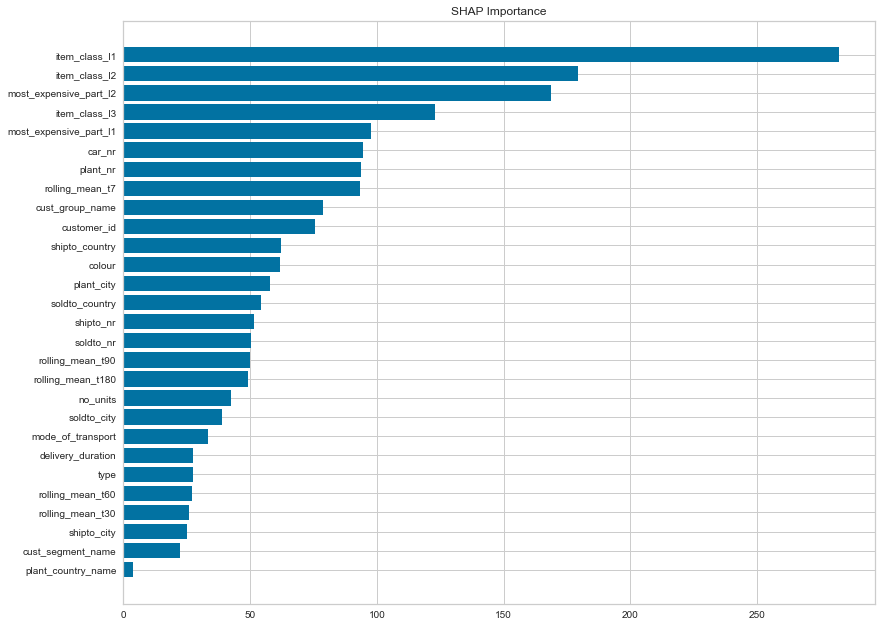

In [46]:

explainer = shap.Explainer(model)
shap_values = explainer(X)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')


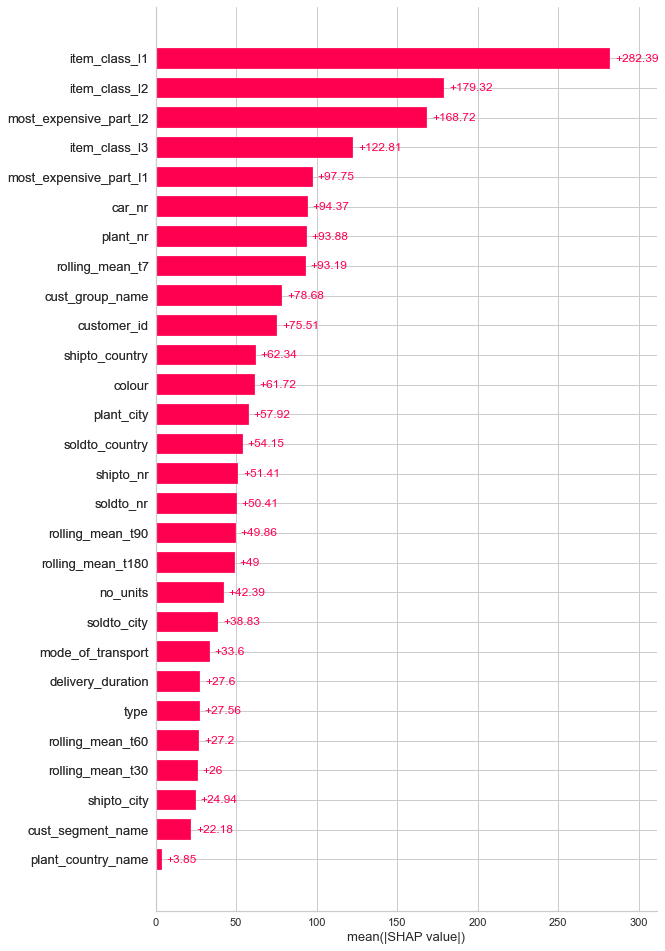

In [47]:

shap.plots.bar(shap_values, max_display=X.shape[0])


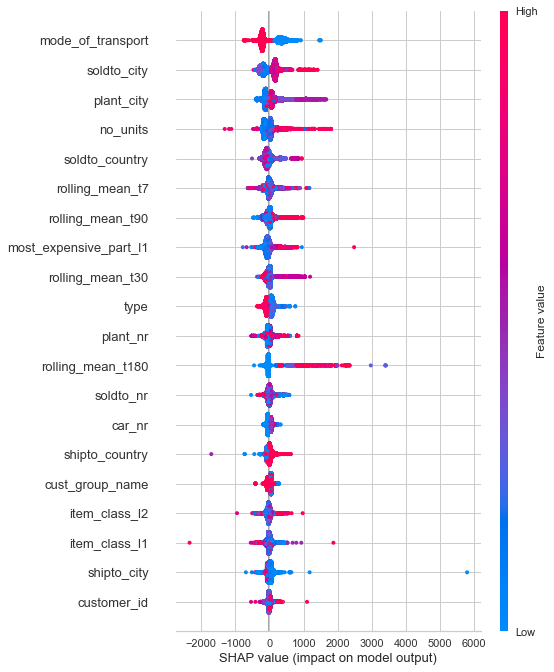

In [48]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names = np.array(X.columns)[sorted_idx])

In [49]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

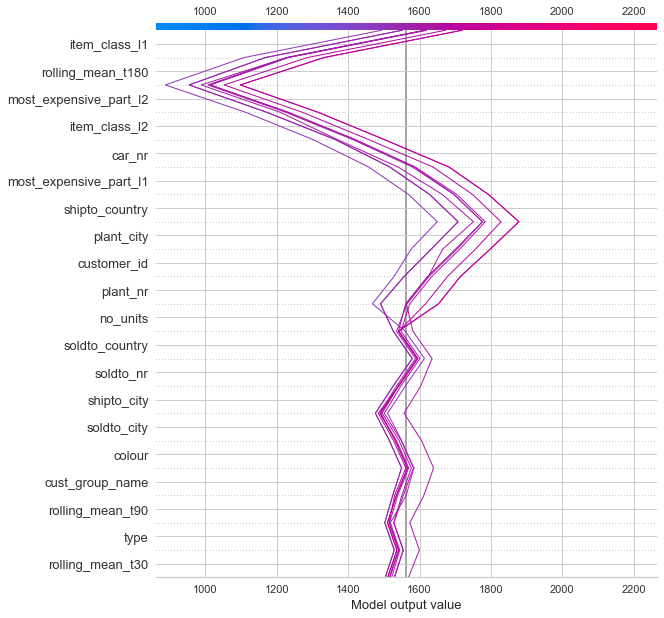

In [50]:
# Forceplot for first observation
# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(X.columns))

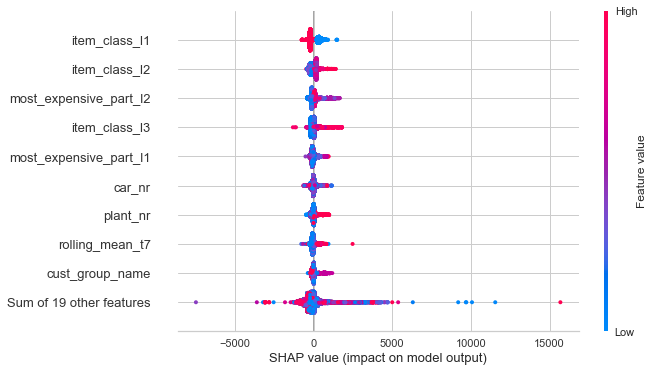

In [51]:
shap.plots.beeswarm(shap_values)